In [1]:
import random

import gymnasium as gym
import numpy as np

import tensorflow as tf

from keras import Model
from keras.layers import Dense

In [2]:
class DQN(Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        self.replay_memory = []

        self.dense1 = Dense(128, activation="relu", input_dim=state_size)
        self.dense2 = Dense(128, activation="relu")
        self.dense3 = Dense(64, activation="relu")
        self.dense4 = Dense(32, activation="relu")
        self.dense5 = Dense(action_size, activation="softmax")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)

        return x
    
    def remember(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))

In [3]:
def update_model(model: DQN):
    # 리플레이 버퍼 크기가 작으면 업데이트하지 않음
    if len(model.replay_memory) < 1000:
        return
    
    # 너무 많으면 리플레이 버퍼 pop
    if len(model.replay_memory) > 30000:
        del model.replay_memory[0]

    # # 메모리에서 랜덤 샘플링
    sample_size = 500
    samples = random.sample(model.replay_memory, sample_size)

    # 분할
    states, actions, rewards, next_states = zip(*samples)

    # numpy 배열로 변환
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    
    # 모델 예측과 타겟 값 계산
    targets = model.call(states).numpy()  # type: ignore
    next_q_values = model.call(next_states).numpy() # type: ignore

    targets[np.arange(len(samples)), actions] = rewards + 0.99 * np.max(next_q_values, axis=1)

    # 모델 업데이트
    with tf.GradientTape() as tape:
        q_values = model.call(states)
        loss = tf.keras.losses.mean_squared_error(targets, q_values)

    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [4]:
import os    
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def draw_qvalue(model, episode):
    thetas = np.arange(-np.pi, np.pi, 0.1)
    velocities = np.arange(-4, 4, 0.1)

    states = np.array([[np.cos(theta), np.sin(theta), velocity] for theta in thetas for velocity in velocities])
    z = model.call(states).numpy()
    z_np = np.array(z).reshape((len(thetas), len(velocities), 9))

    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle("Episode: {}".format(episode))
    for i in range(9):
        ax[i//5][i%5].title.set_text("Action: {}".format(i))
        ax[i//5][i%5].imshow(z_np[:,:,i], cmap='hot', interpolation='nearest', clim=(0, 1))
        ax[i//5][i%5].set_xticks(np.arange(0, 81, 10))
        ax[i//5][i%5].set_yticks(np.arange(0, 64, 10))
        ax[i//5][i%5].set_xticklabels(np.arange(-4, 5, 1))
        ax[i//5][i%5].set_yticklabels(np.round(np.arange(-np.pi, np.pi+0.1, 2*np.pi/6),1))
        ax[i//5][i%5].set_xlabel("Velocity")
        ax[i//5][i%5].set_ylabel("Theta")
        ax[i//5][i%5].invert_yaxis()  # y축 변경
    ax[1][4].axis('off')  # 마지막 subplot은 빈 공간

    plt.tight_layout()
    plt.savefig("model8_image/episode_{}.png".format(episode))

Episode: 0, Steps: 500, Score: -6.26, Last Score: -8.62
Episode: 1, Steps: 500, Score: -5.12, Last Score: -4.40
Episode: 2, Steps: 500, Score: -3.70, Last Score: 6.68
Episode: 3, Steps: 500, Score: -5.41, Last Score: -3.67
Episode: 4, Steps: 500, Score: -7.63, Last Score: -4.67
Episode: 5, Steps: 500, Score: -5.48, Last Score: -5.11
Episode: 6, Steps: 500, Score: -5.92, Last Score: -1.62
Episode: 7, Steps: 500, Score: -6.14, Last Score: -5.19
Episode: 8, Steps: 500, Score: -6.36, Last Score: -3.88
Episode: 9, Steps: 500, Score: -7.99, Last Score: -7.33
Episode: 10, Steps: 500, Score: -8.37, Last Score: -8.71
Episode: 11, Steps: 500, Score: -8.05, Last Score: -9.03
Episode: 12, Steps: 500, Score: -7.44, Last Score: -8.68
Episode: 13, Steps: 500, Score: -6.83, Last Score: -4.74
Episode: 14, Steps: 500, Score: -7.36, Last Score: -5.59
Episode: 15, Steps: 500, Score: -5.76, Last Score: -1.39
Episode: 16, Steps: 500, Score: -6.47, Last Score: -6.20
Episode: 17, Steps: 500, Score: -6.66, Las

C:\Users\honey\AppData\Local\Temp\ipykernel_7684\916640491.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 5, figsize=(20, 8))


Episode: 200, Steps: 500, Score: -8.48, Last Score: -8.61
Episode: 201, Steps: 500, Score: -2.68, Last Score: 42.98
Episode: 202, Steps: 500, Score: 27.74, Last Score: 31.98
Episode: 203, Steps: 500, Score: -8.88, Last Score: -8.59
Episode: 204, Steps: 500, Score: 40.76, Last Score: 35.98
Episode: 205, Steps: 500, Score: -8.82, Last Score: -9.55
Episode: 206, Steps: 500, Score: -8.00, Last Score: -5.00
Episode: 207, Steps: 500, Score: -7.05, Last Score: -8.05
Episode: 208, Steps: 500, Score: -6.57, Last Score: -4.20
Episode: 209, Steps: 500, Score: -5.91, Last Score: -2.30
Episode: 210, Steps: 500, Score: -5.52, Last Score: -2.48
Episode: 211, Steps: 500, Score: 17.56, Last Score: 32.98
Episode: 212, Steps: 500, Score: 37.48, Last Score: 42.98
Episode: 213, Steps: 500, Score: 31.69, Last Score: 30.98
Episode: 214, Steps: 500, Score: 33.21, Last Score: 53.98
Episode: 215, Steps: 500, Score: 35.87, Last Score: 42.99
Episode: 216, Steps: 500, Score: 30.42, Last Score: 42.99
Episode: 217, 

KeyboardInterrupt: 

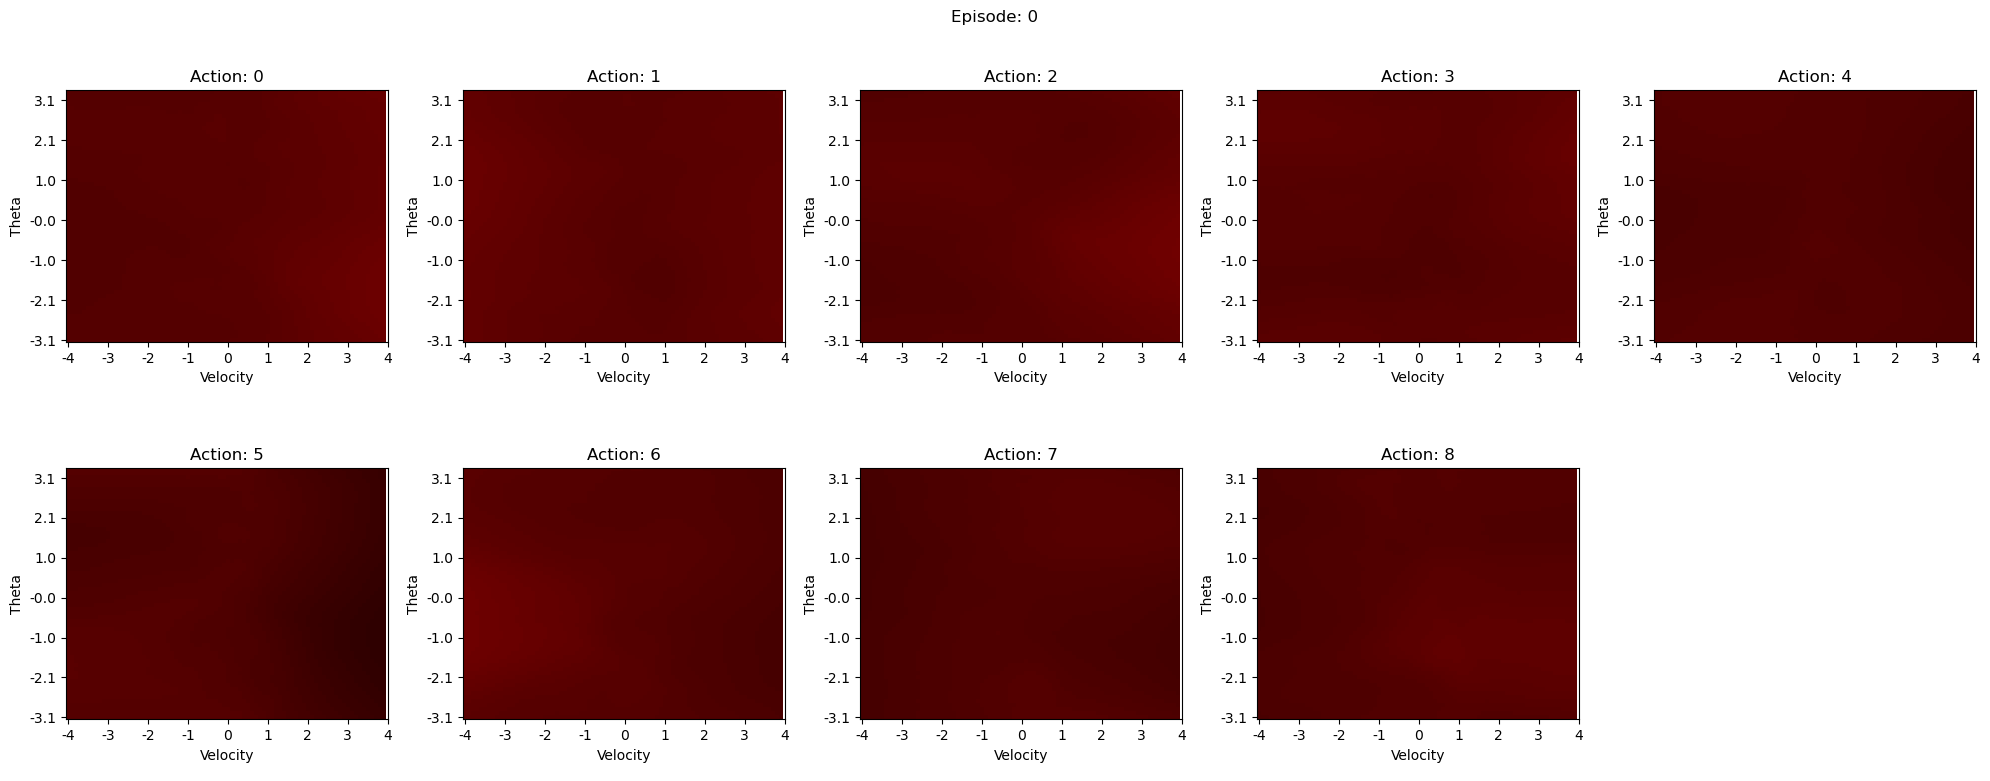

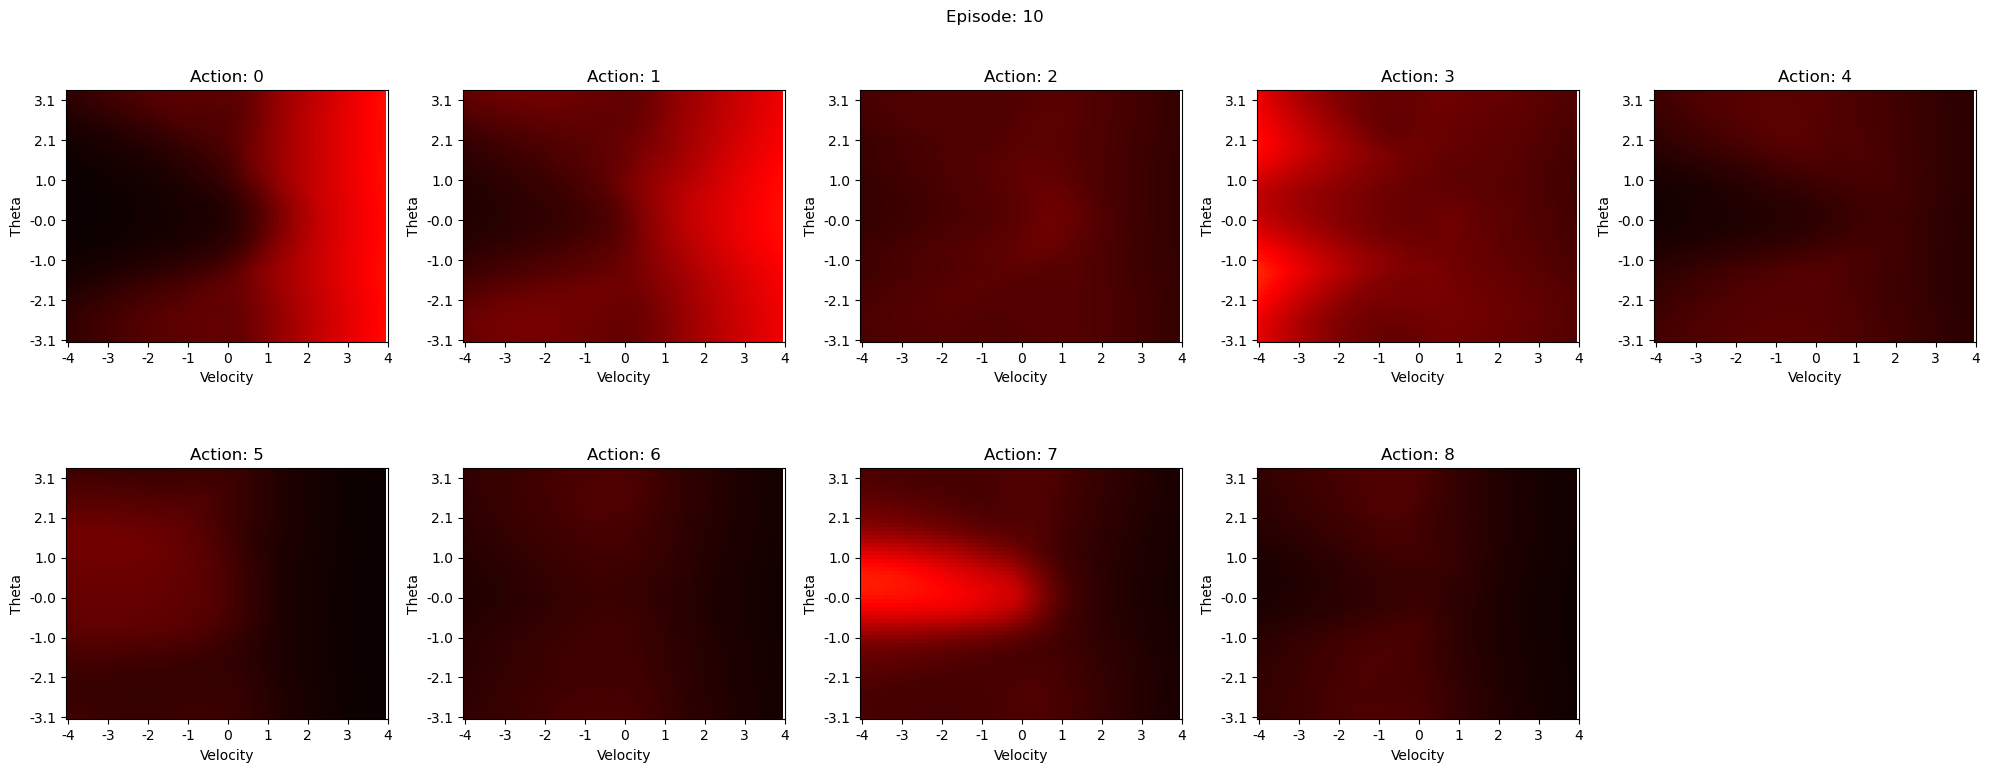

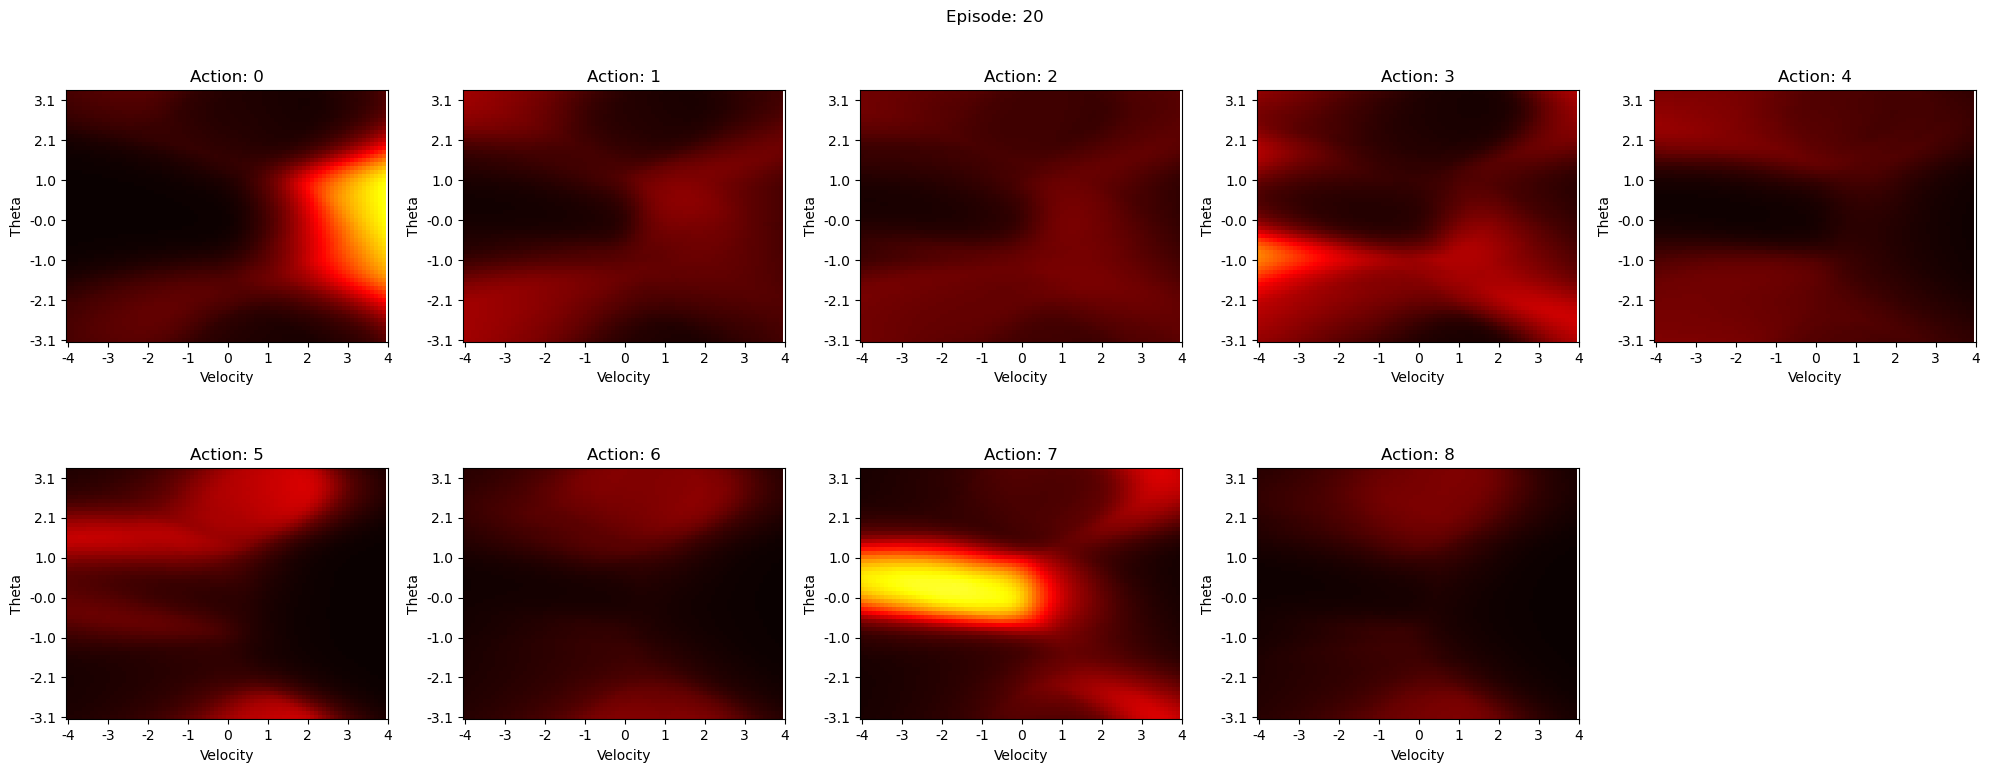

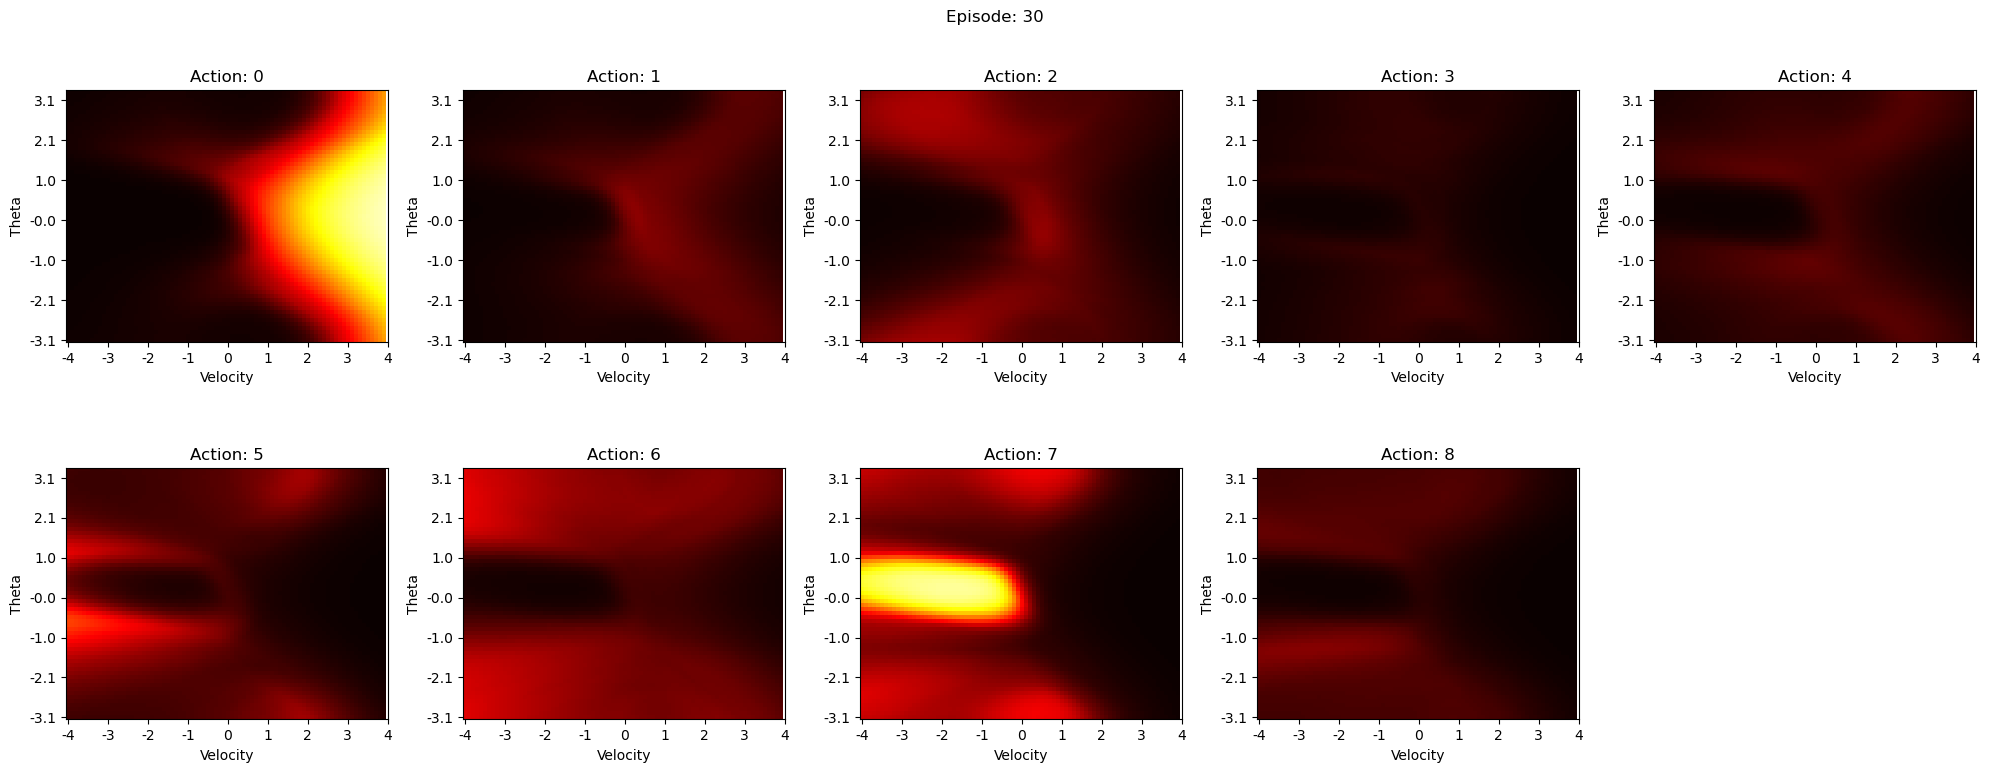

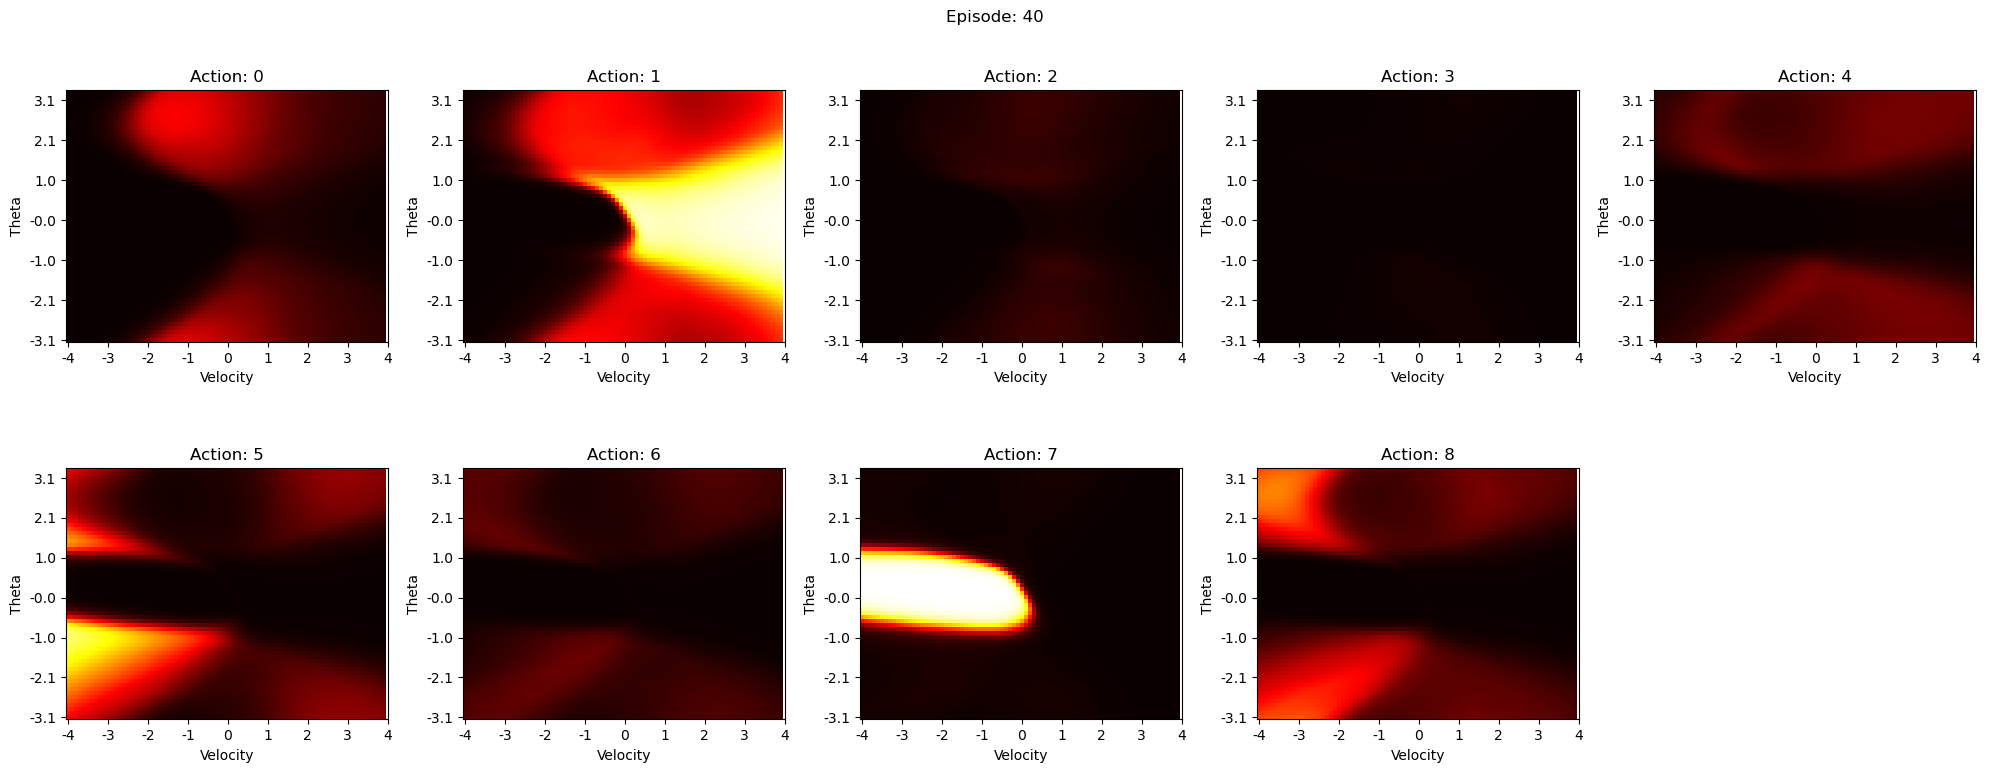

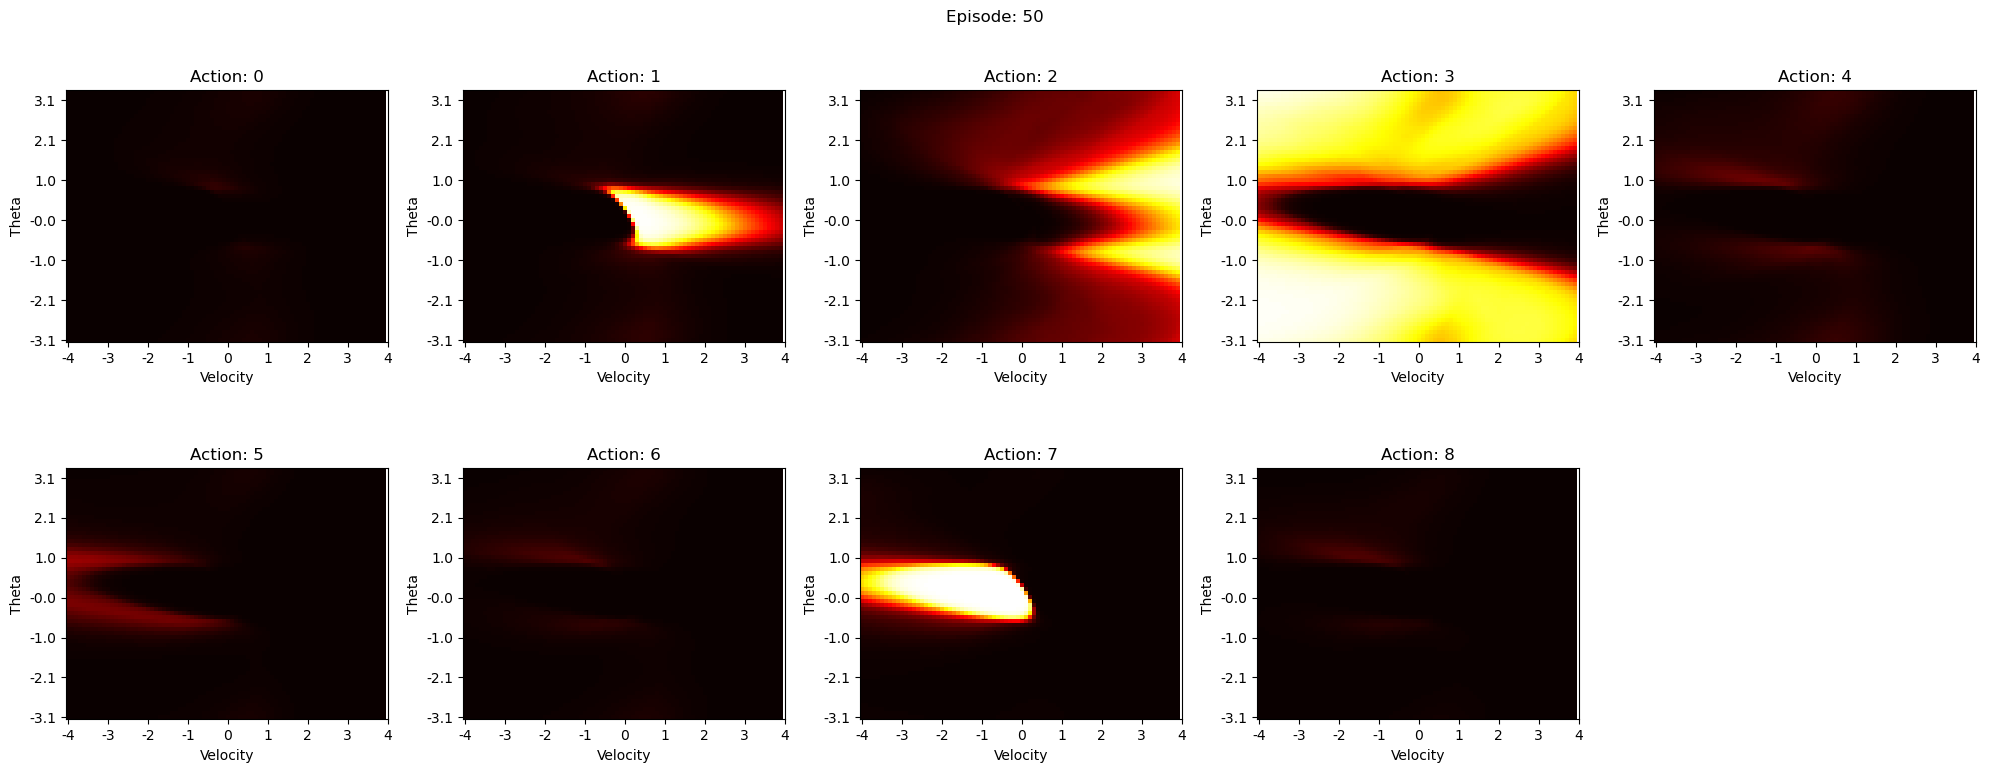

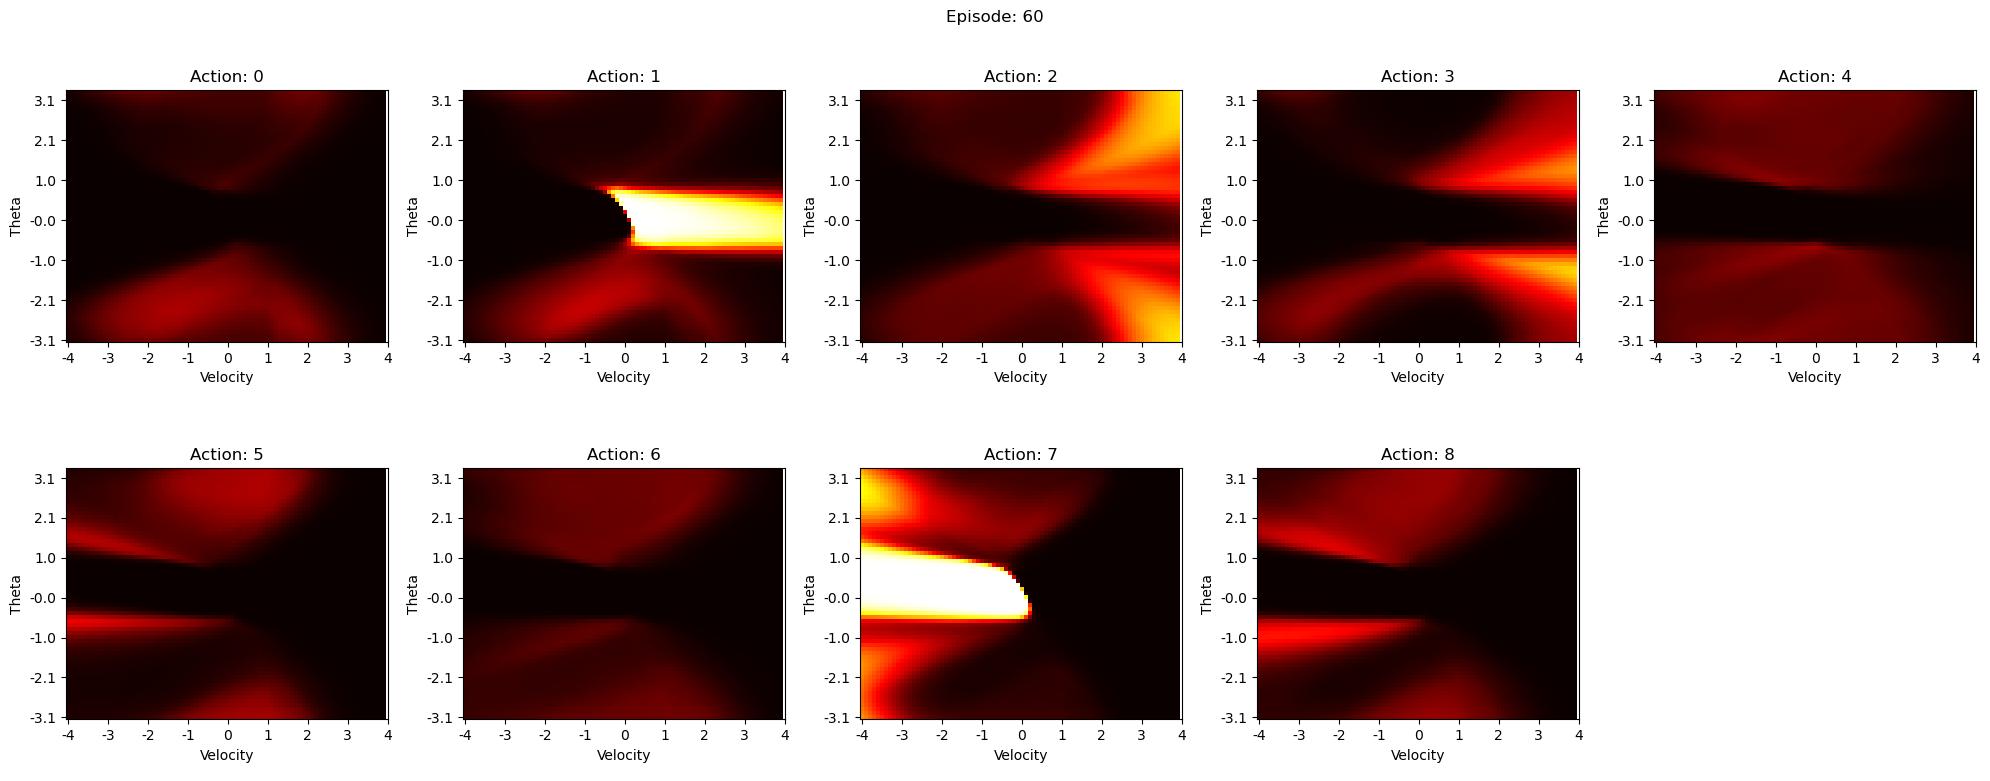

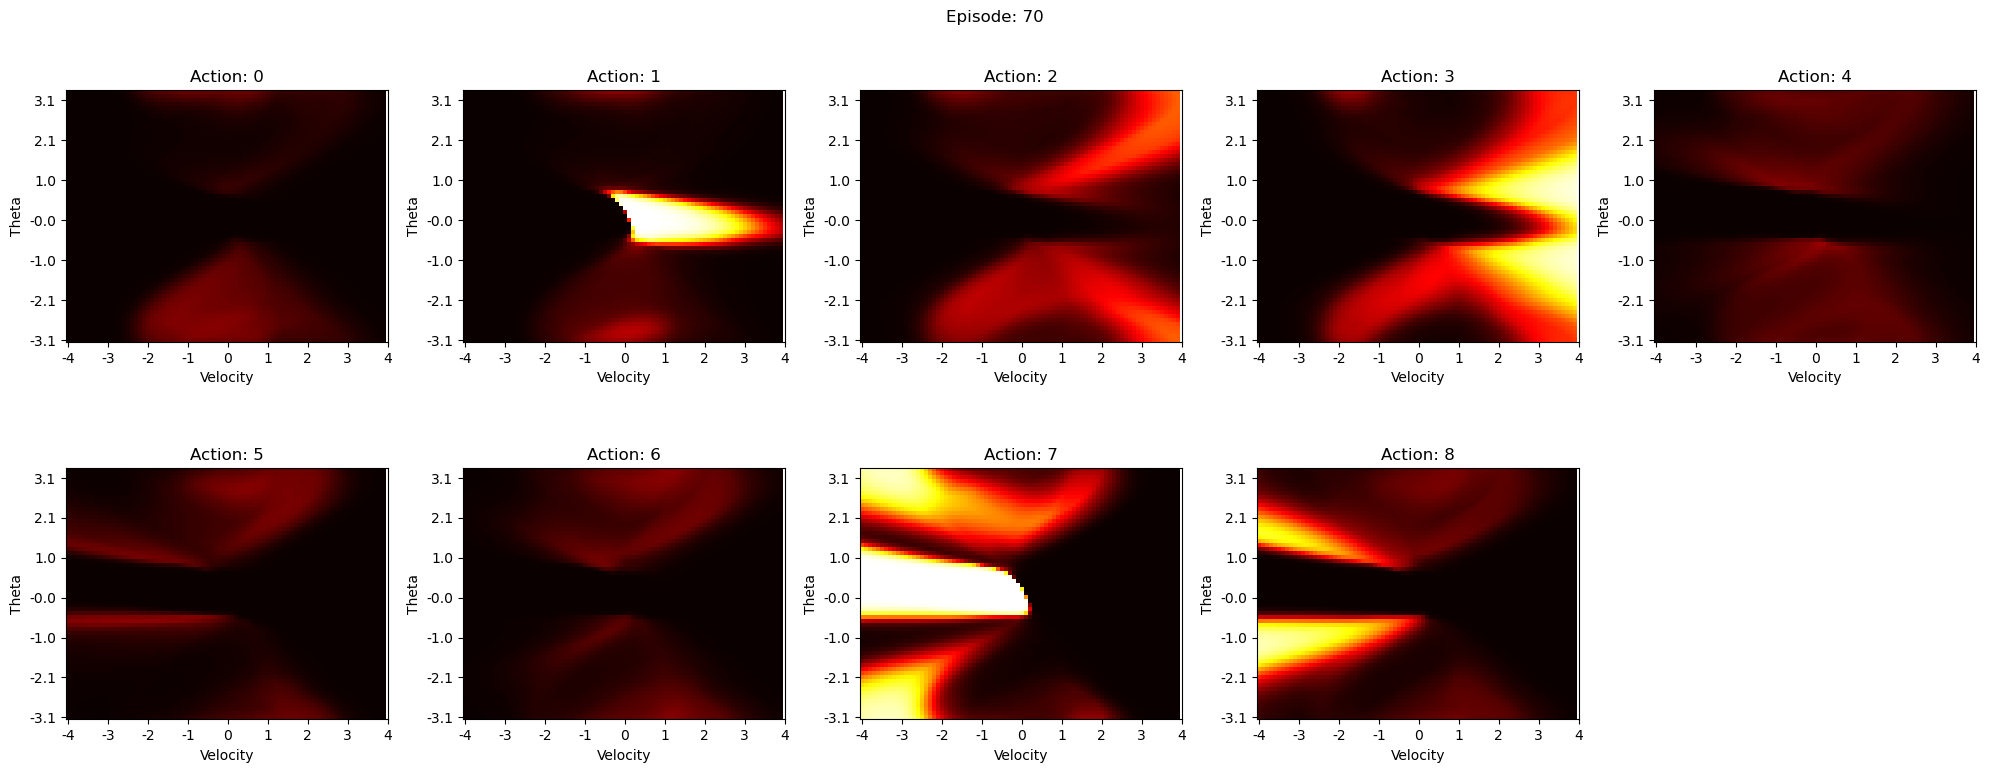

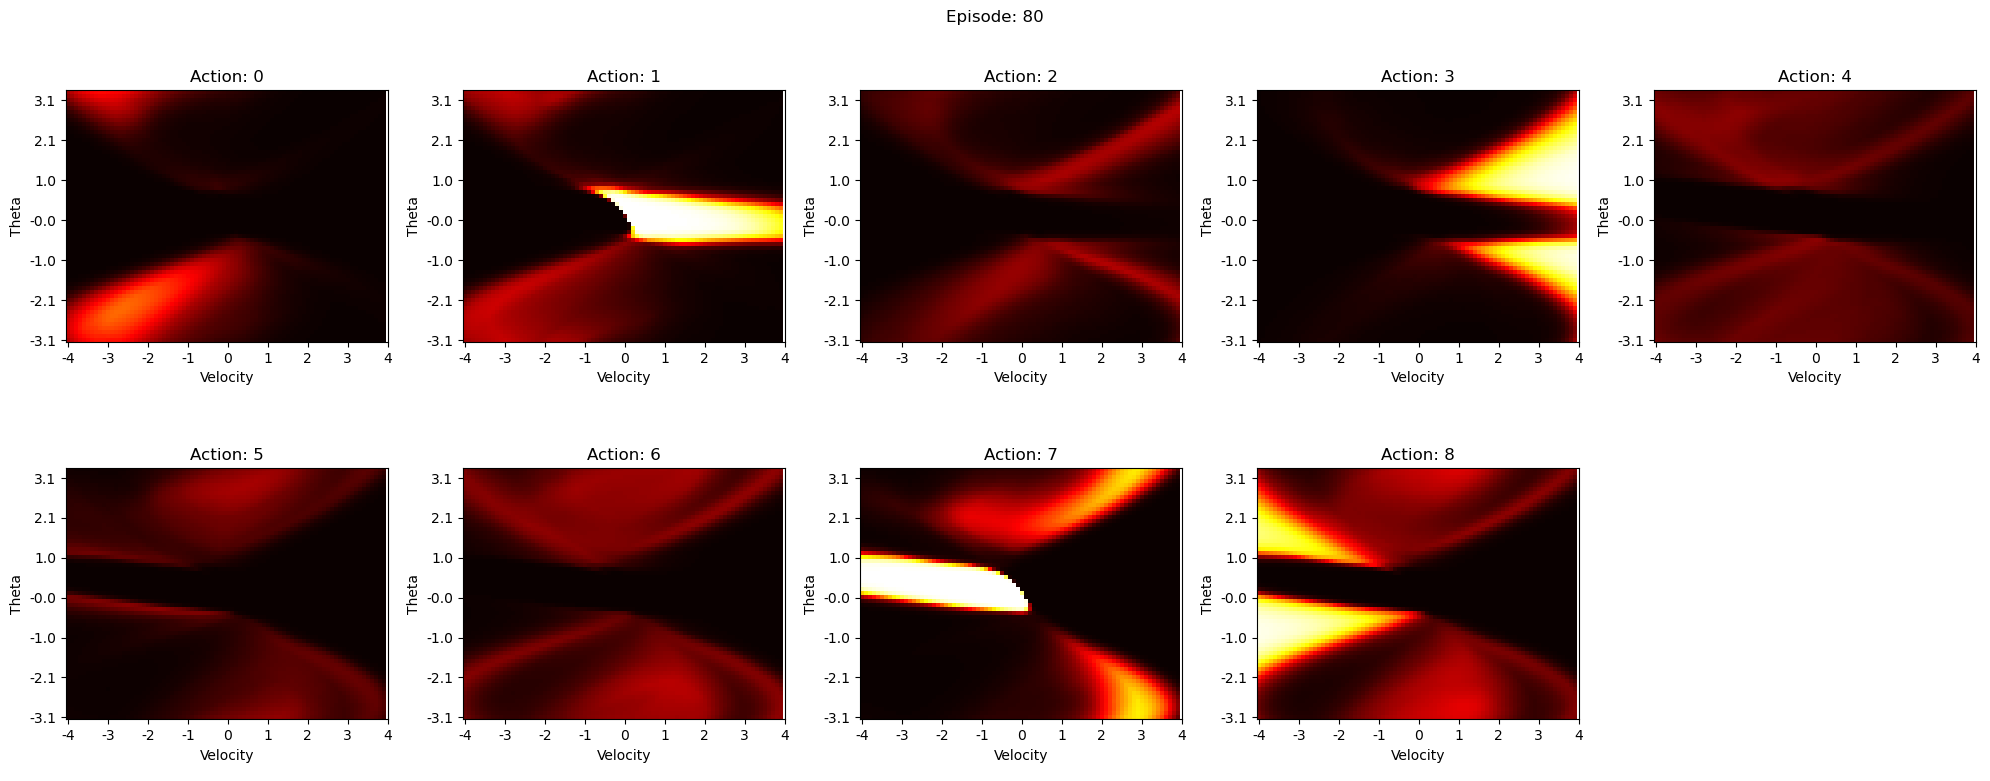

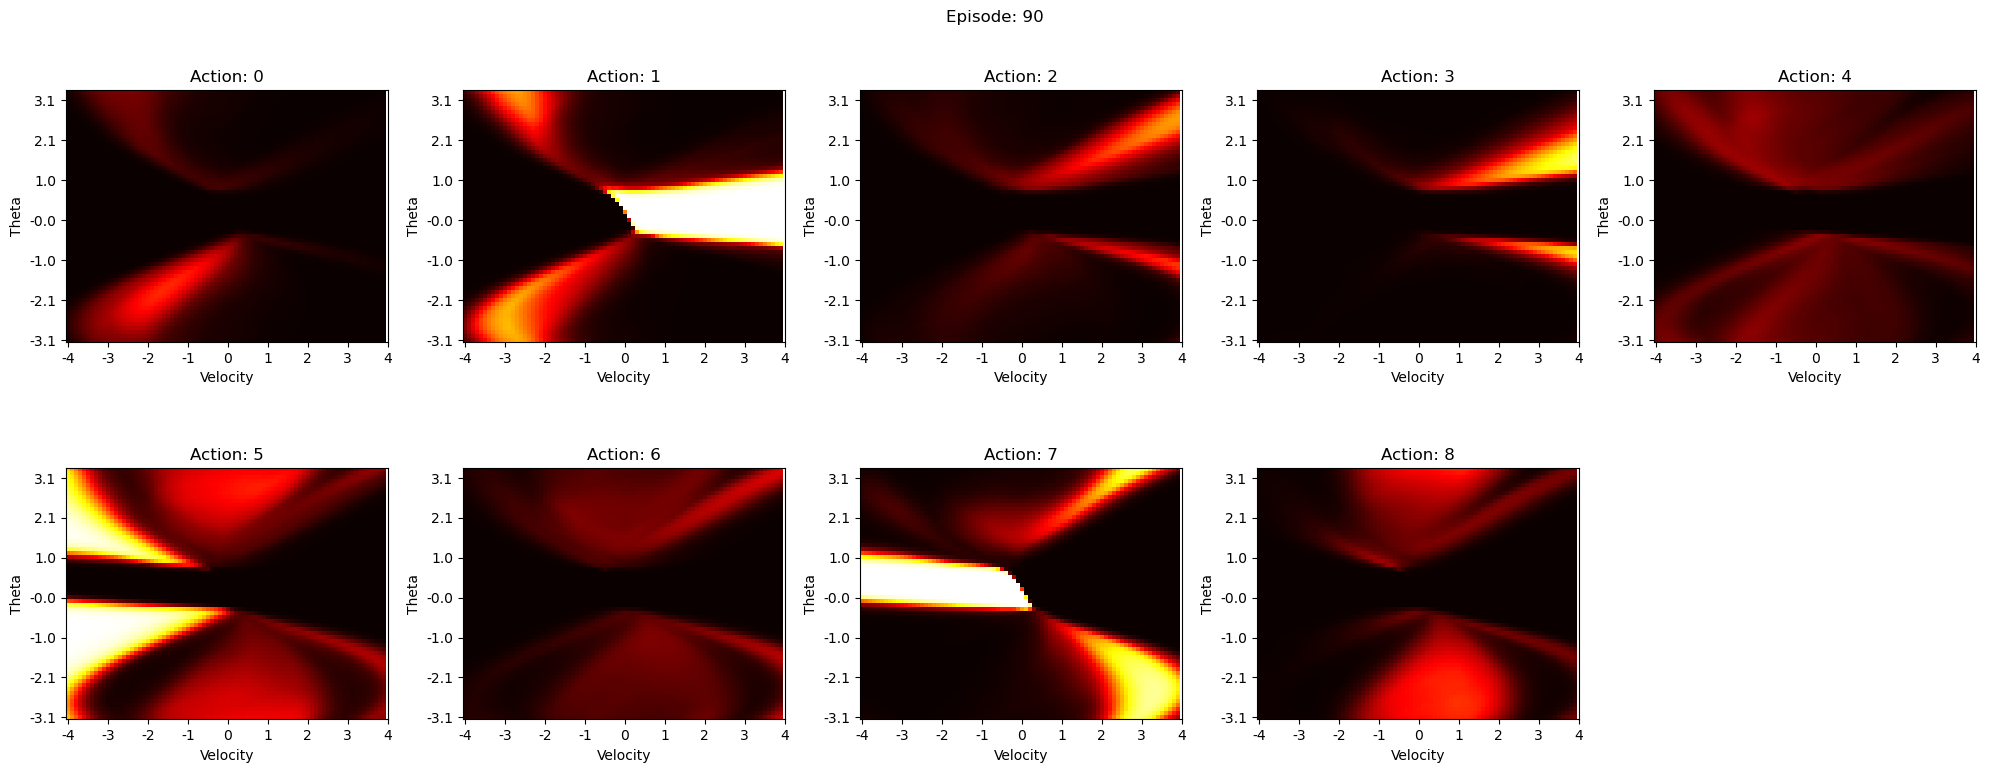

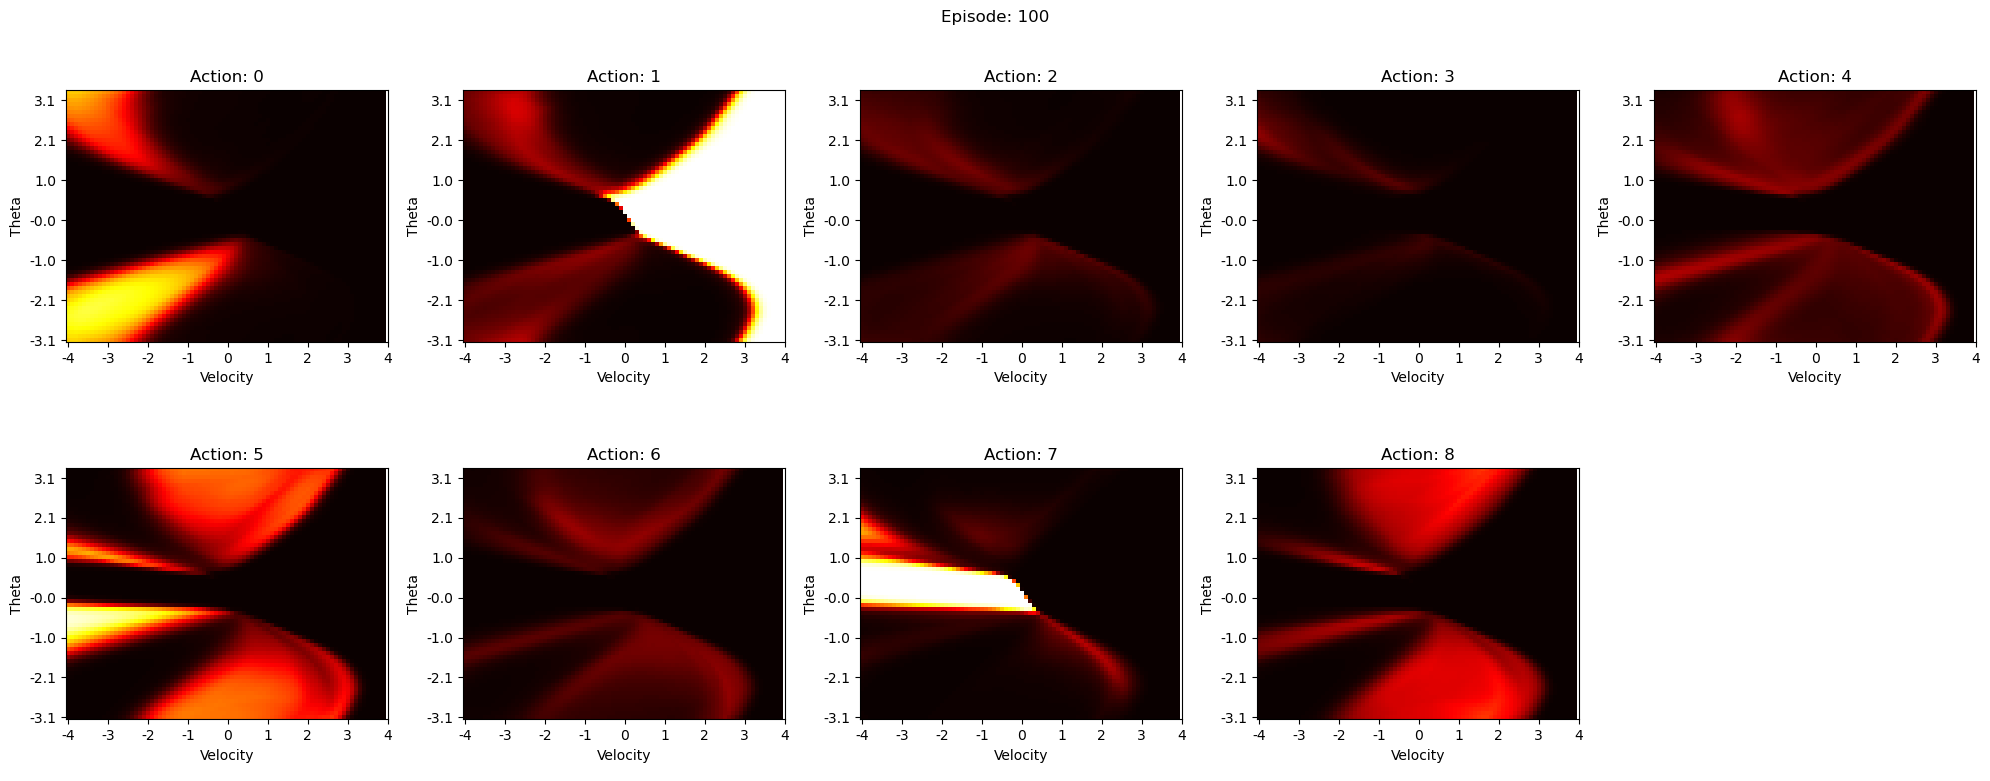

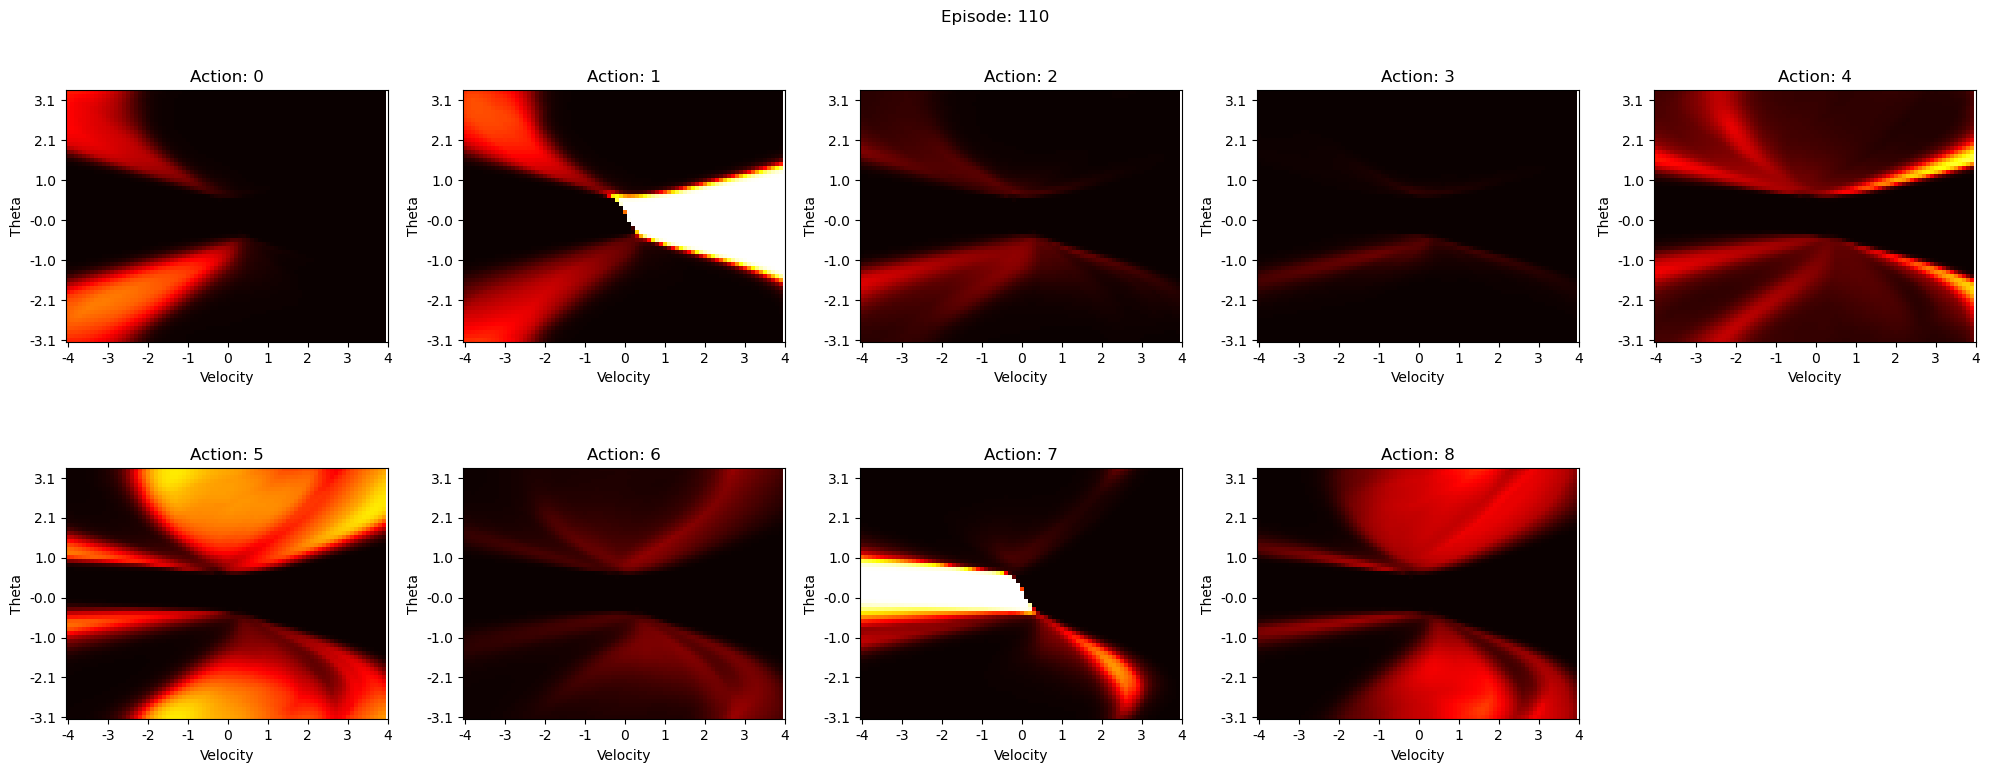

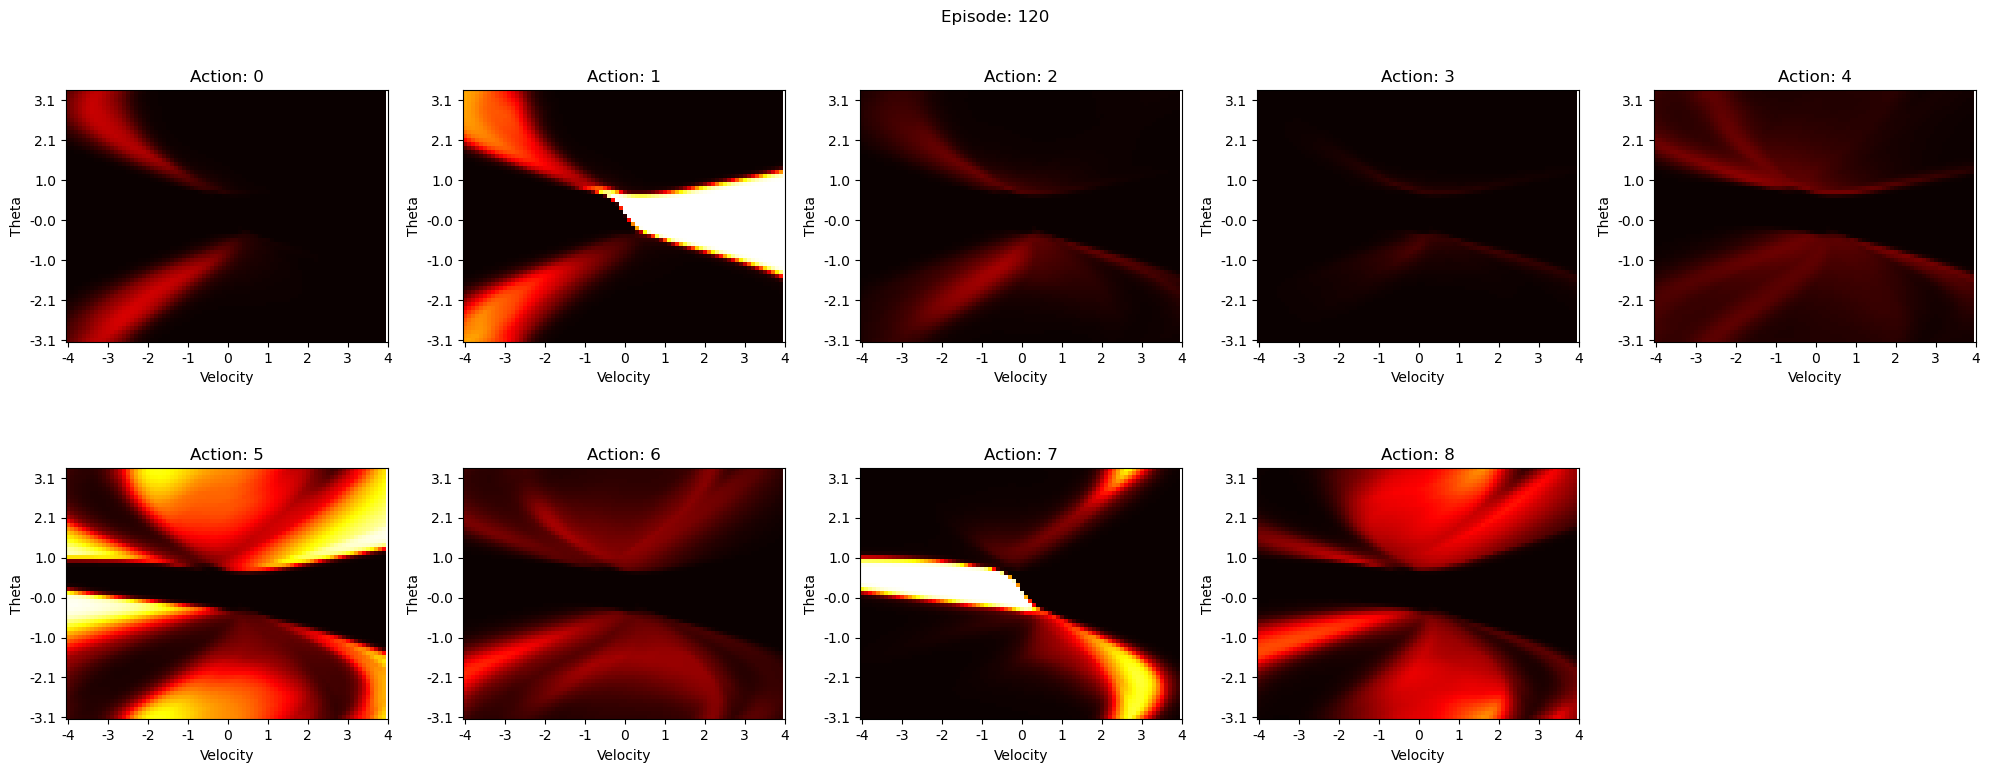

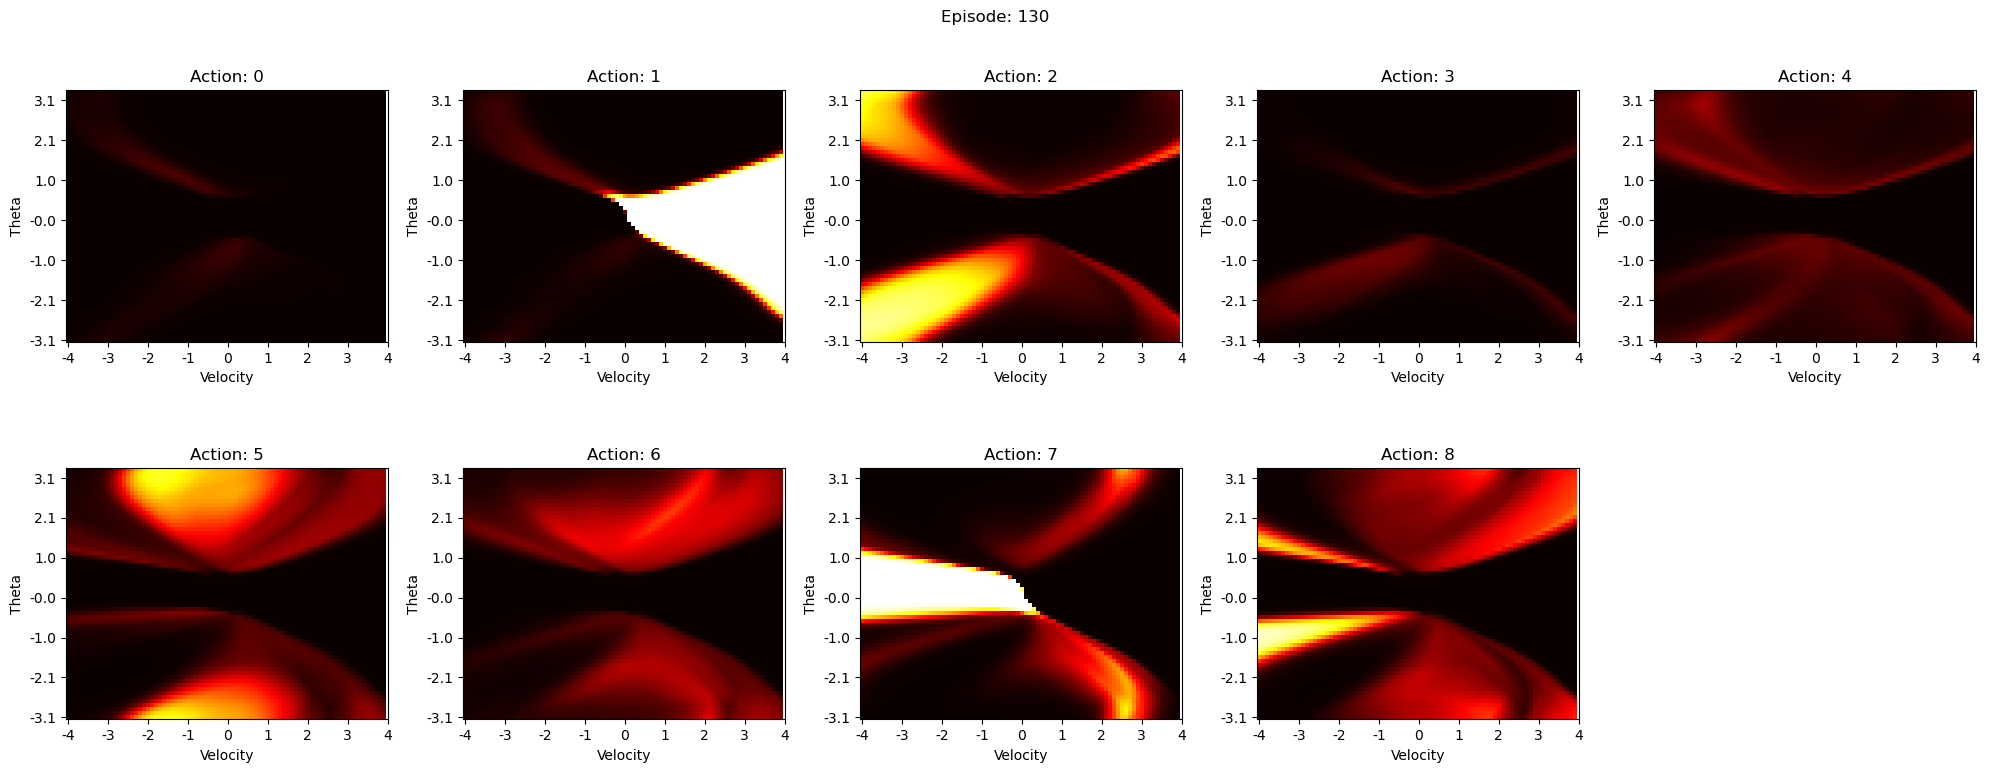

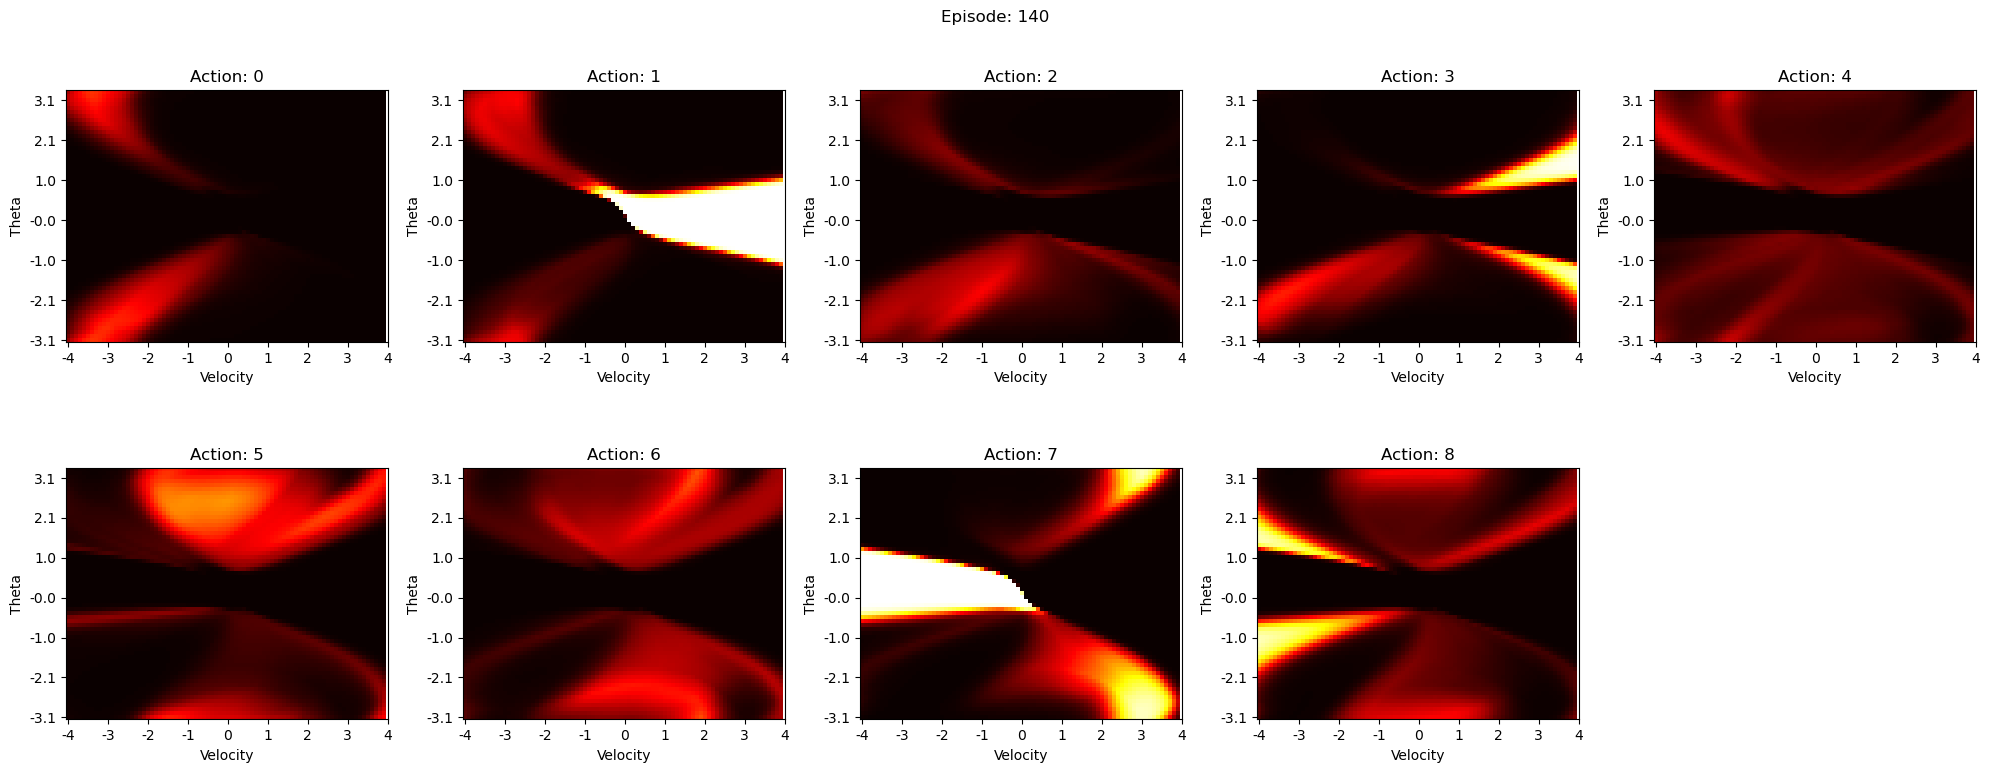

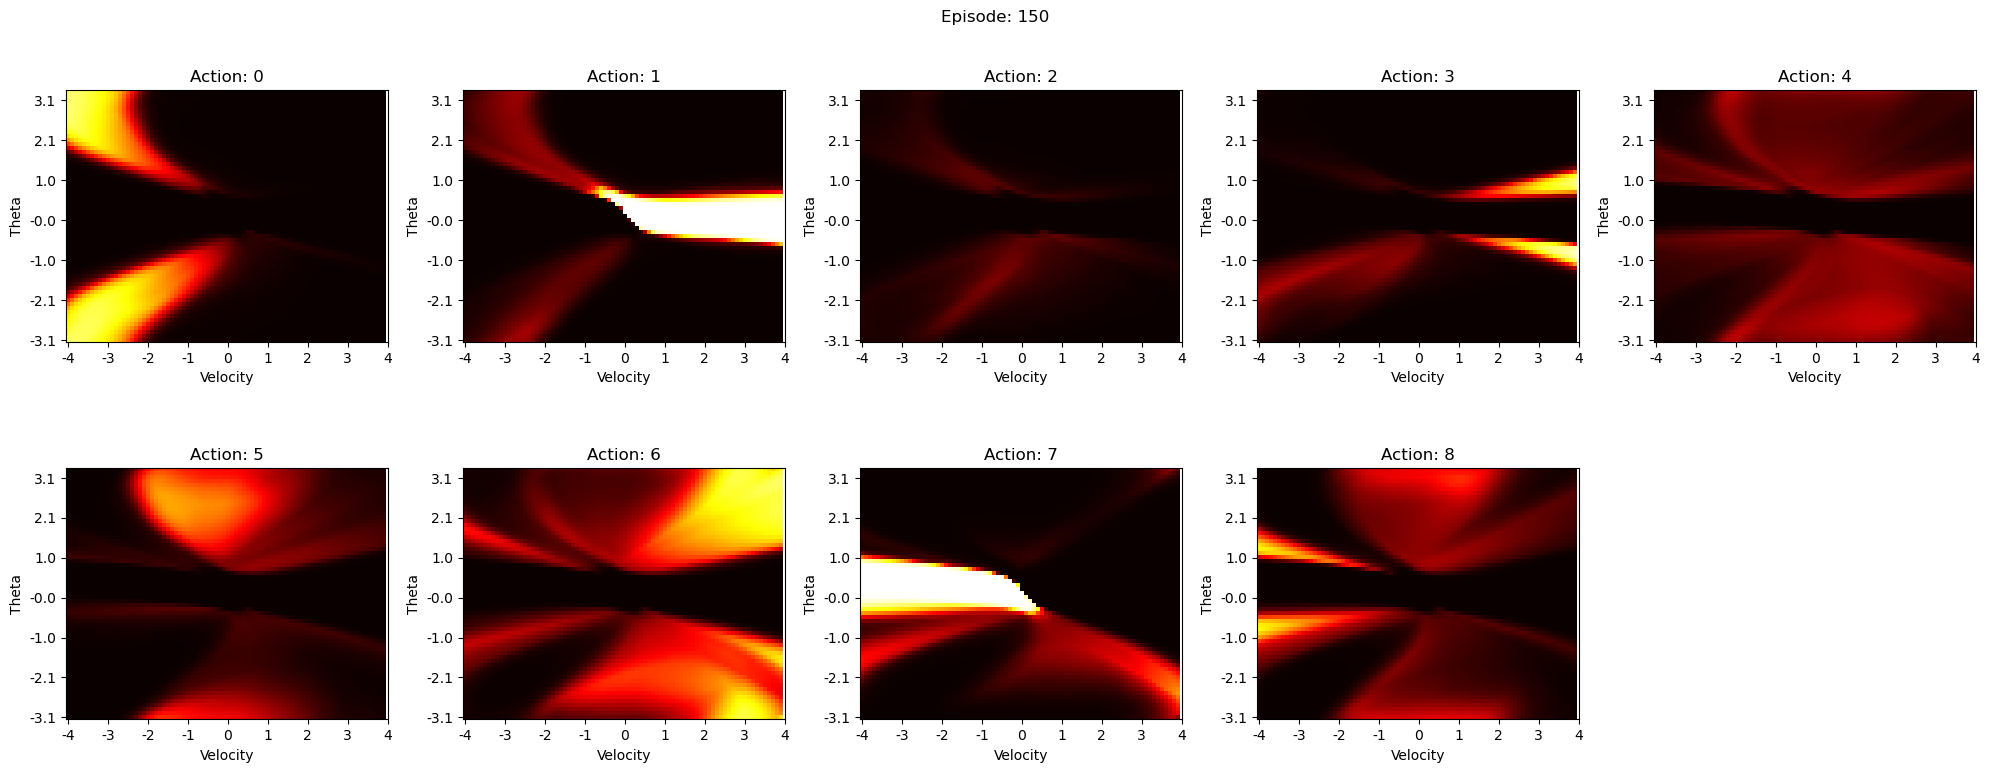

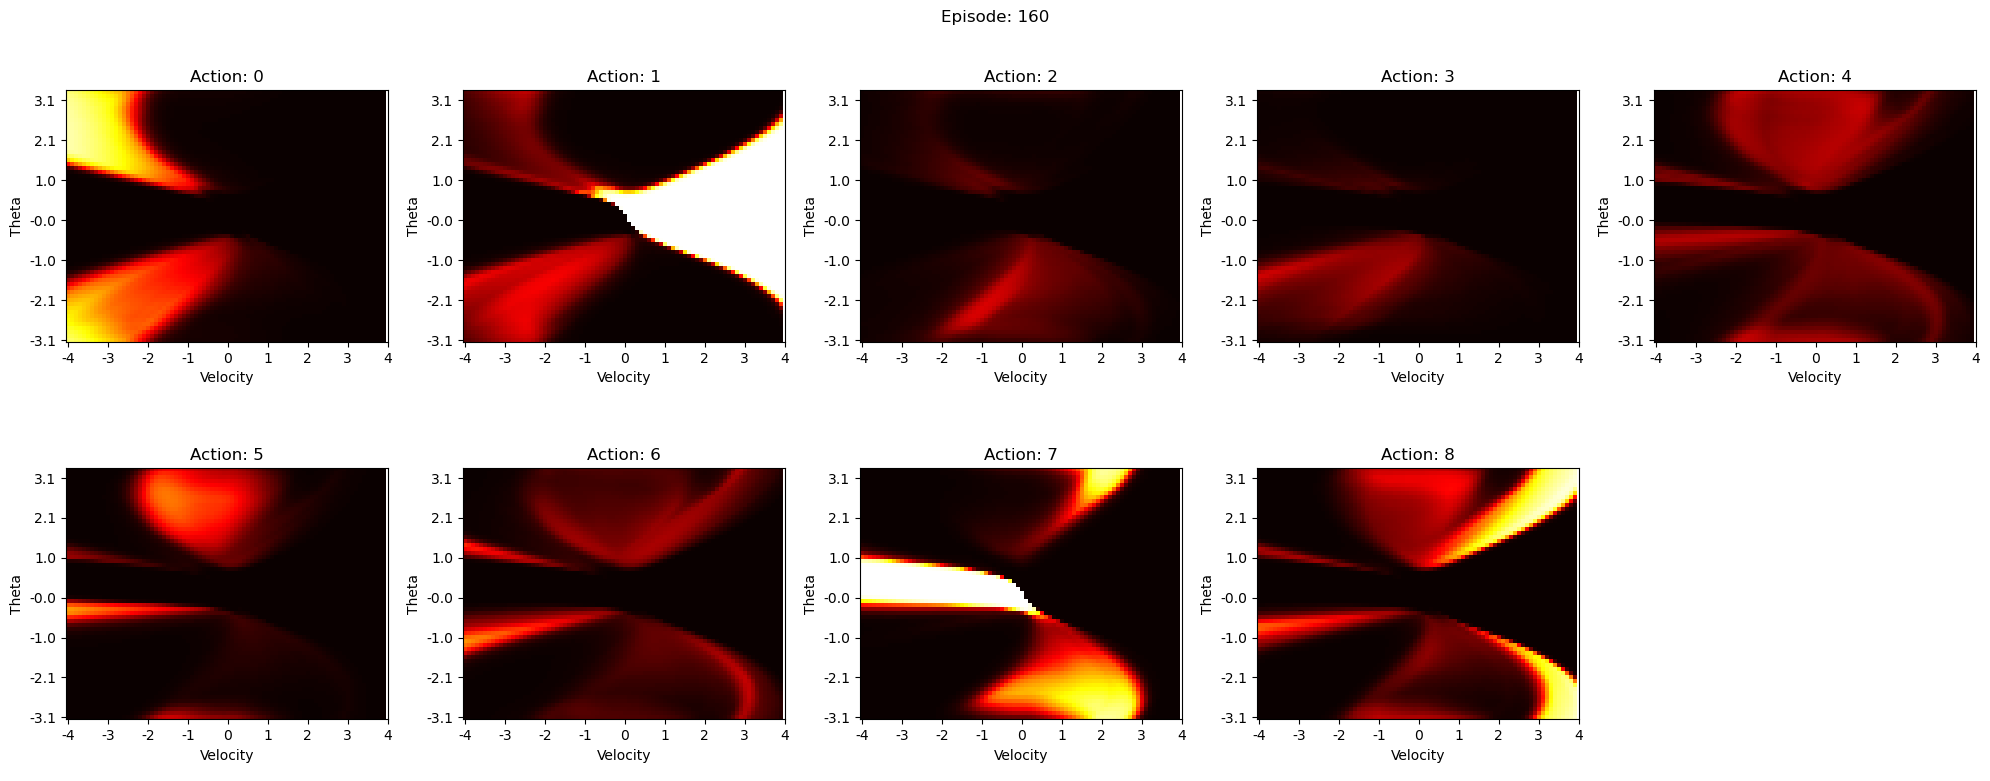

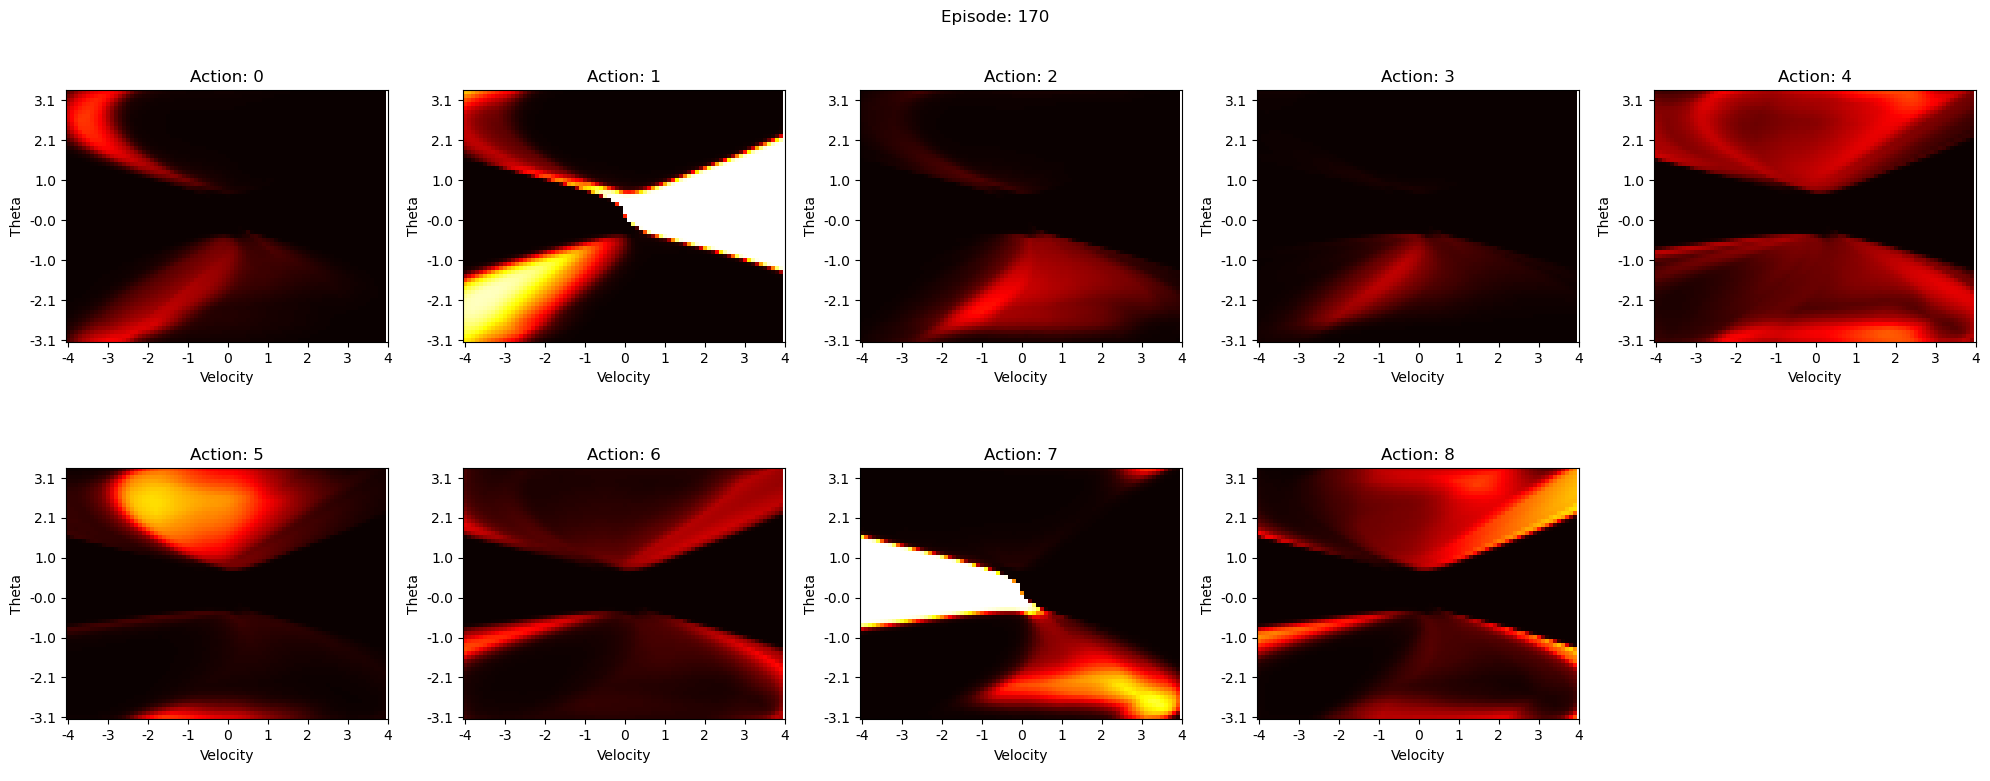

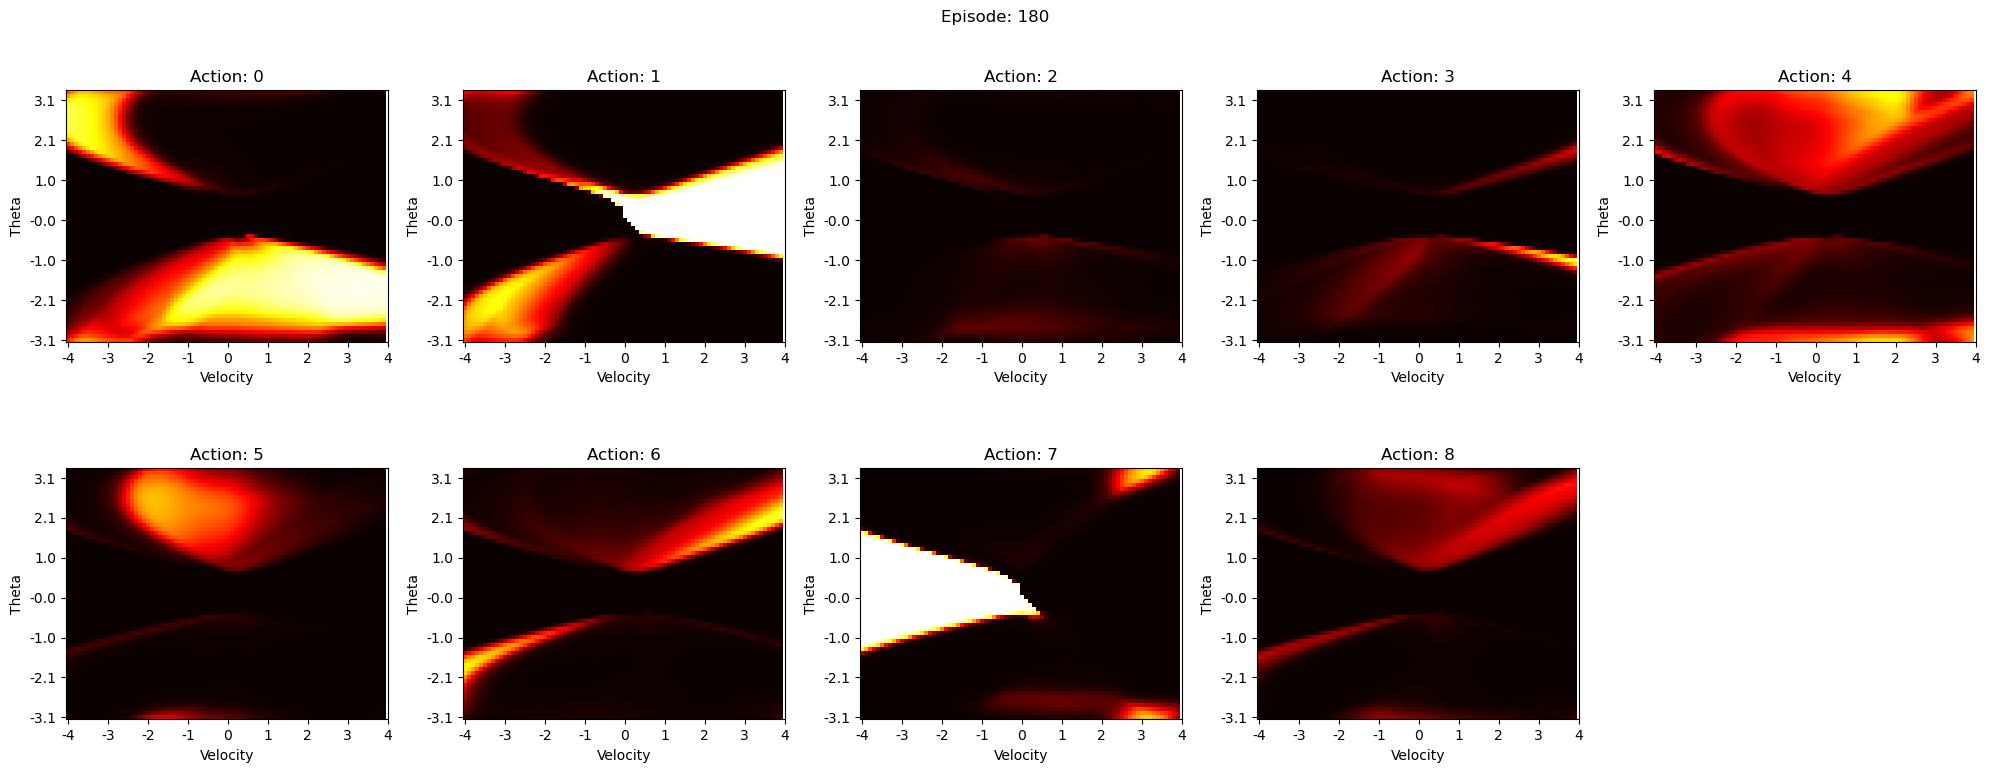

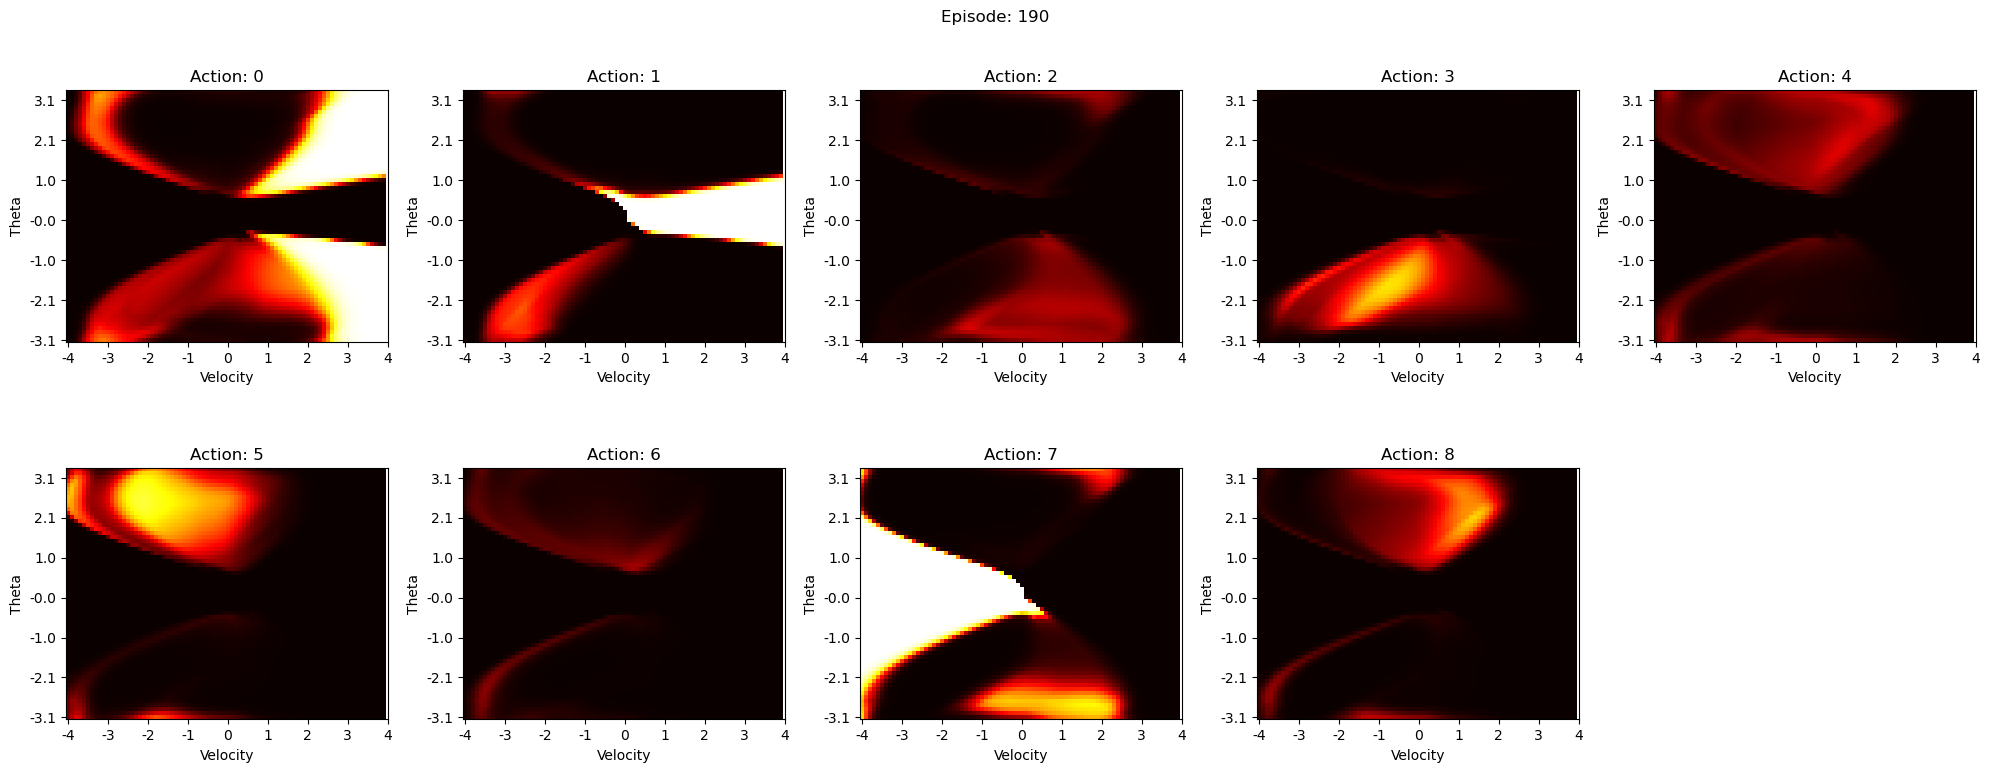

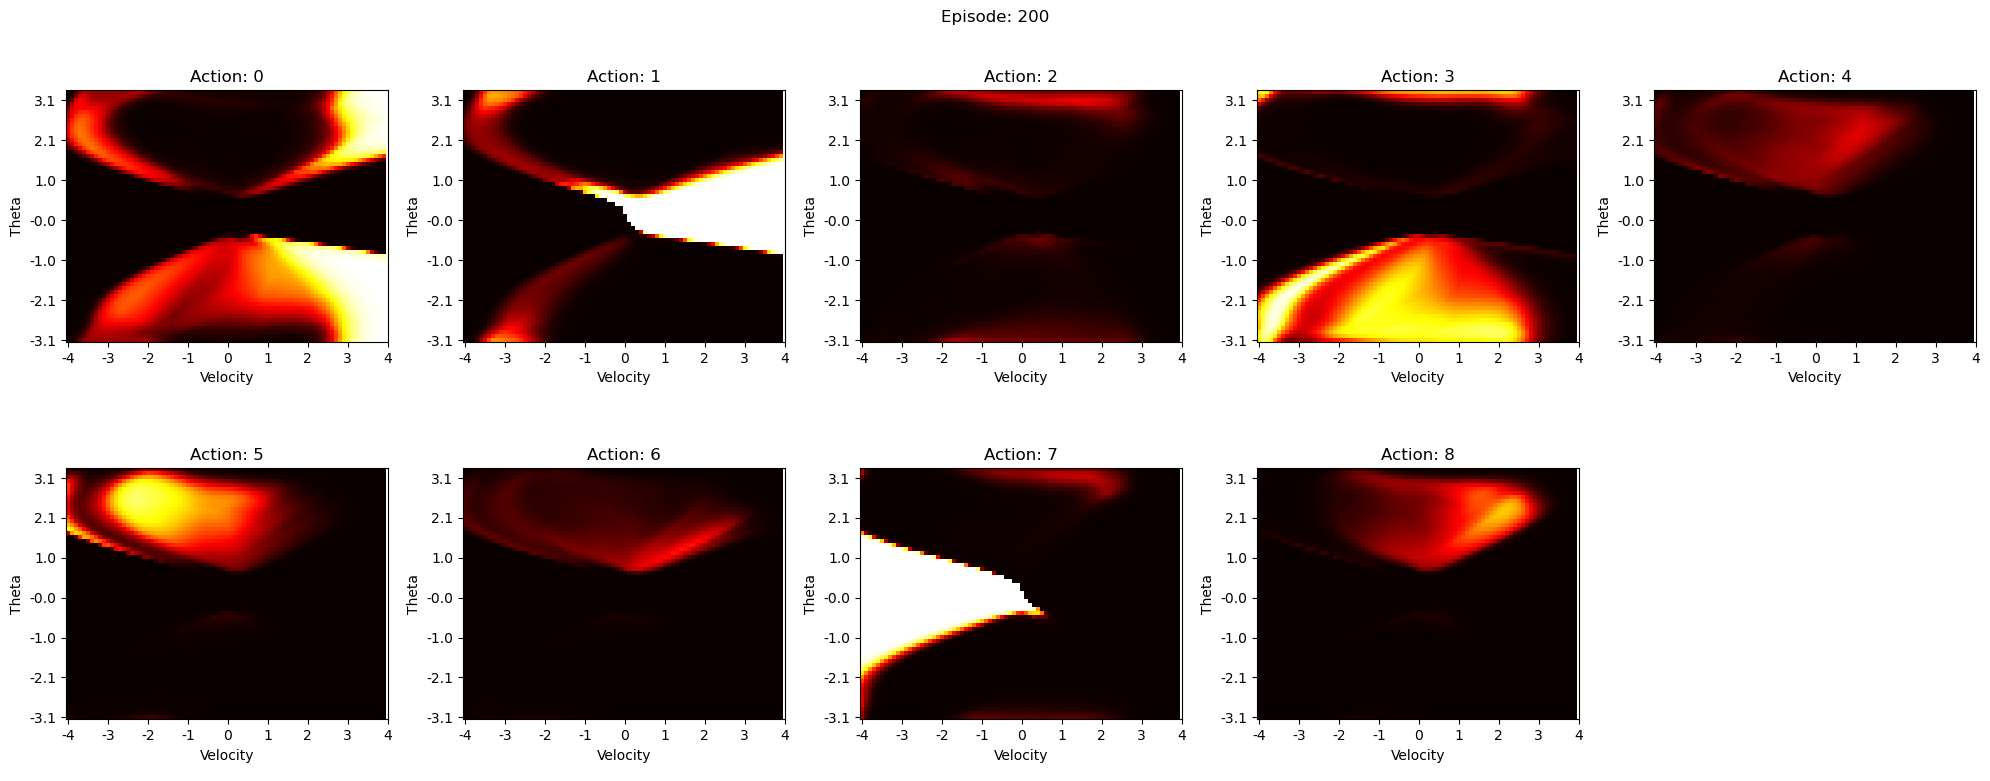

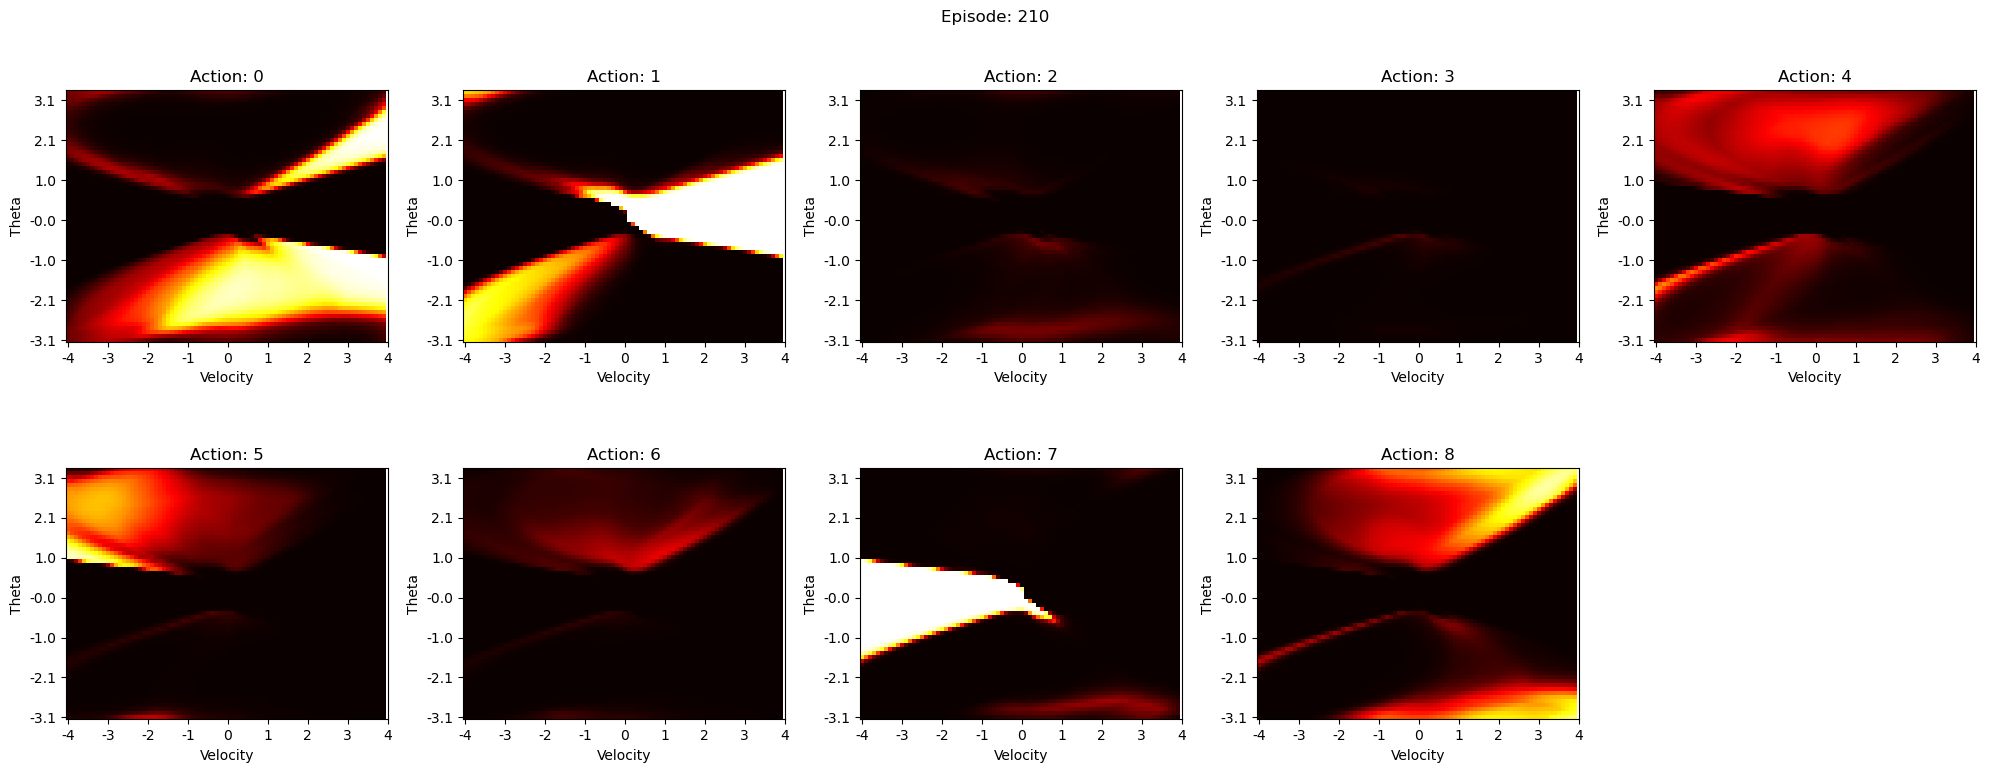

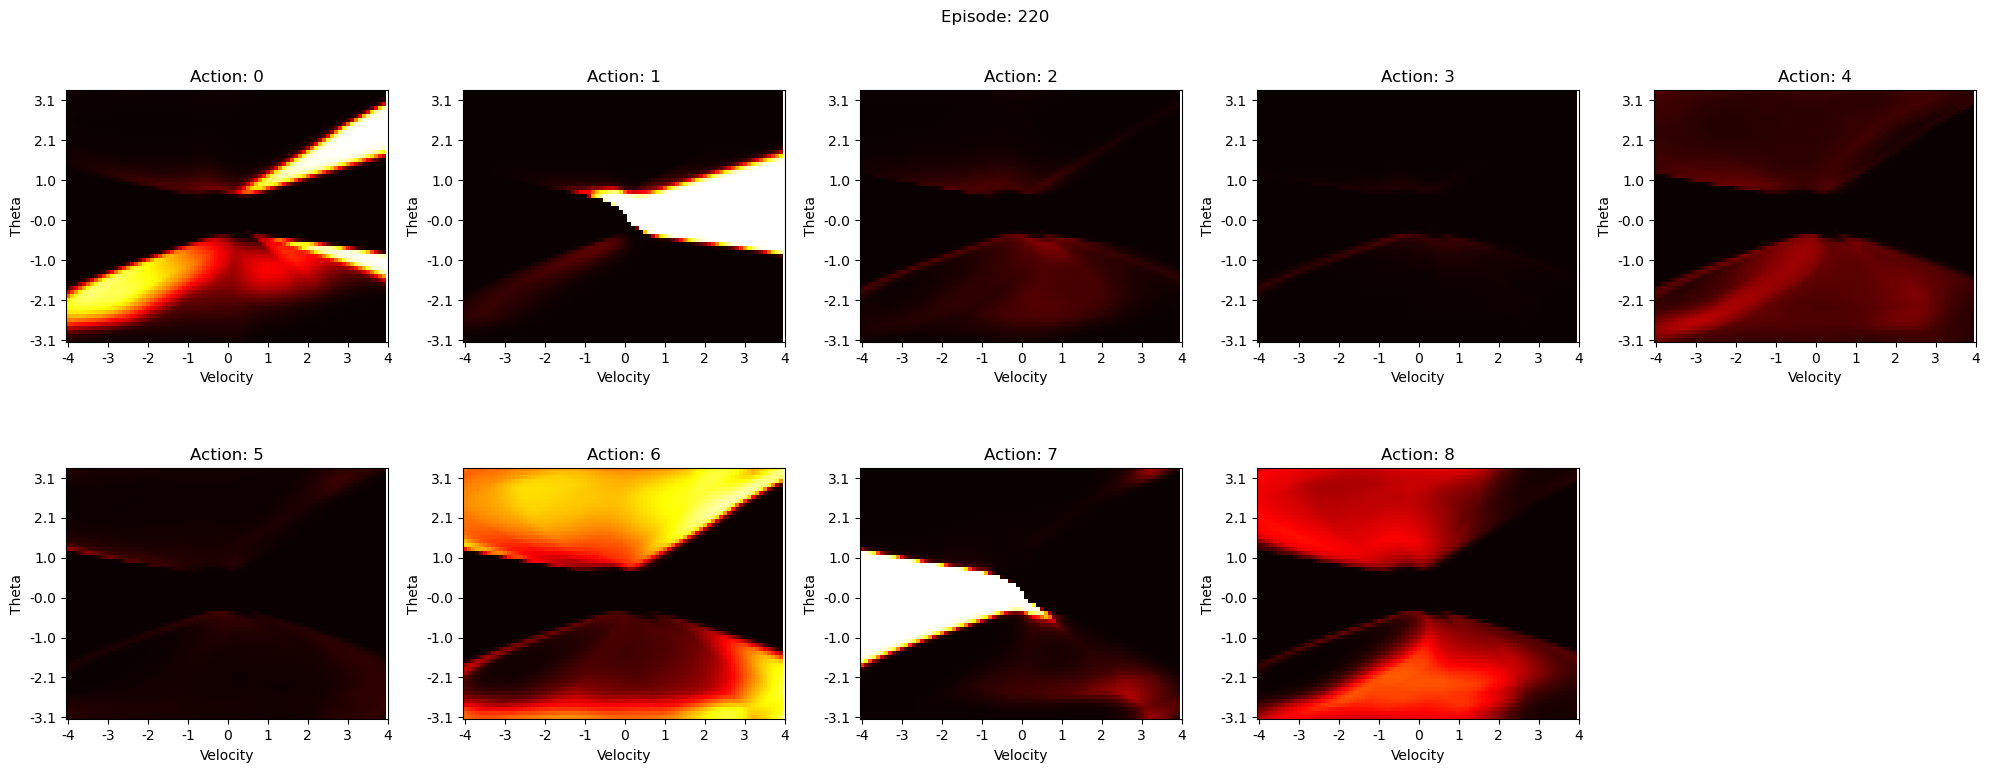

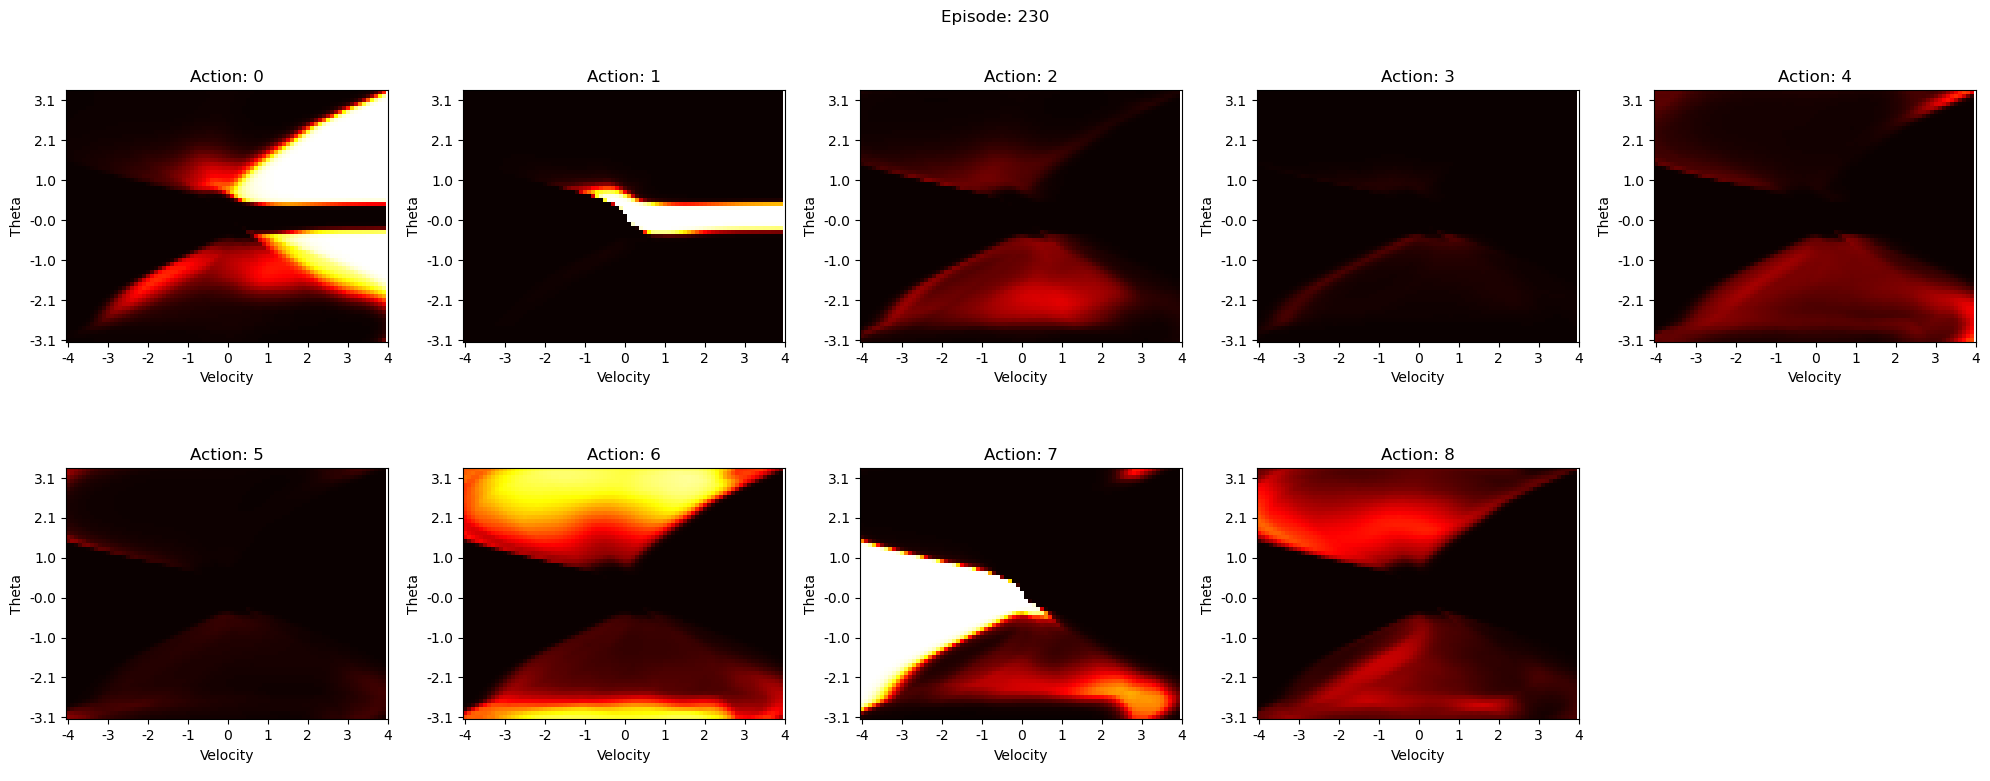

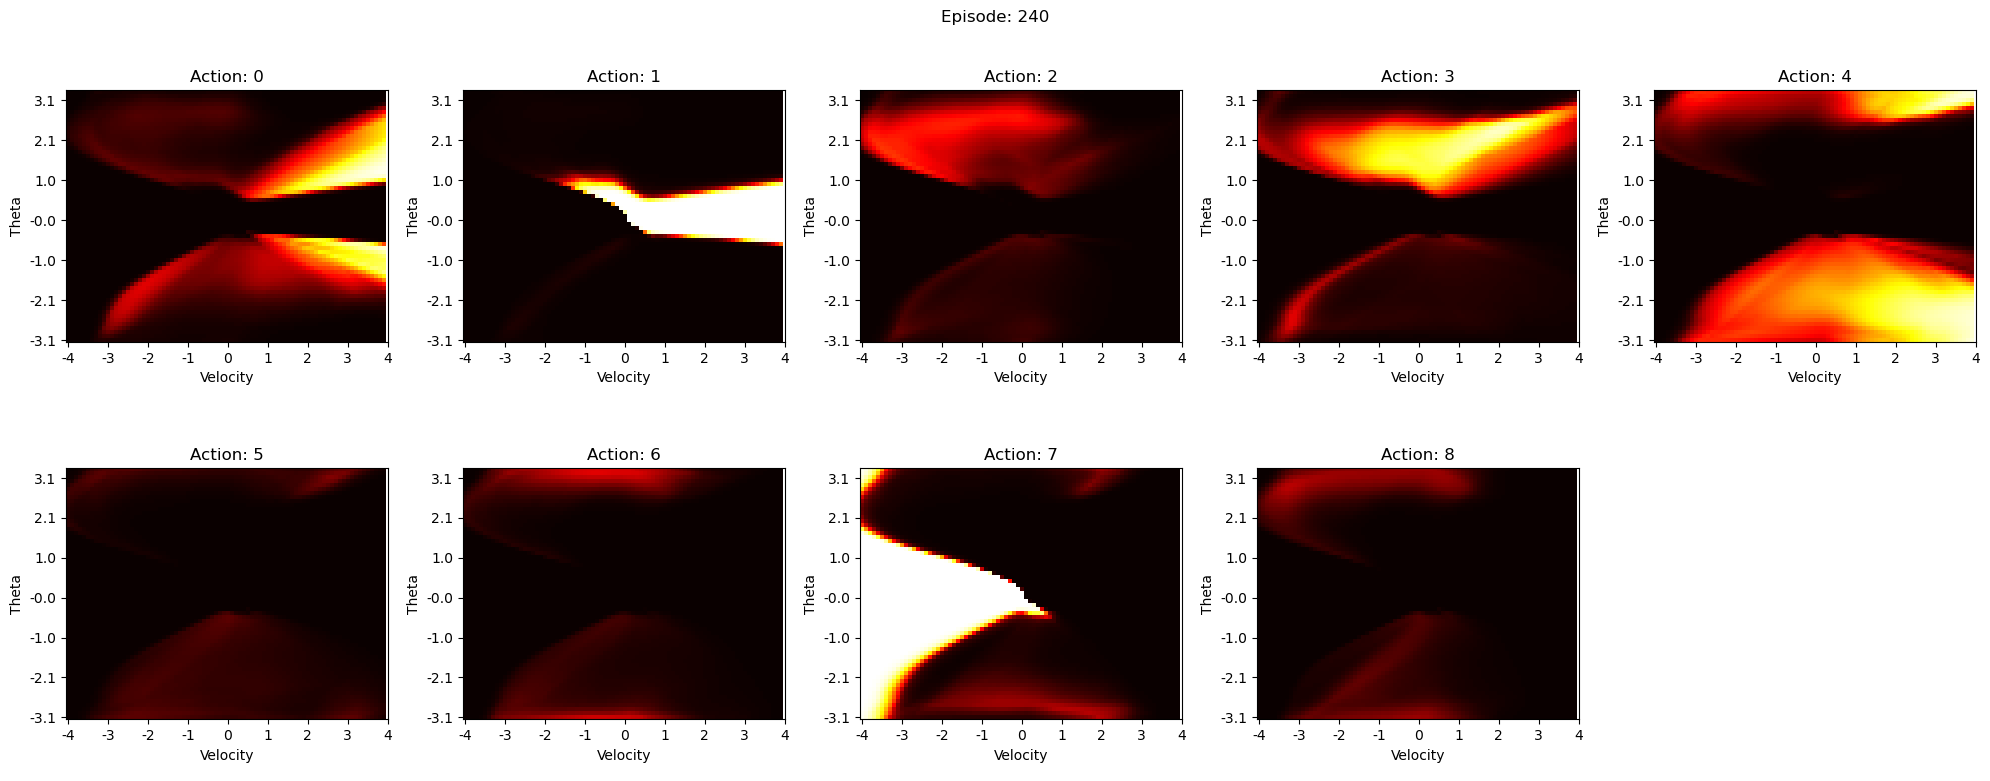

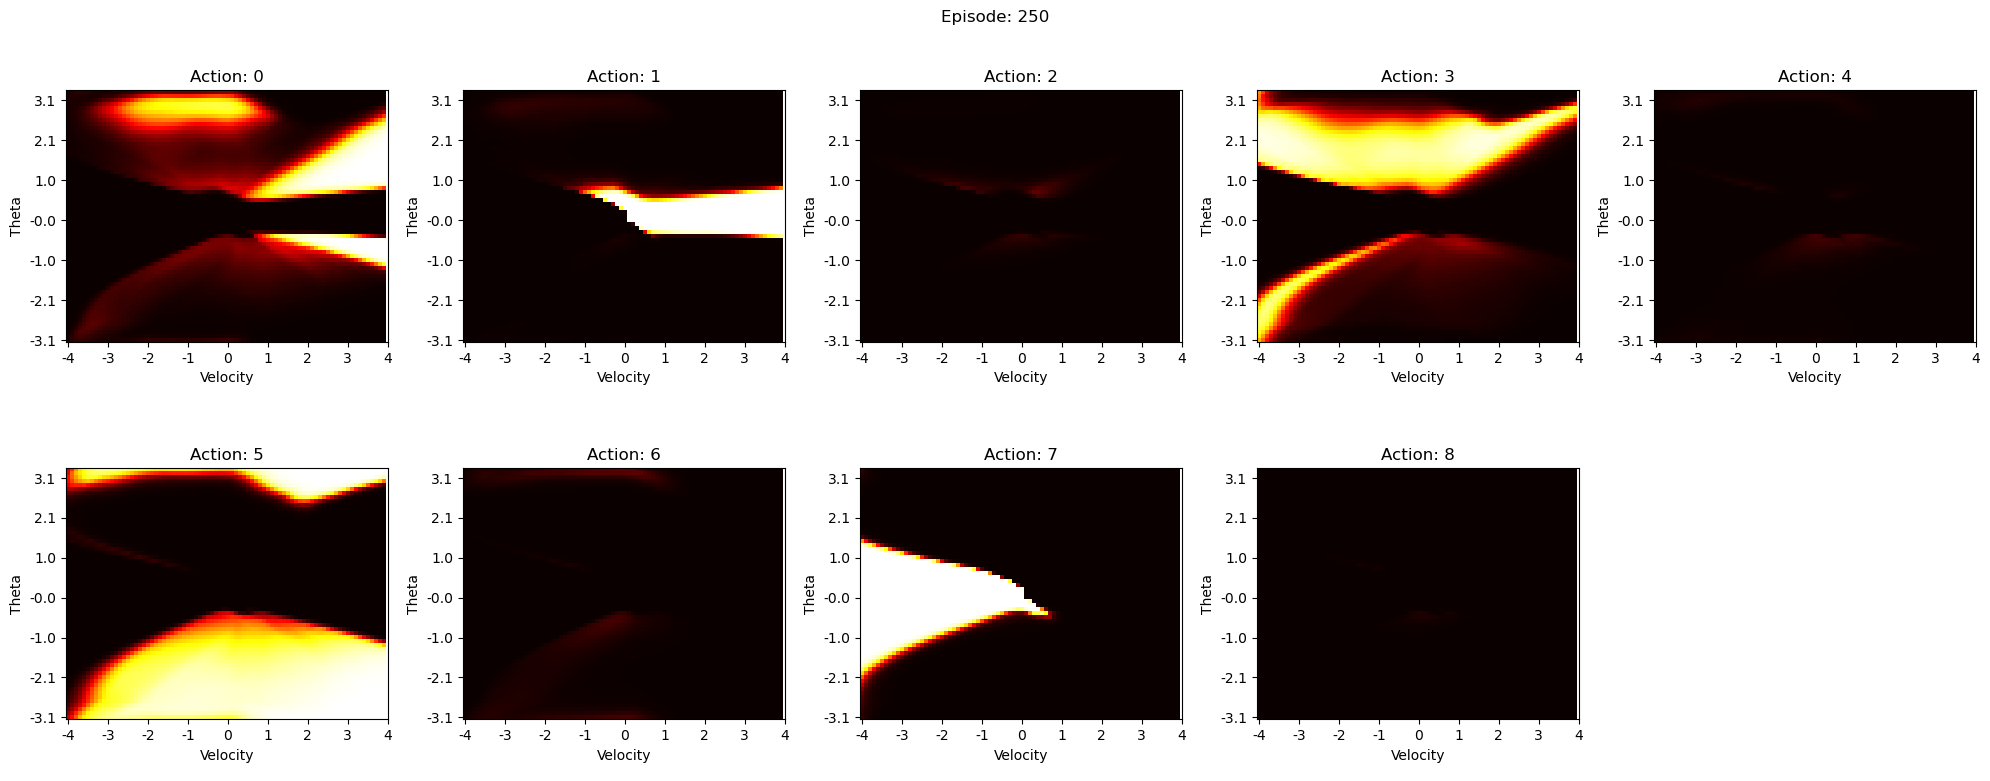

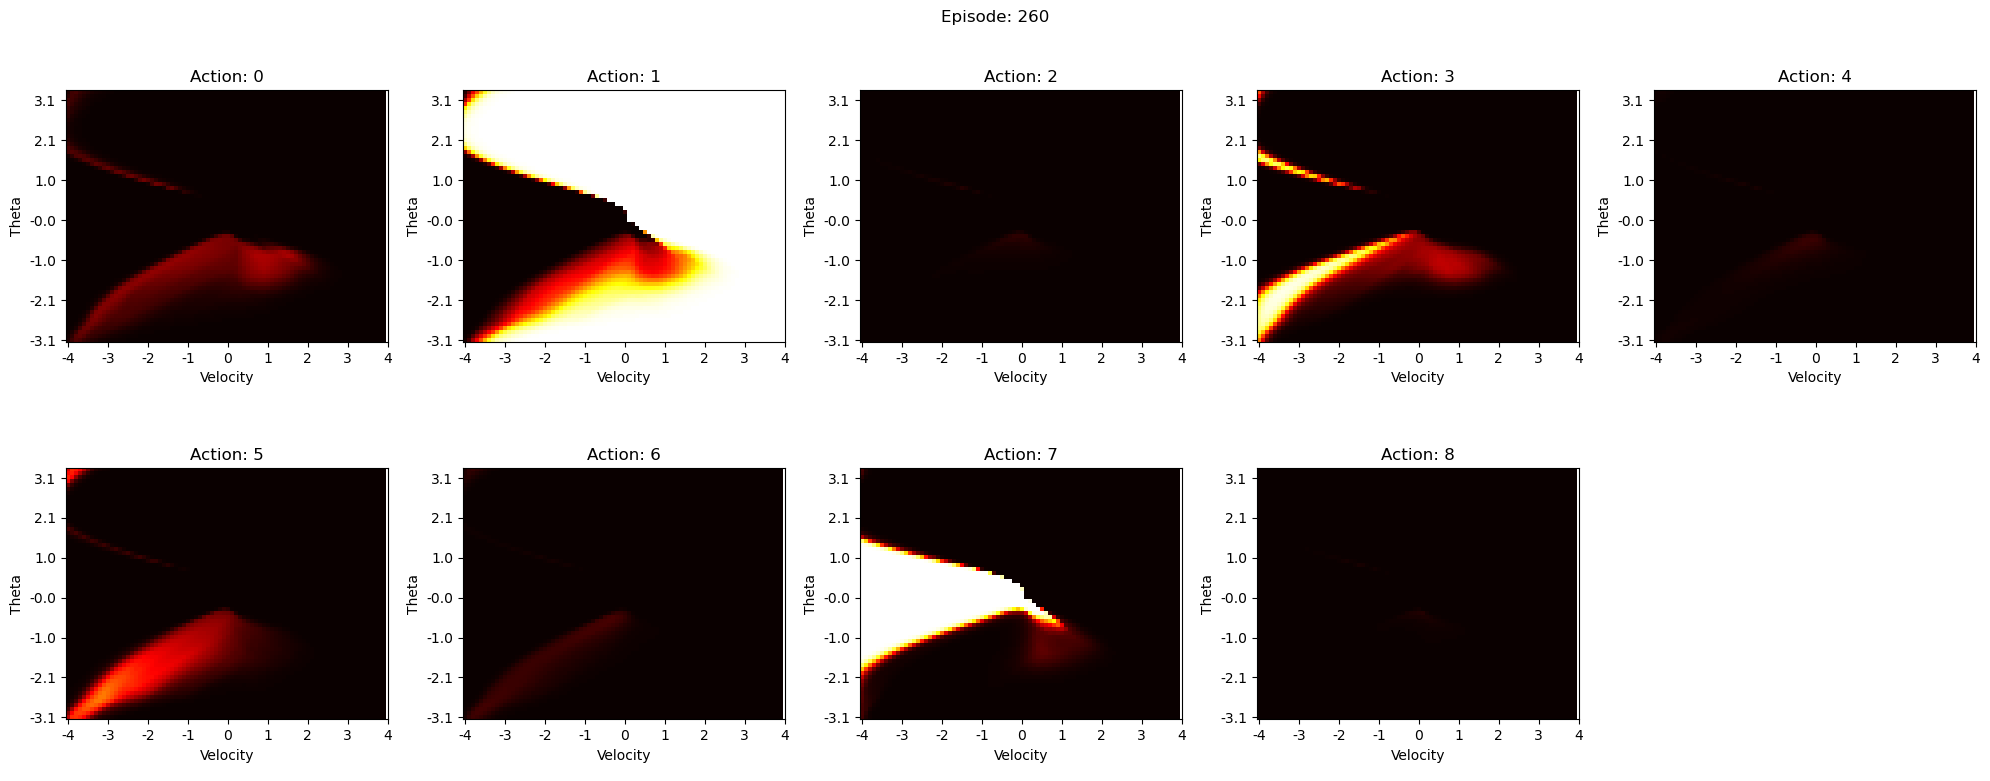

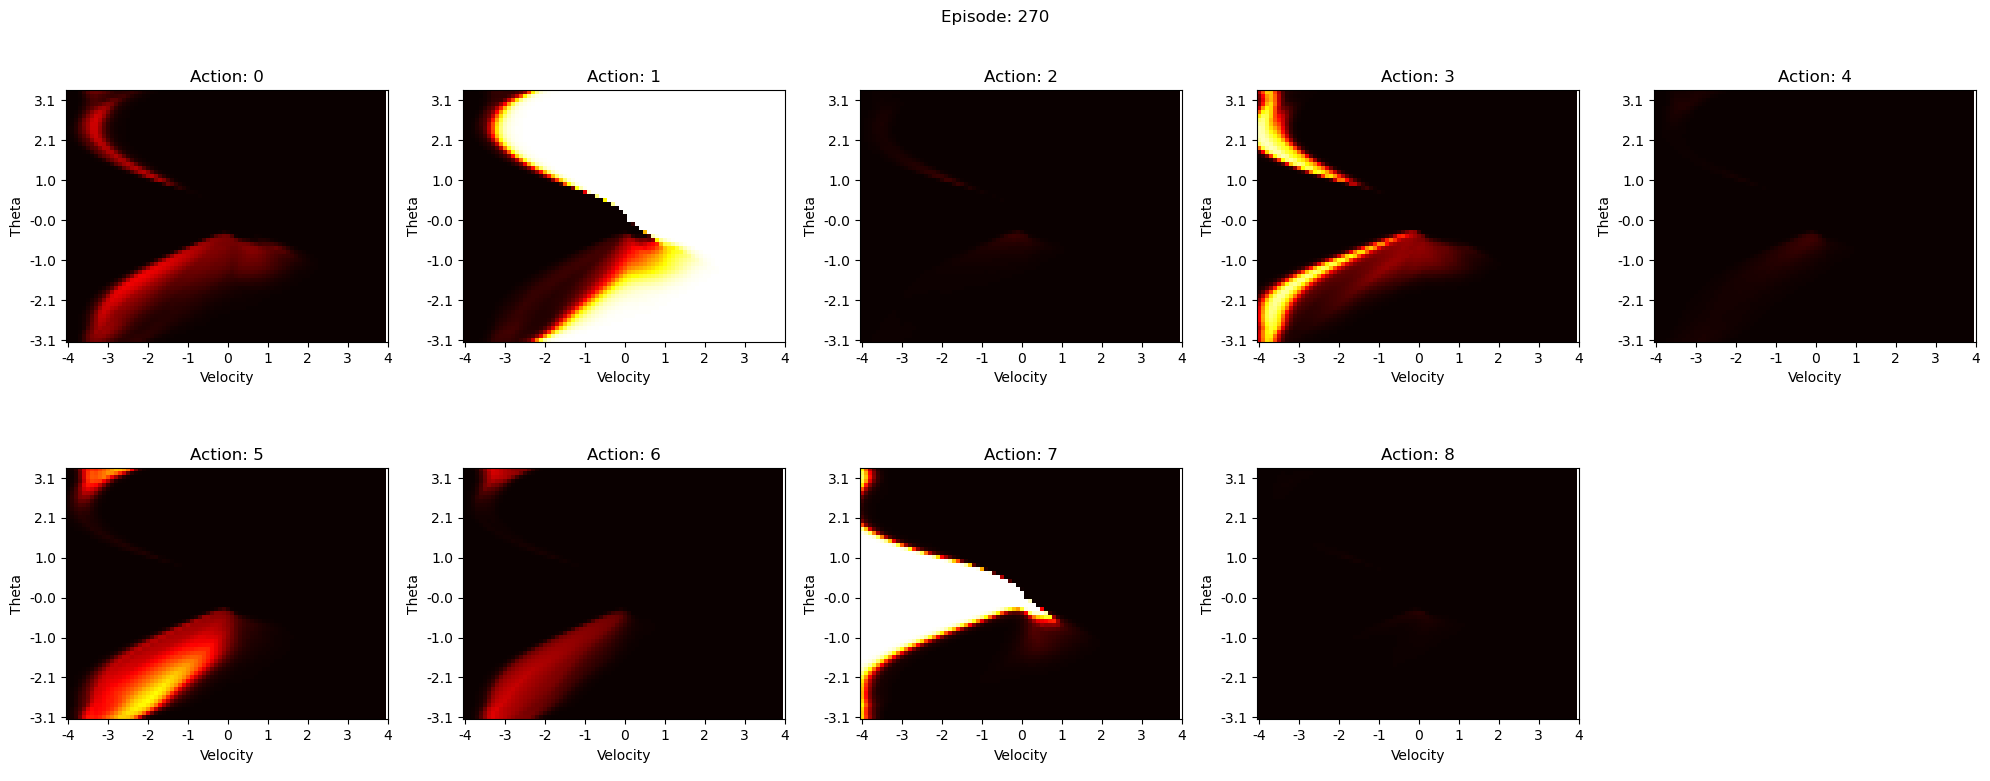

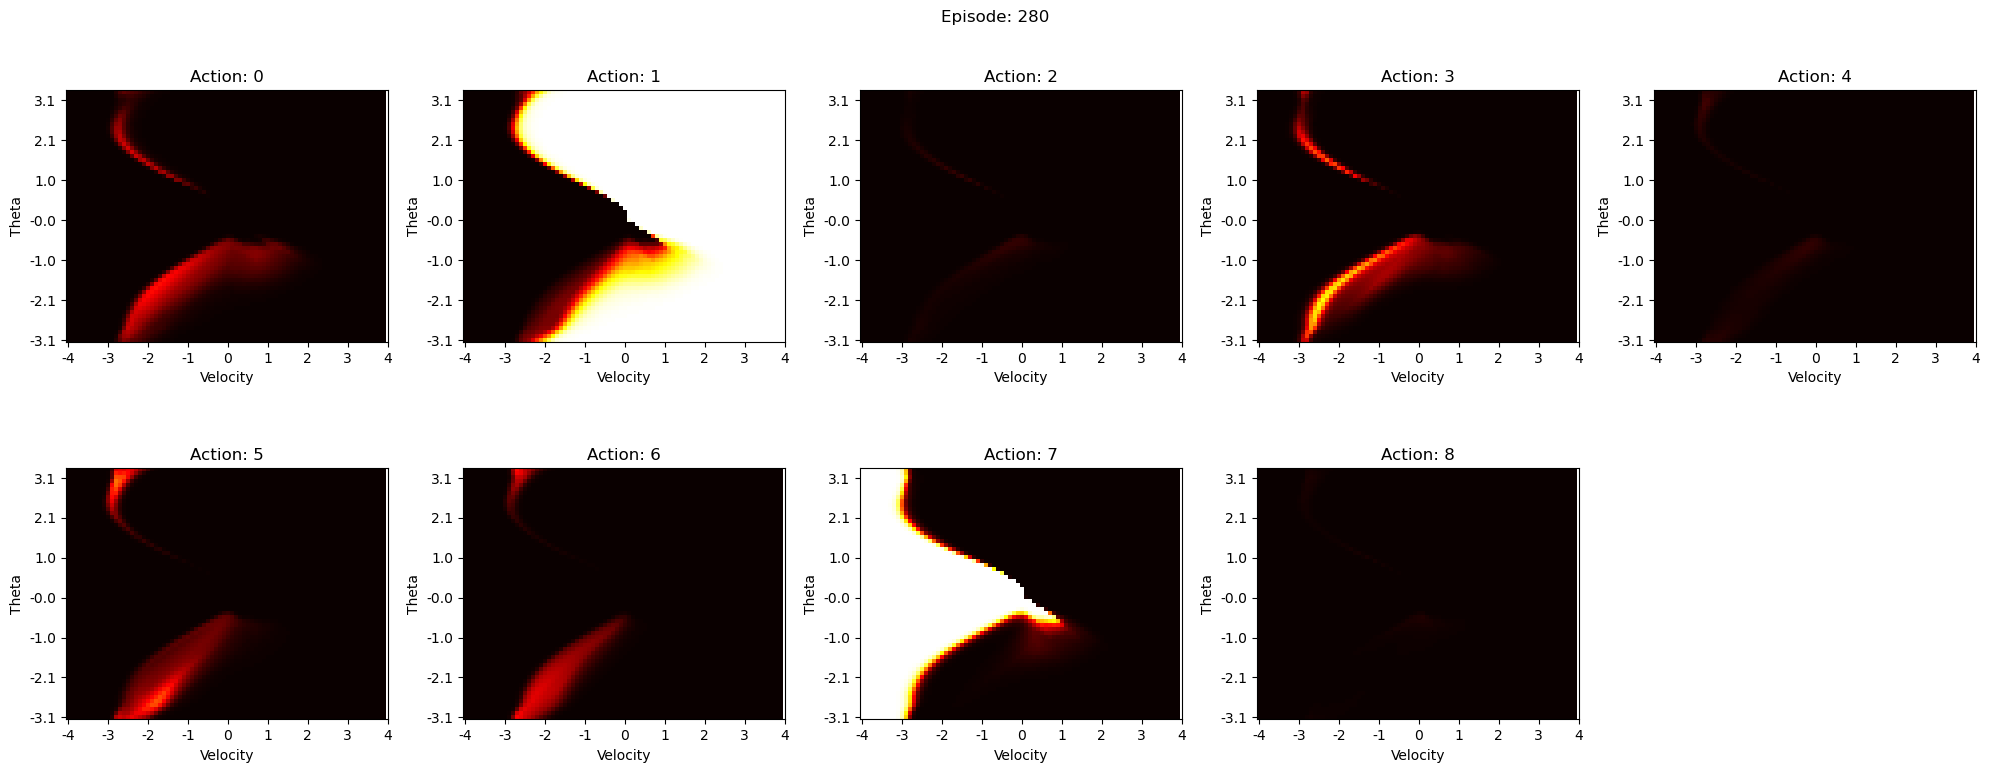

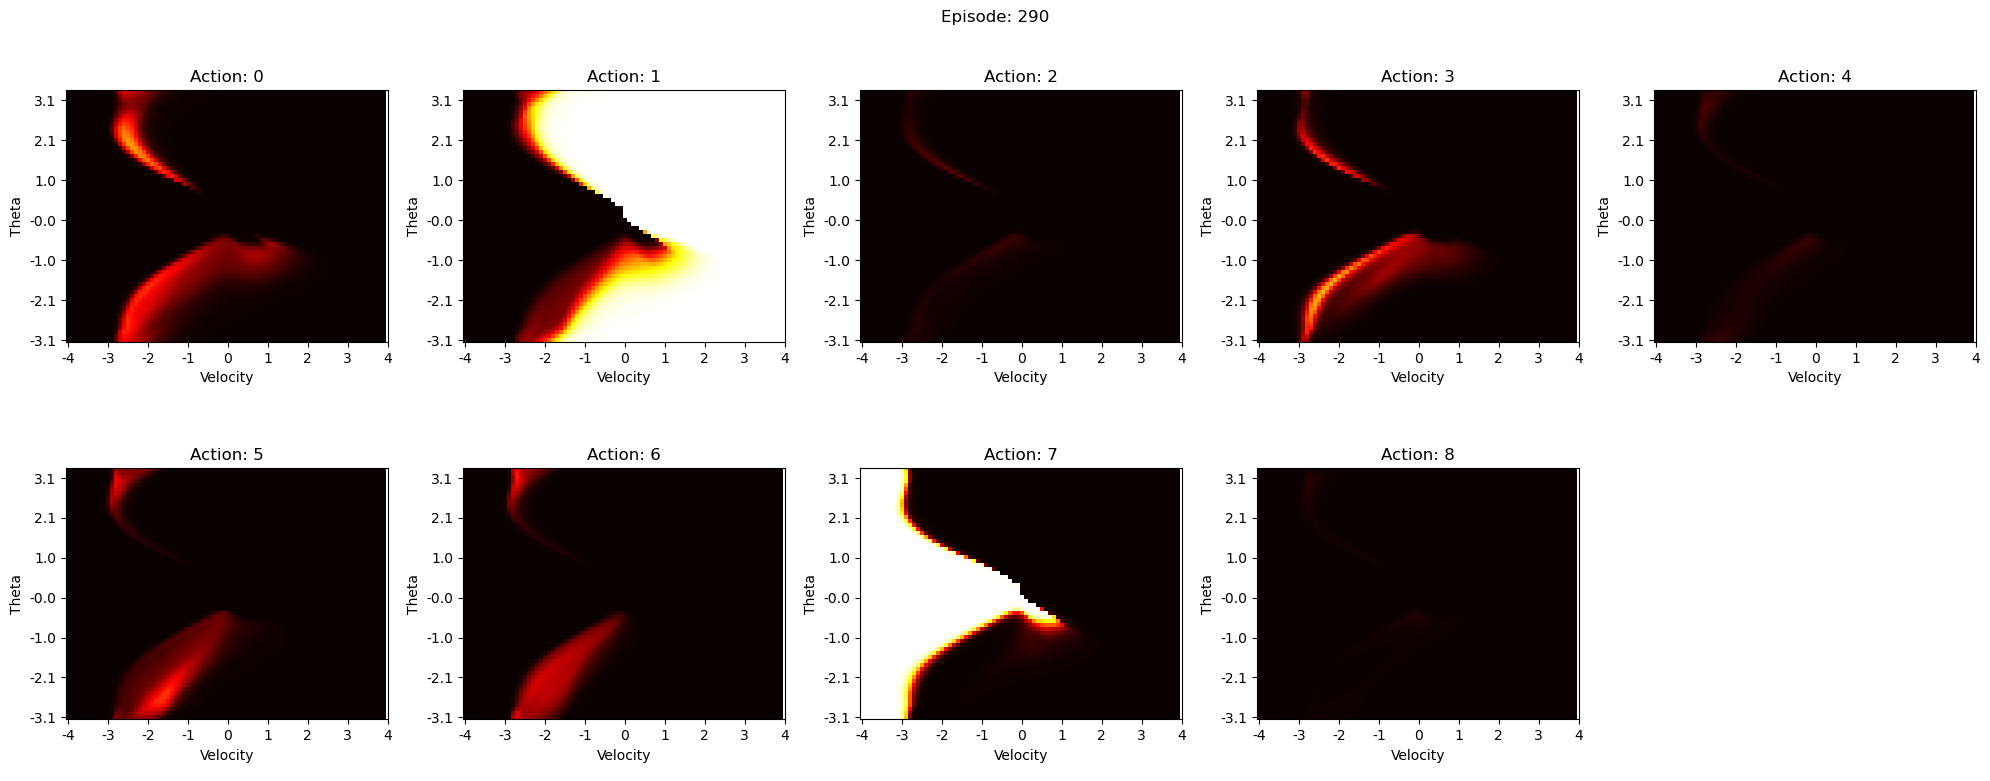

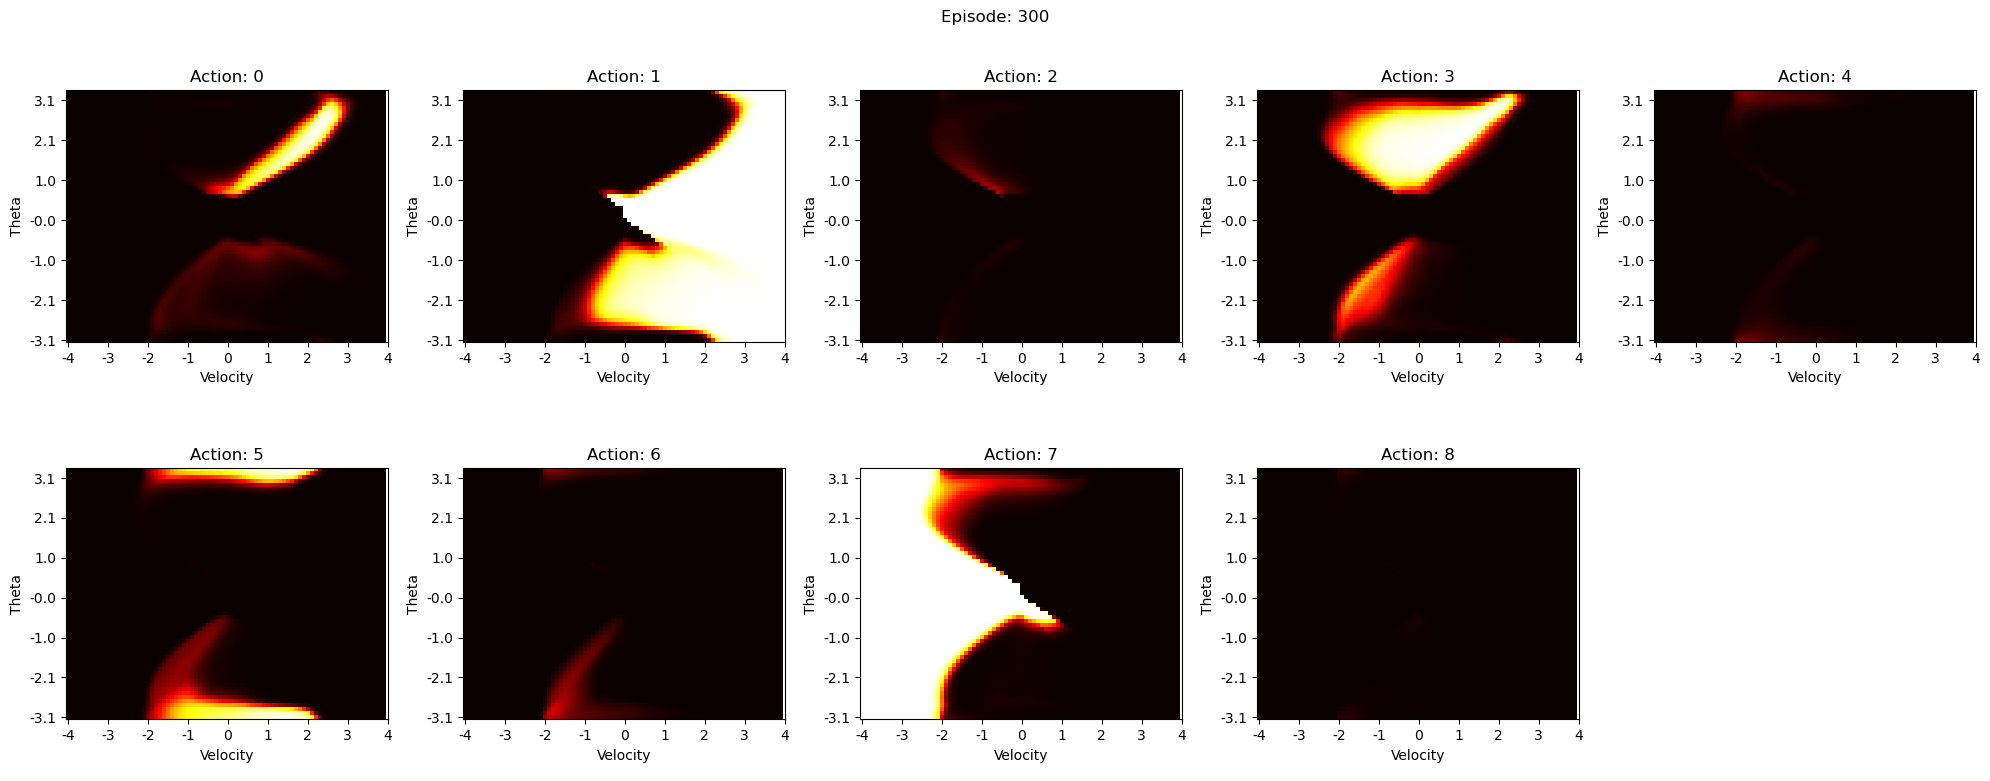

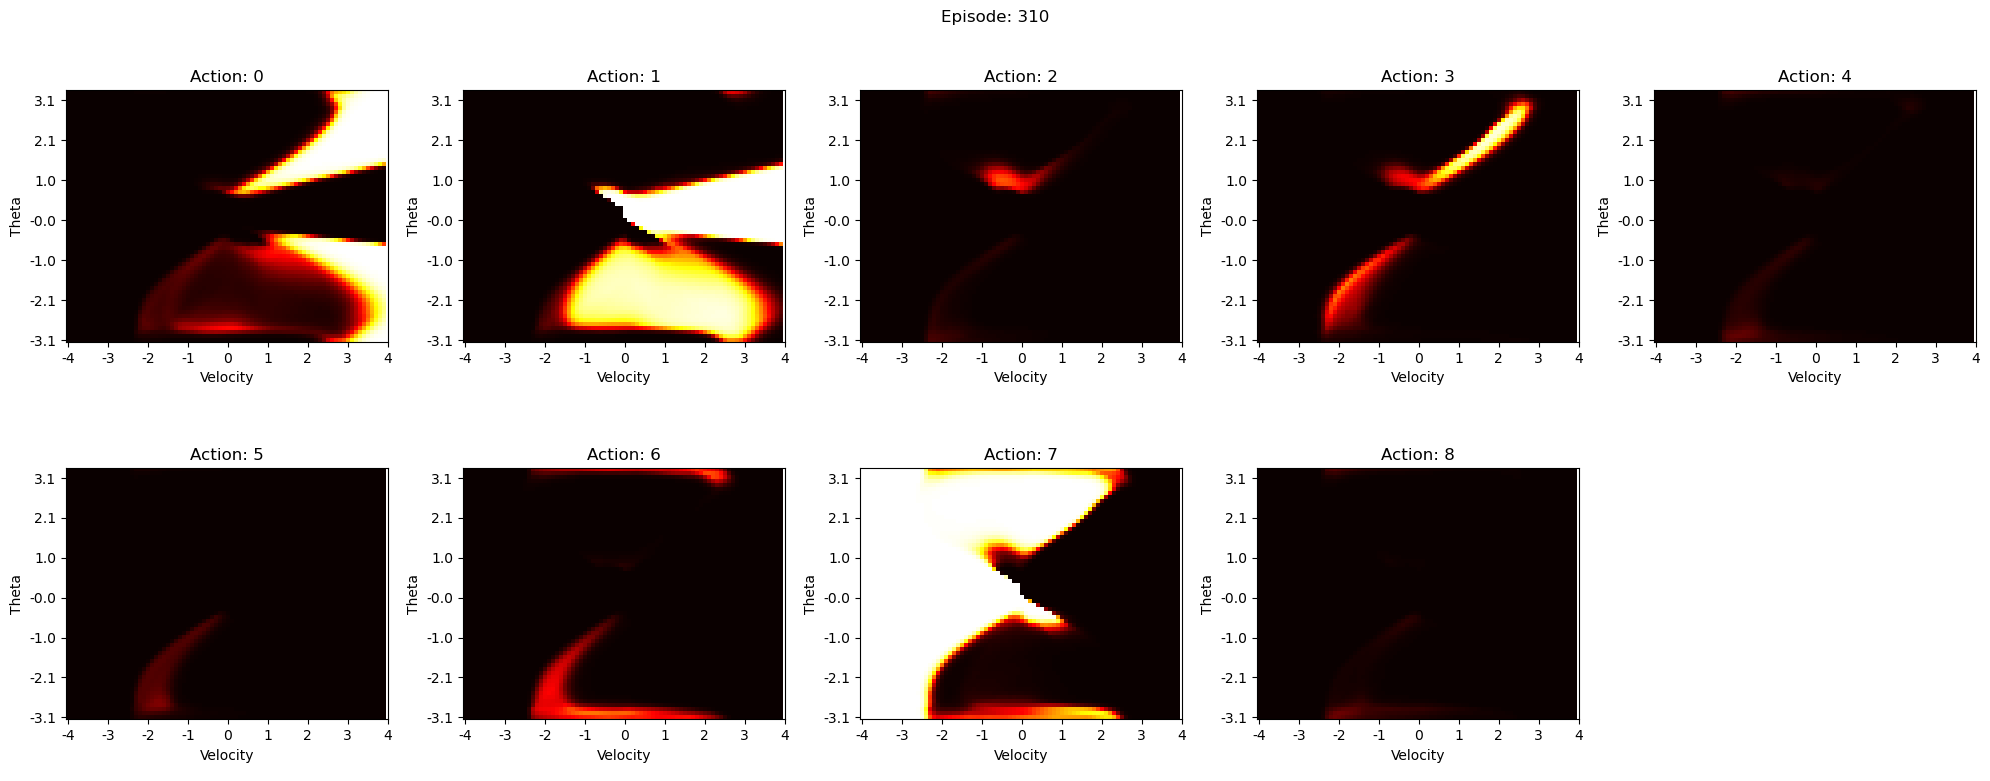

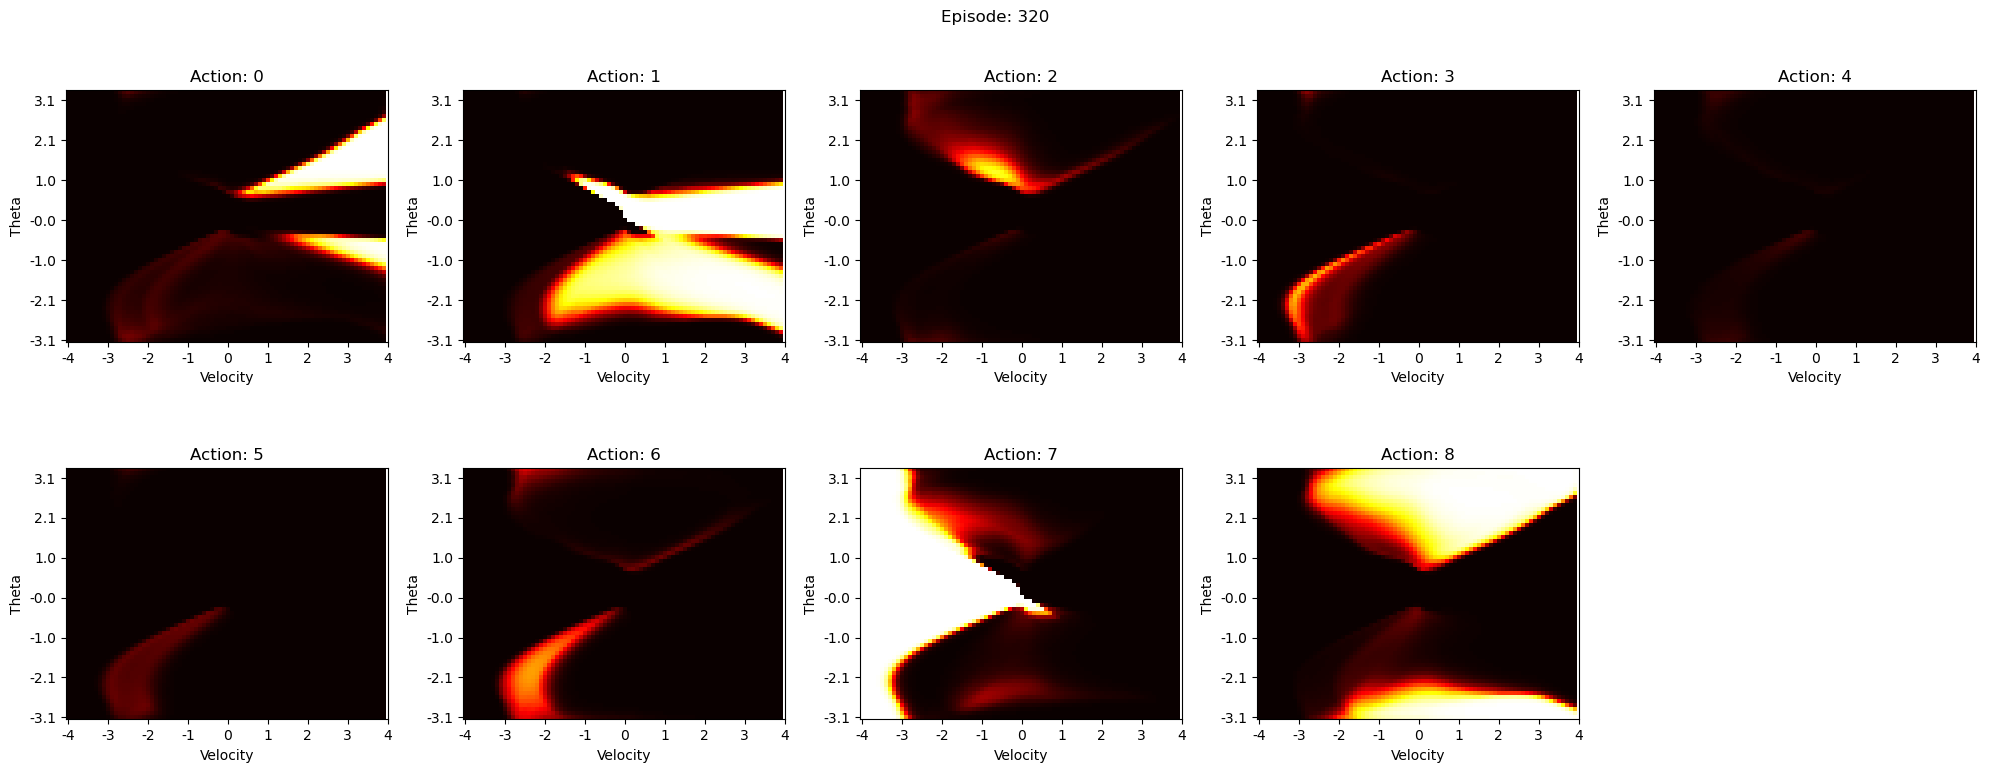

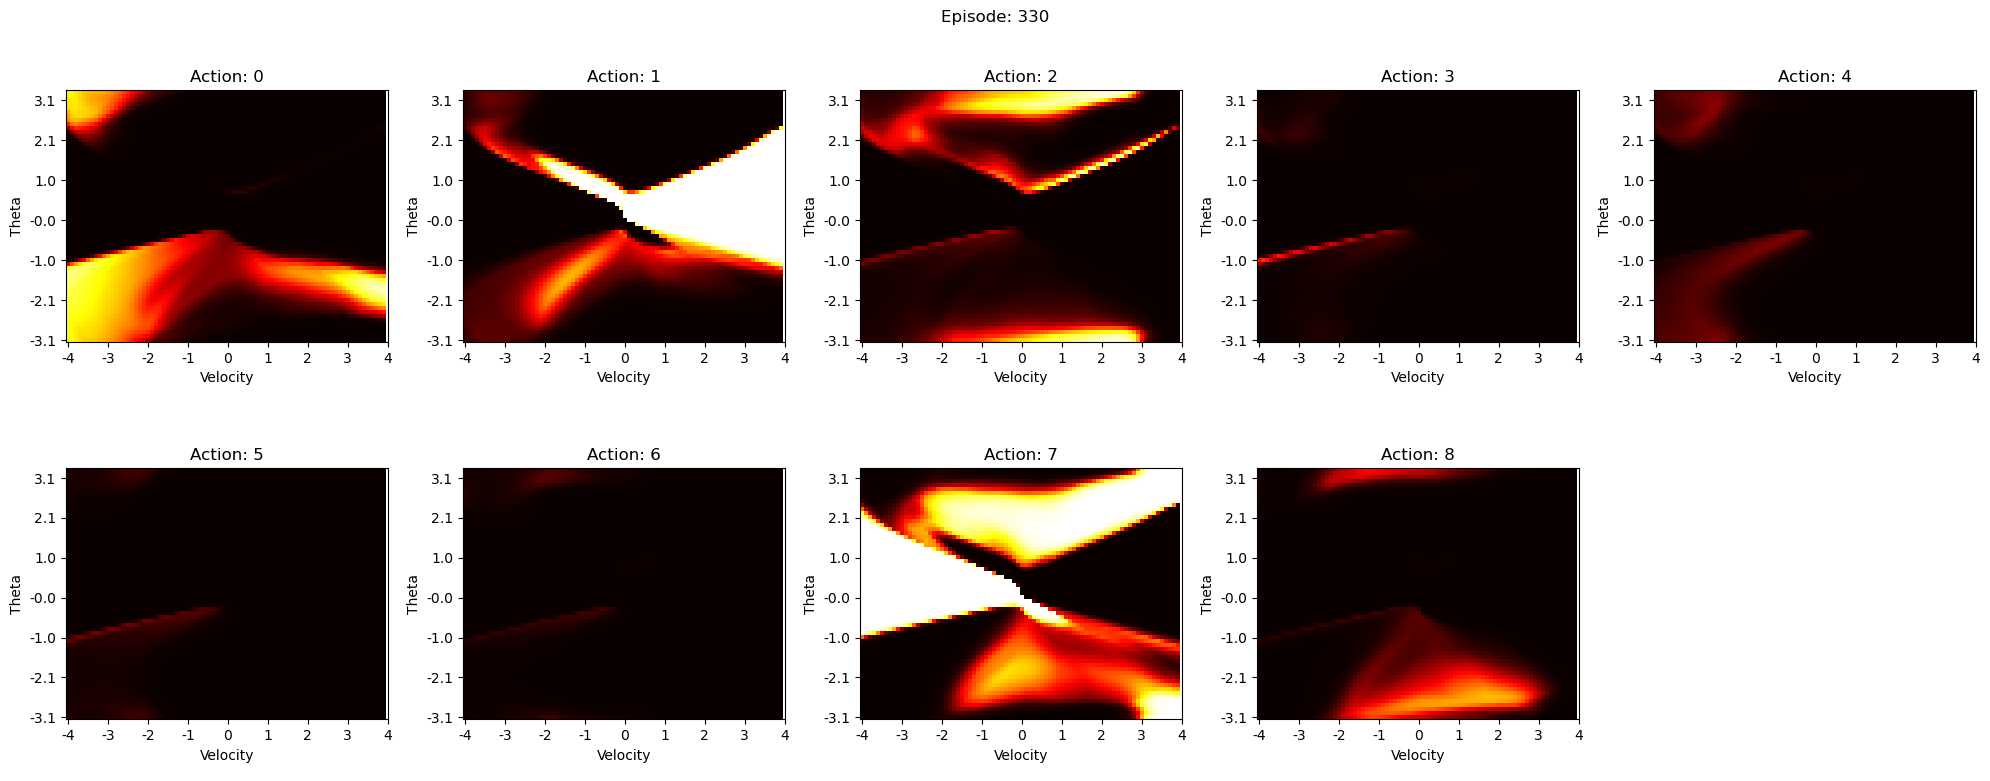

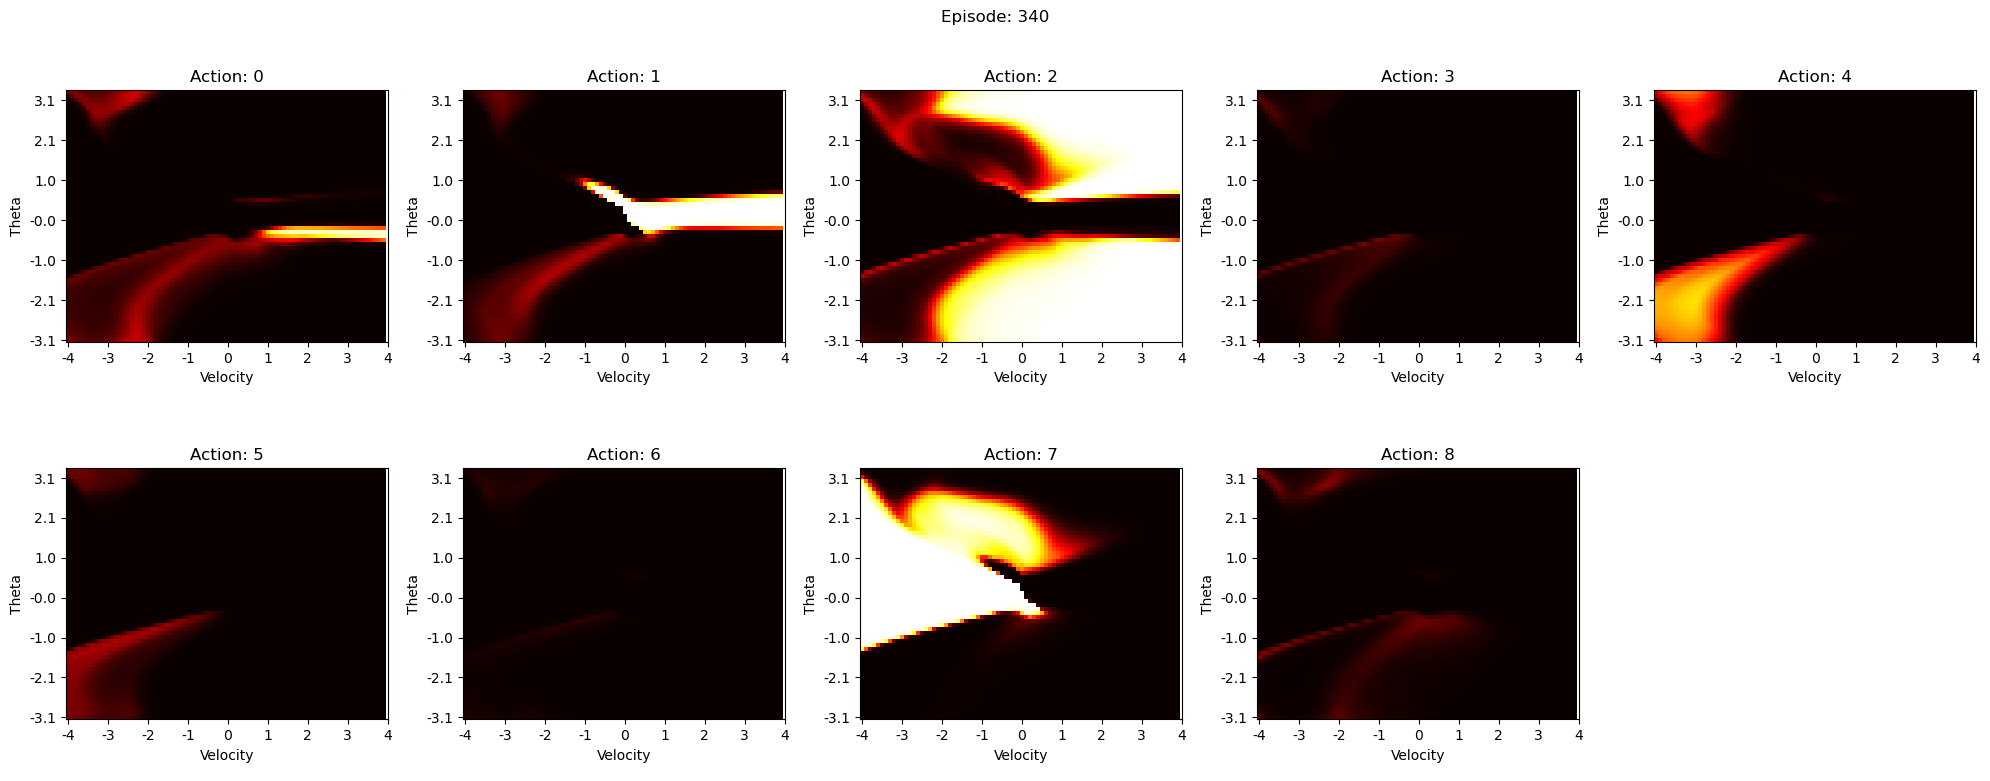

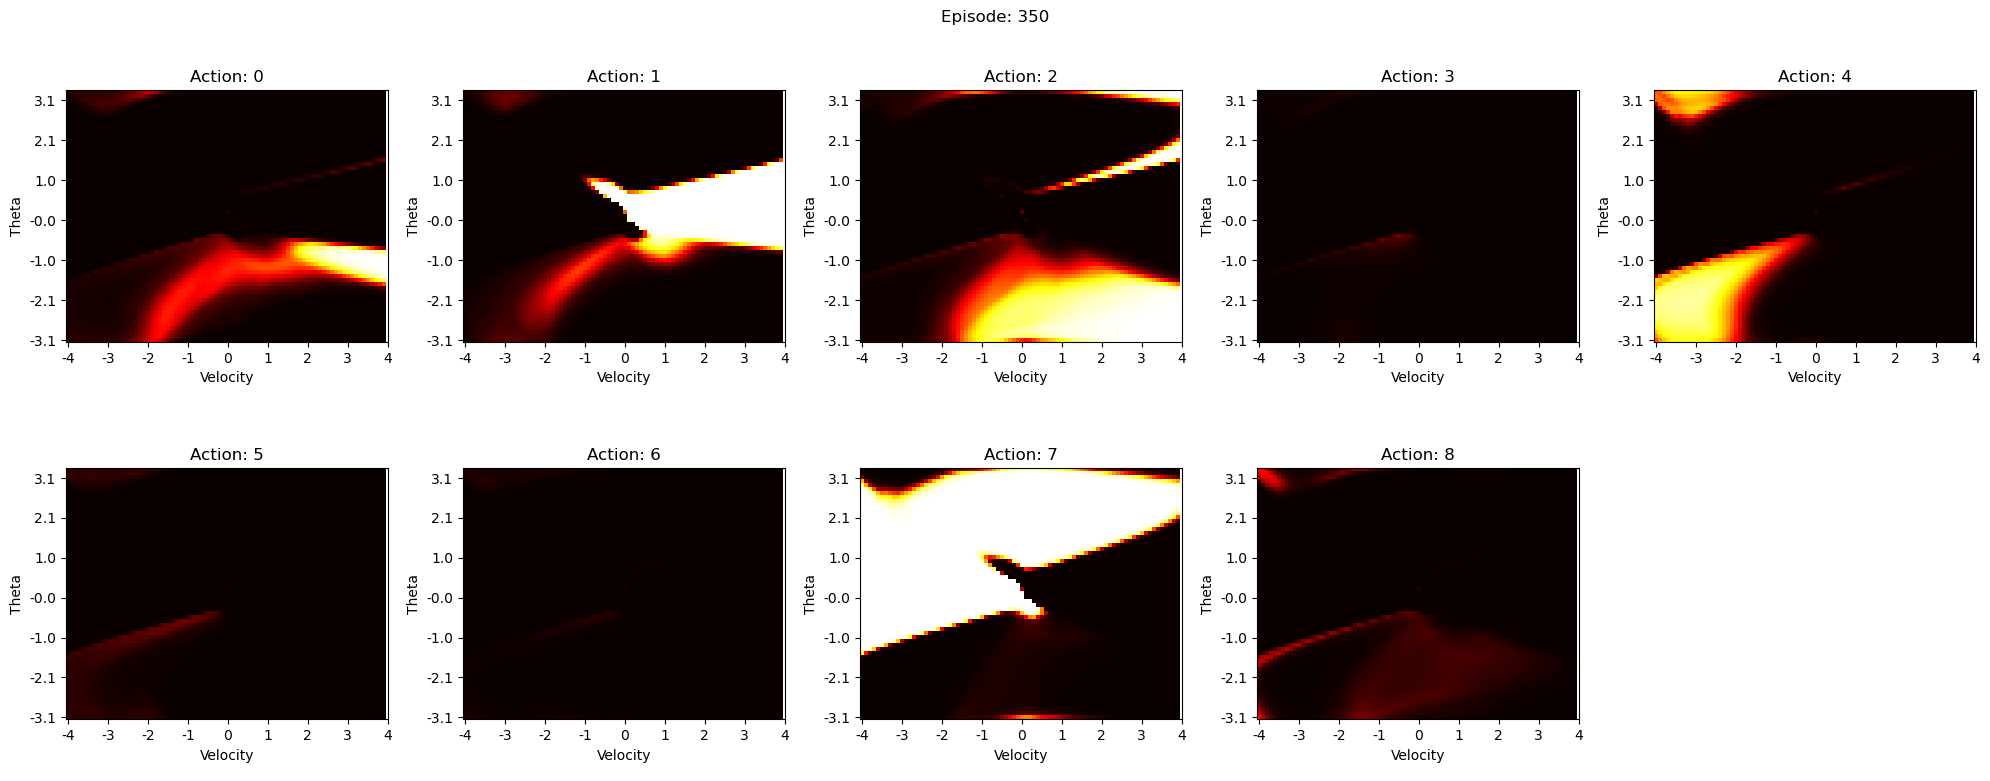

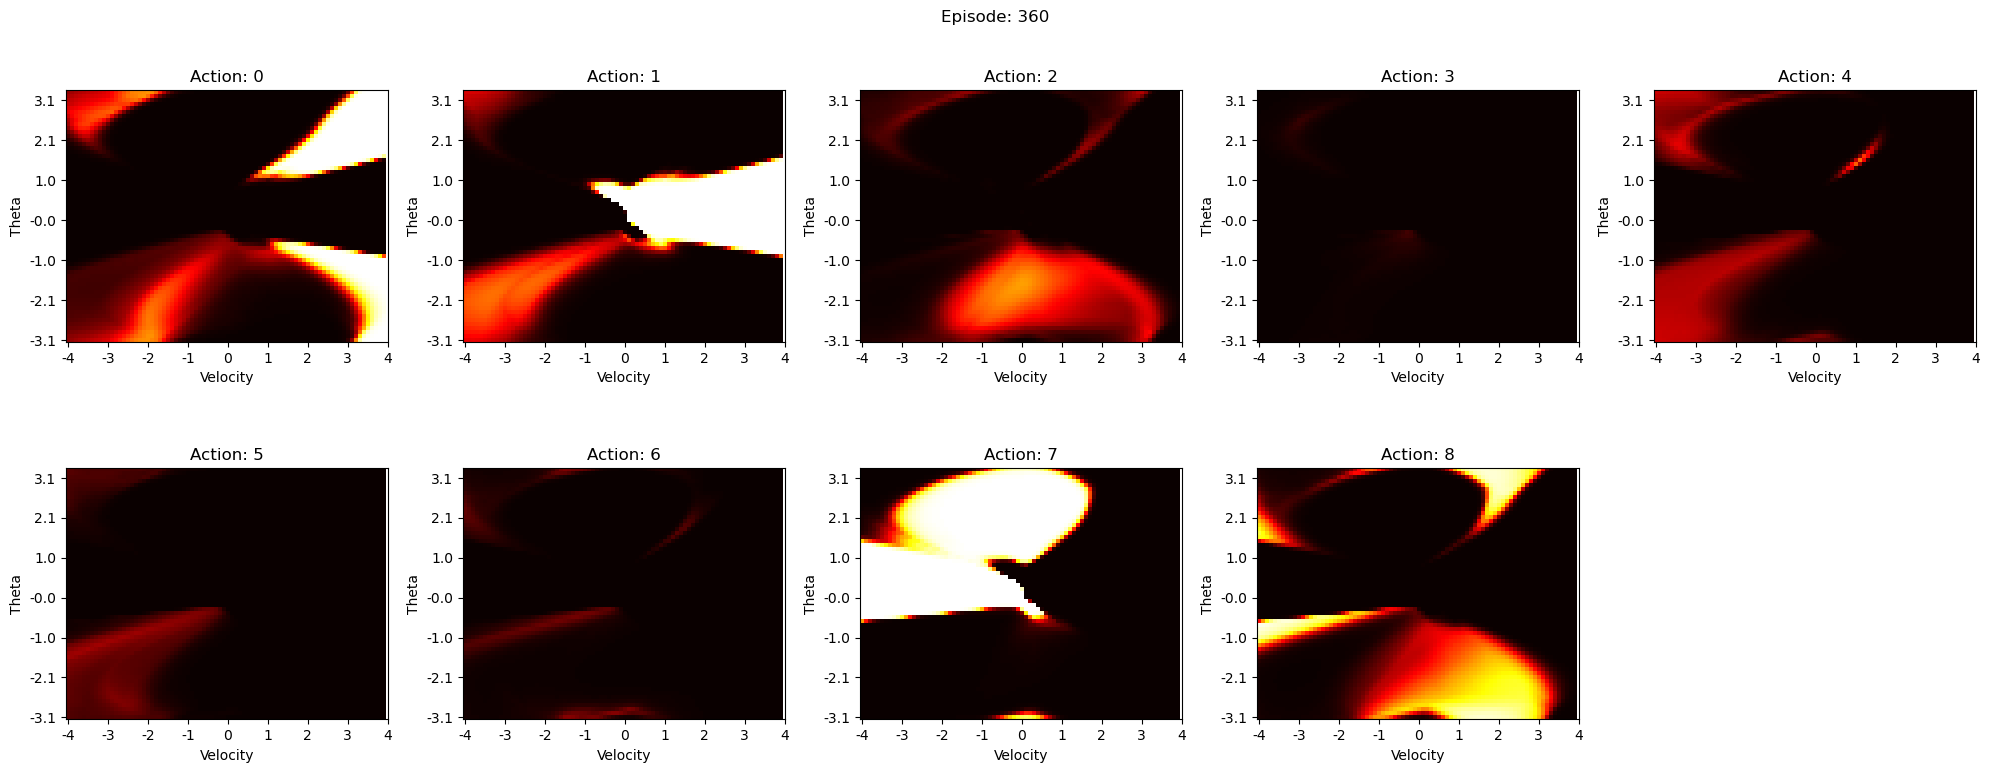

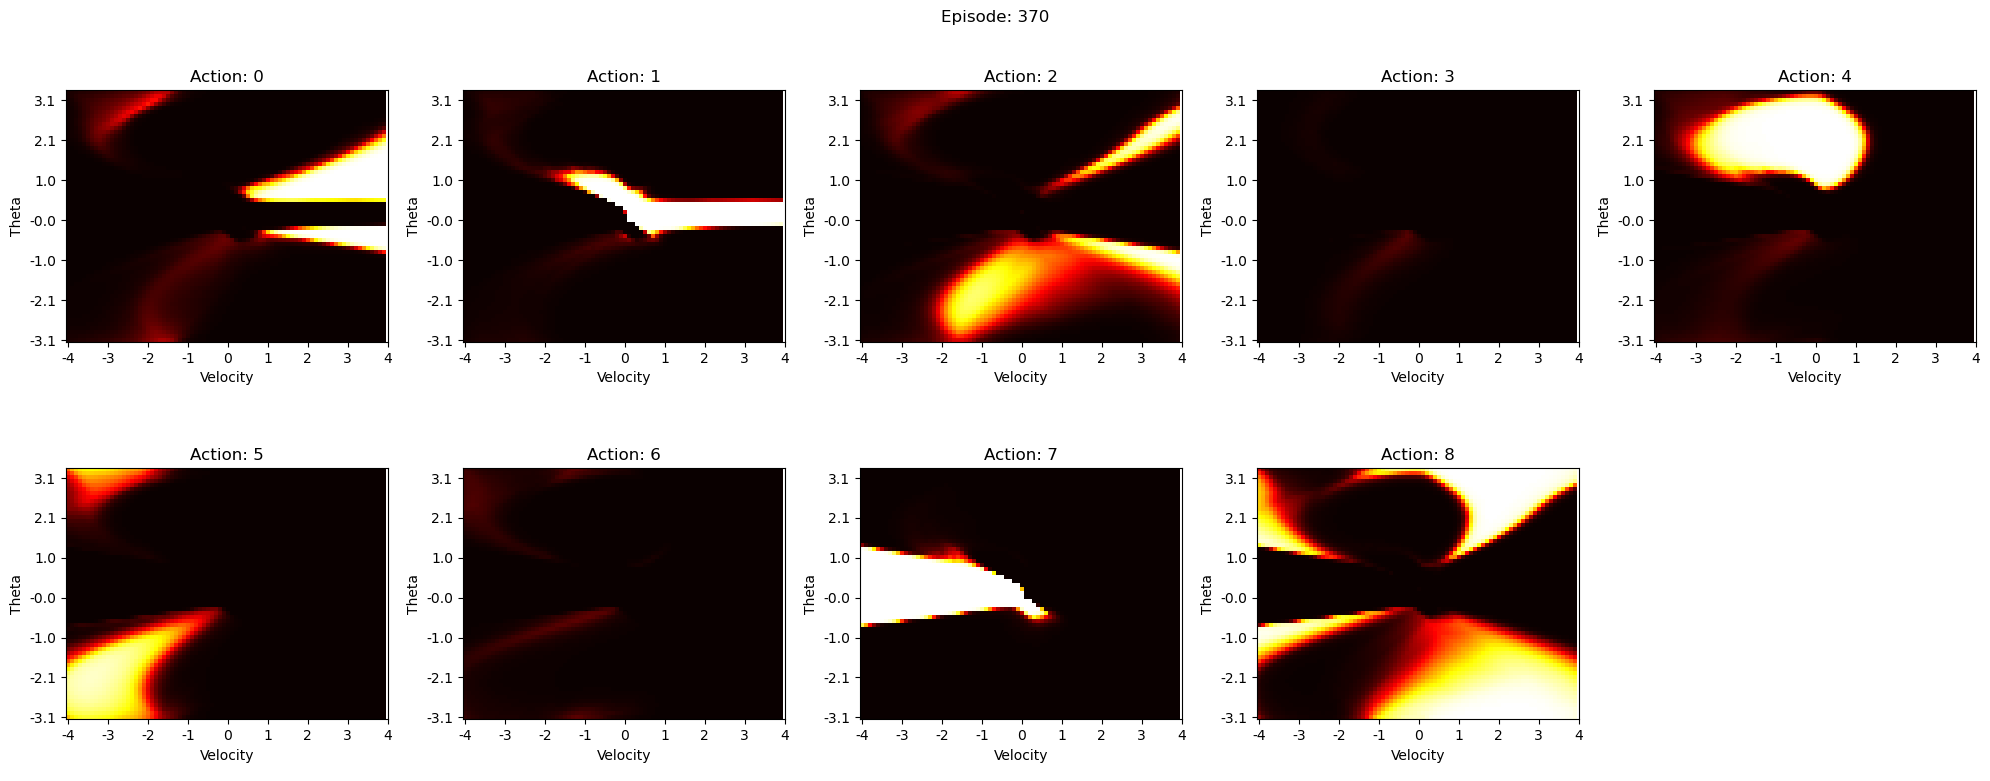

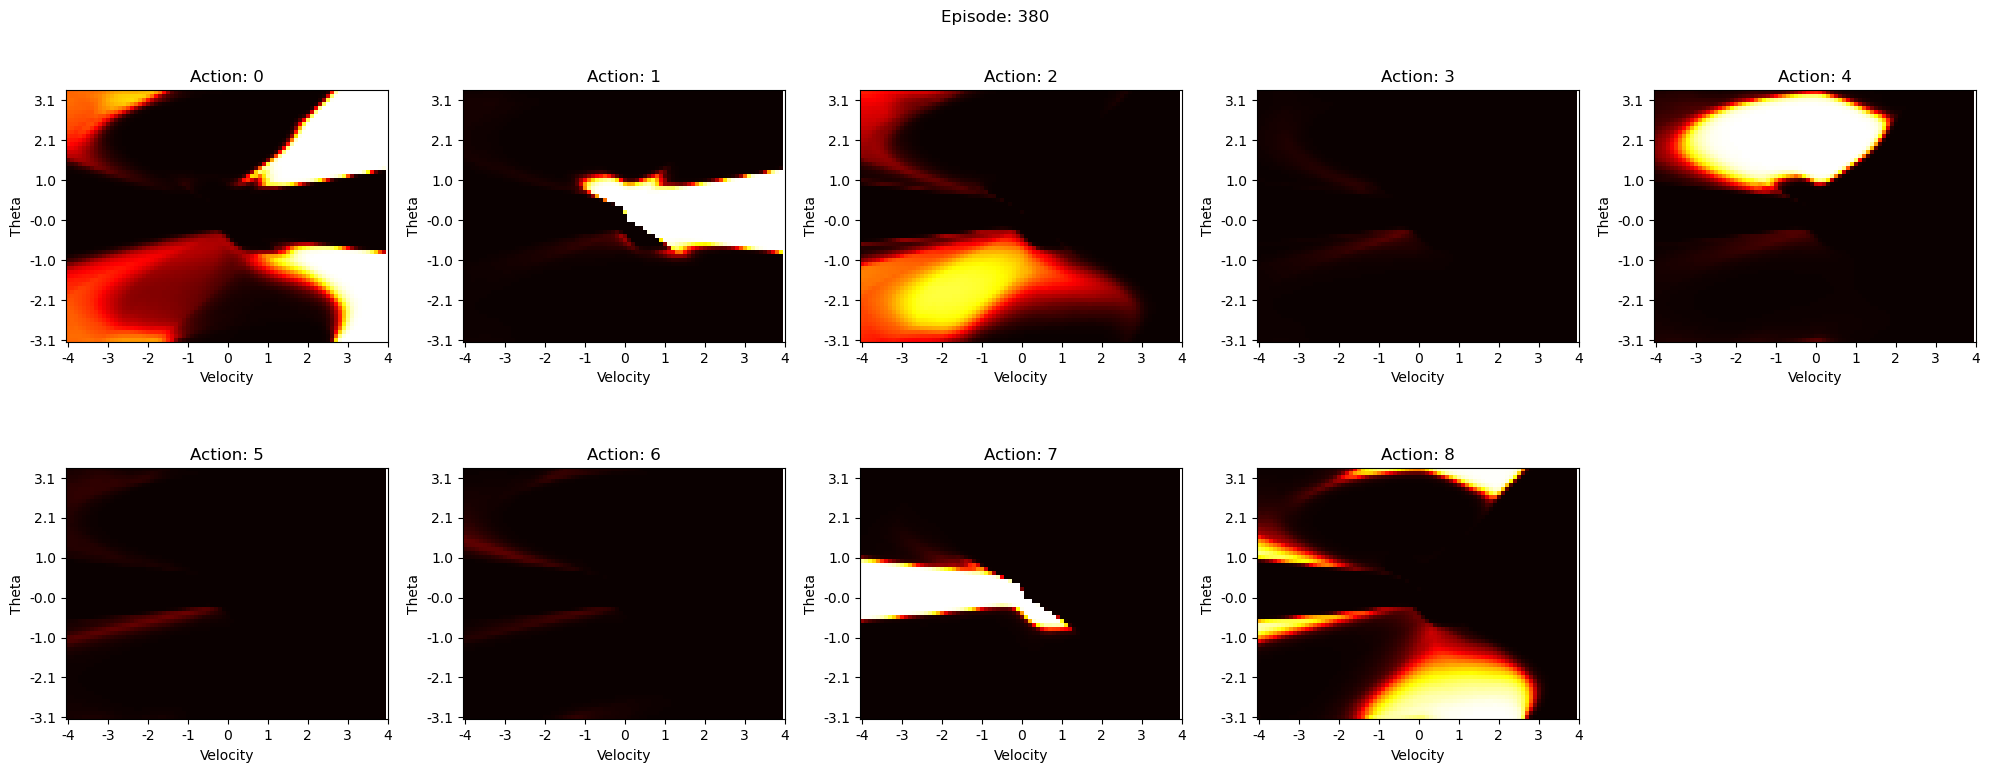

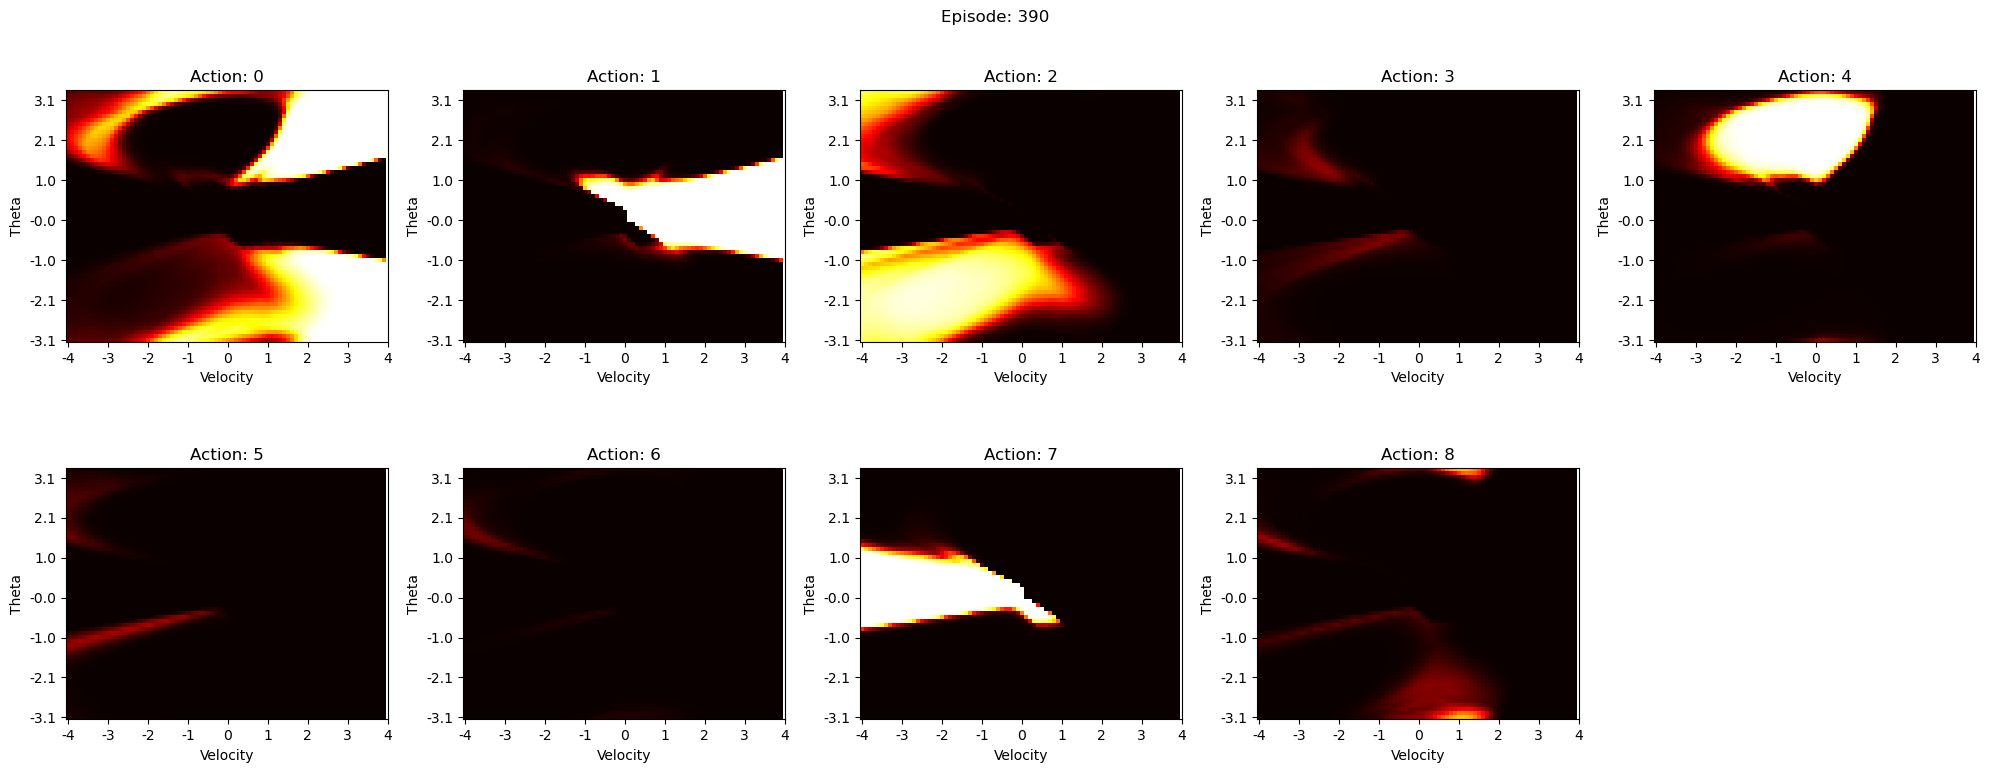

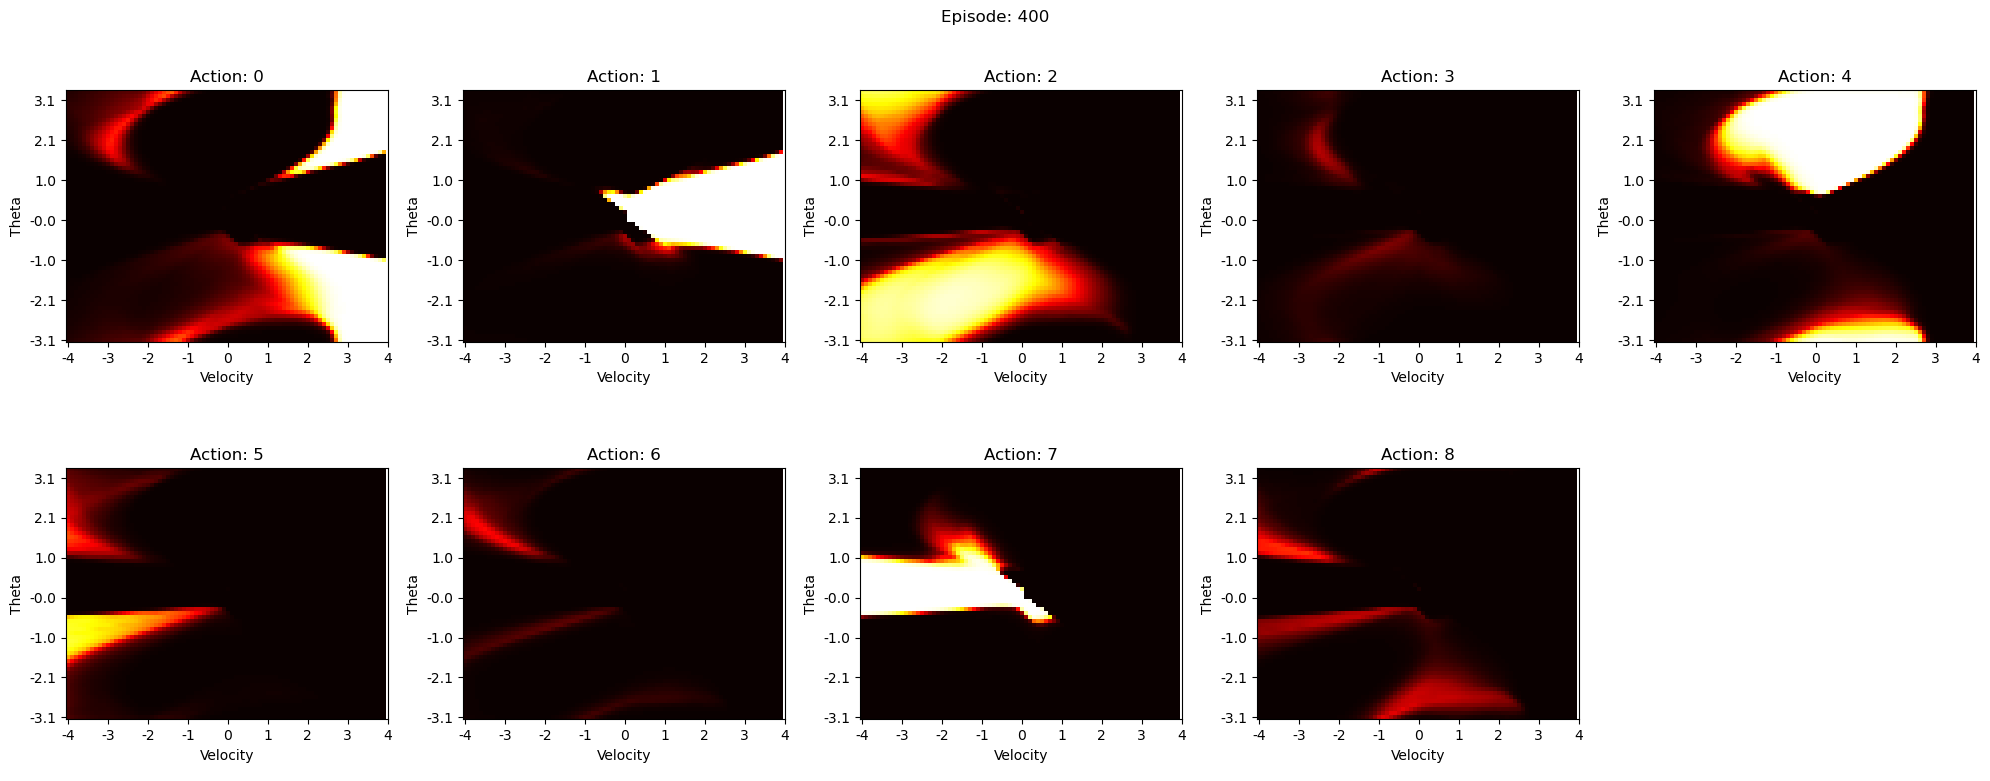

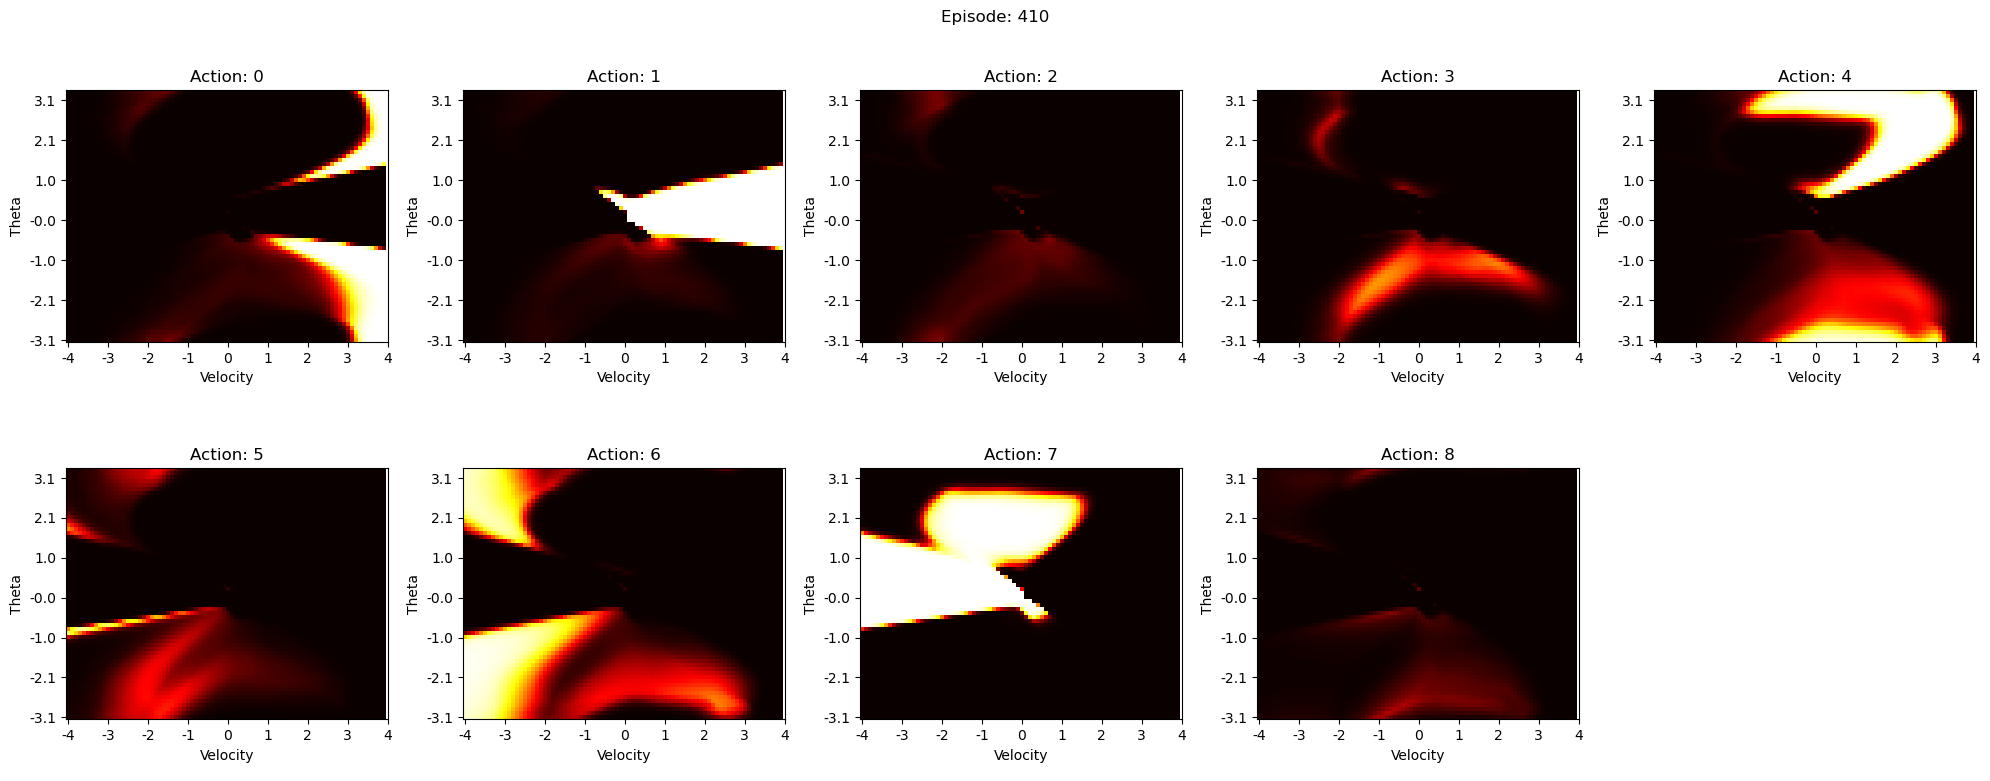

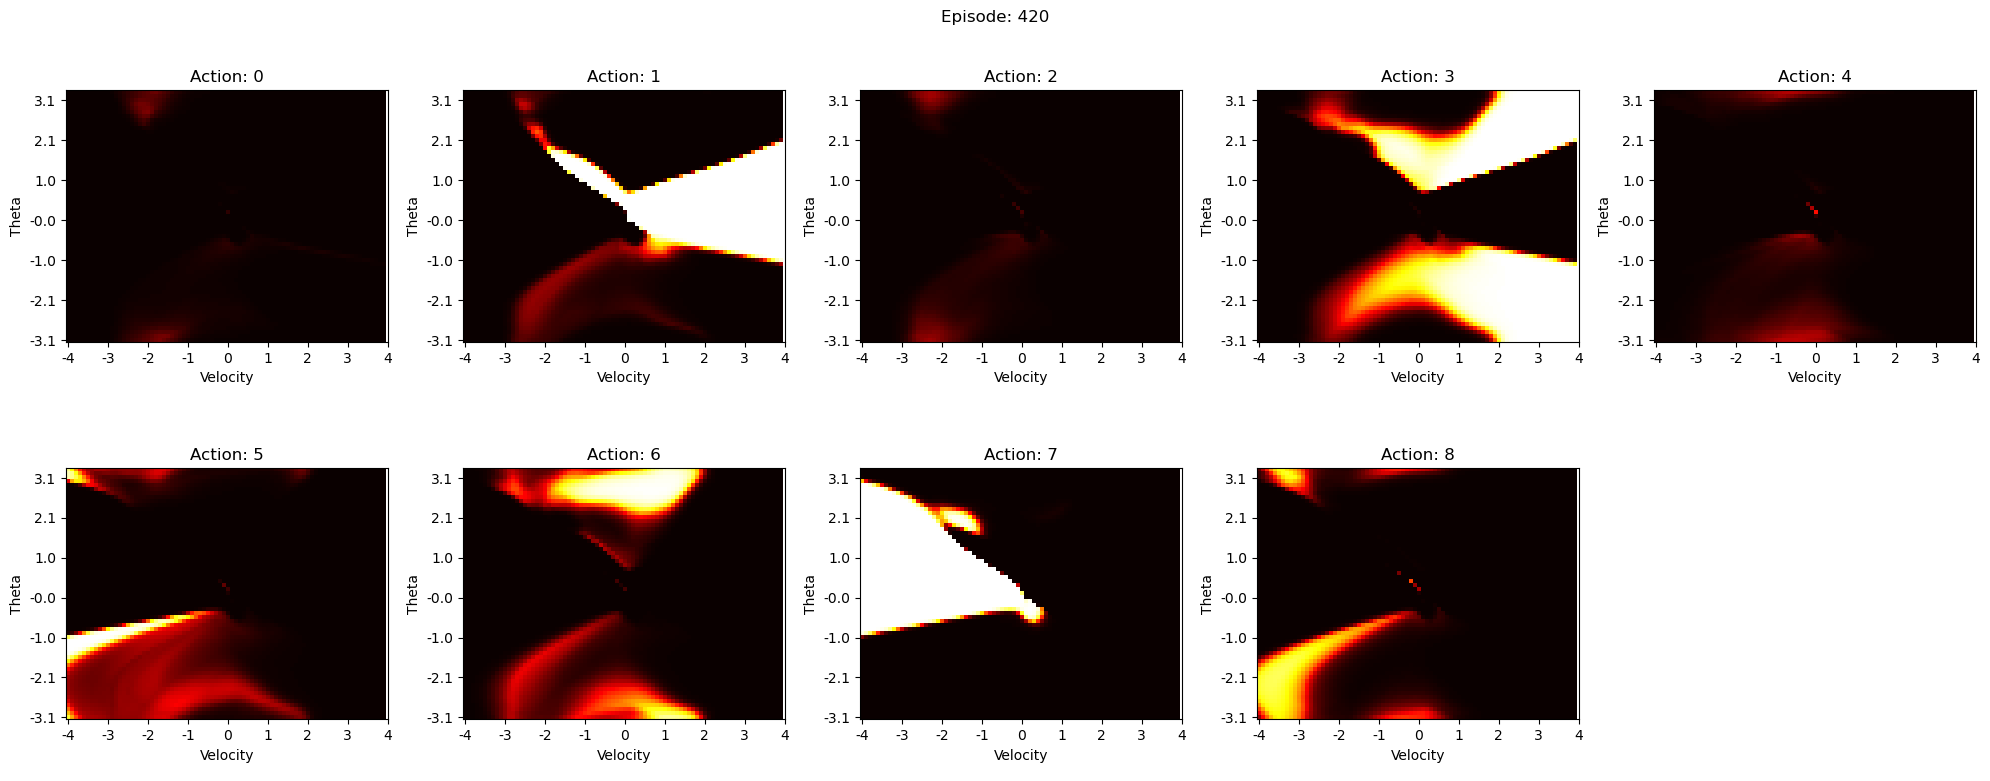

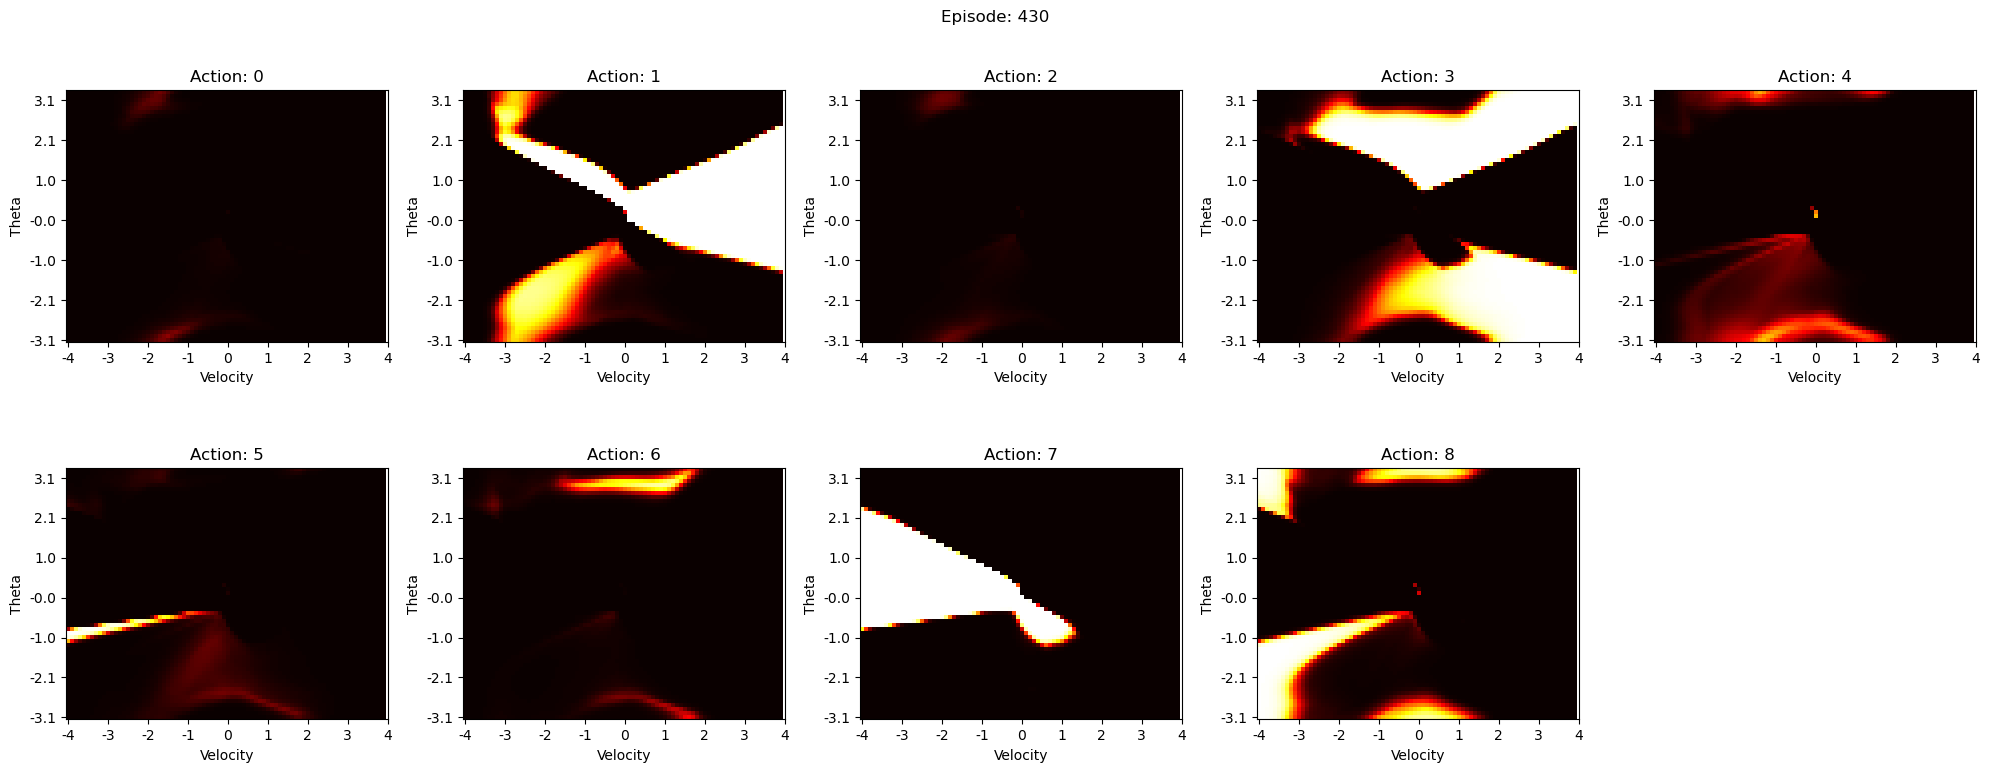

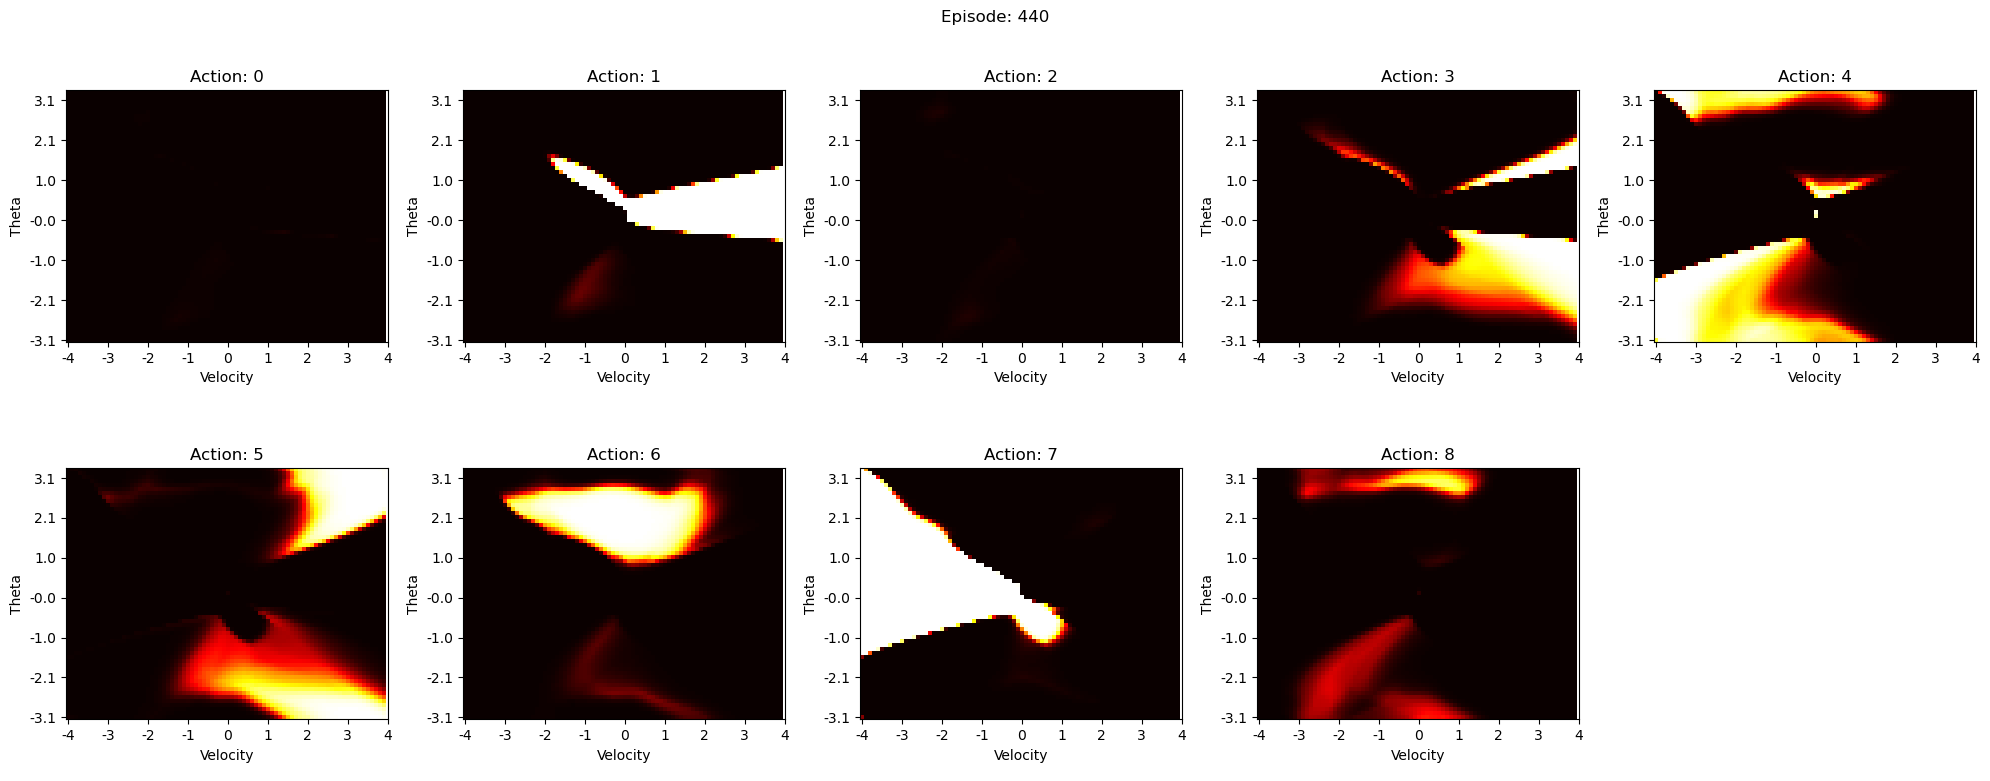

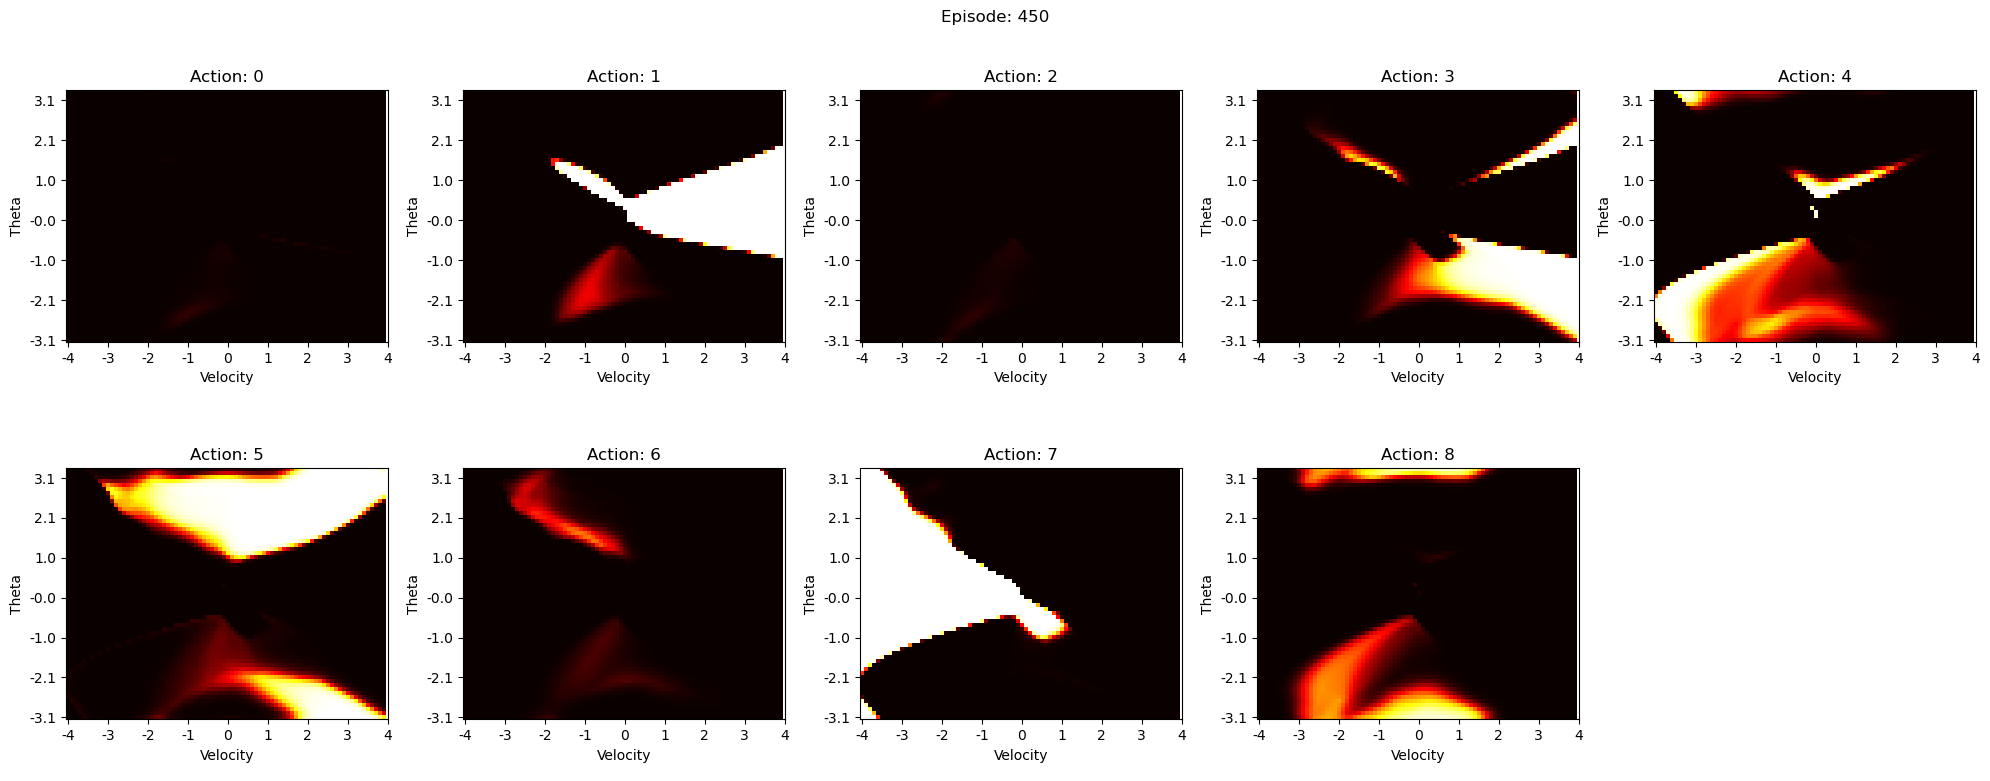

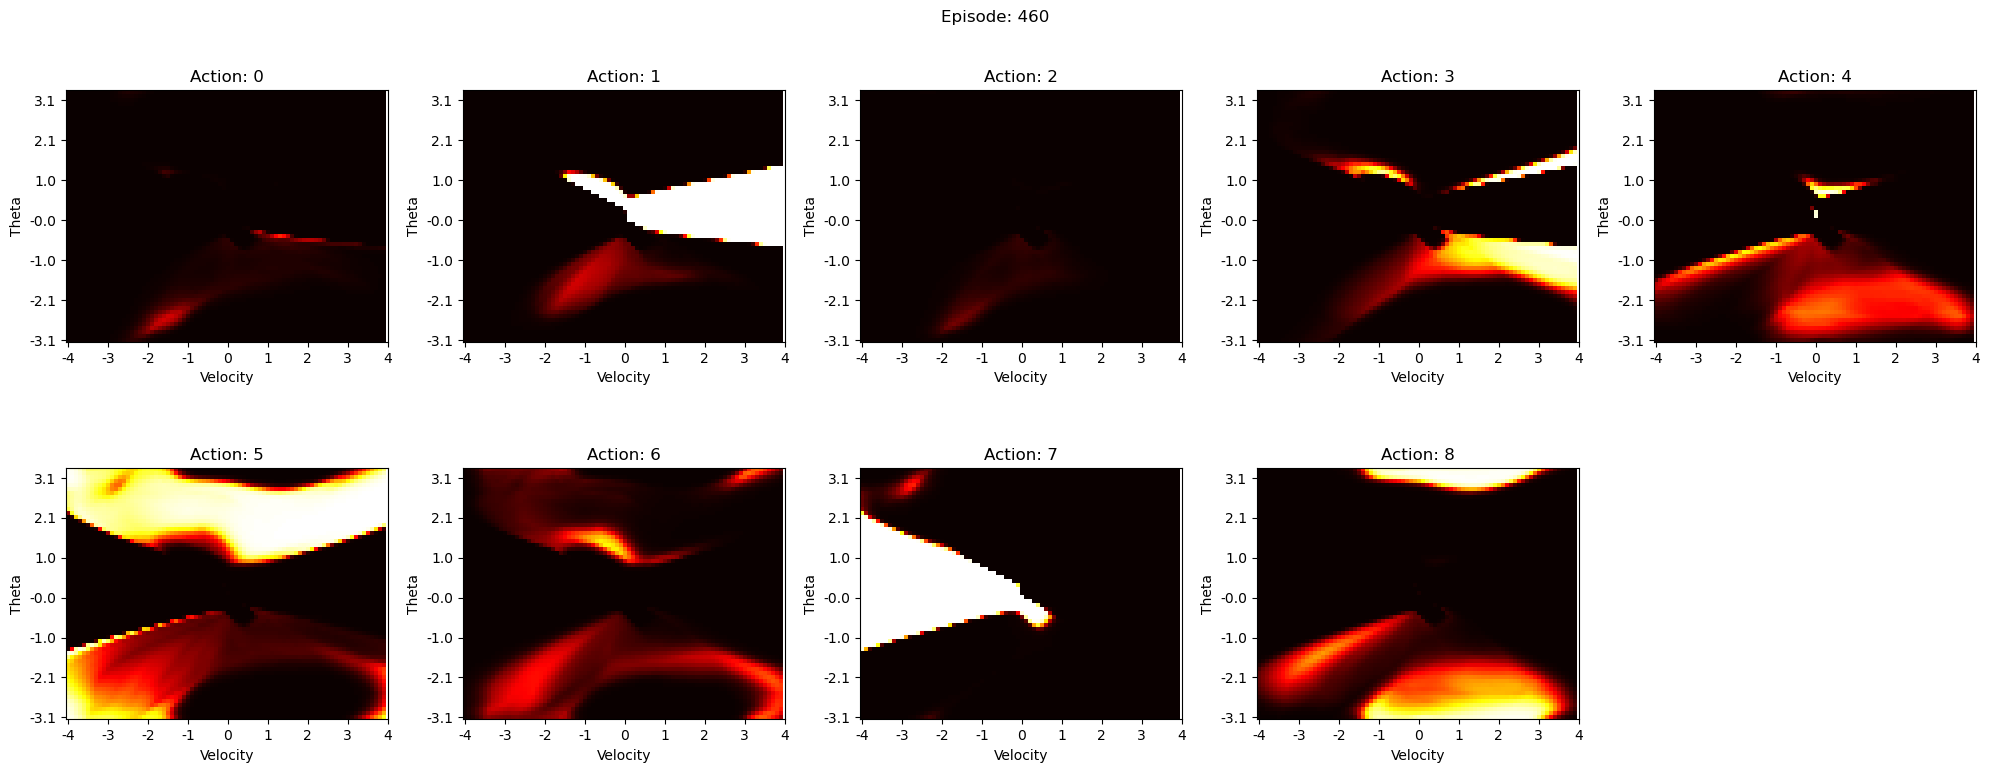

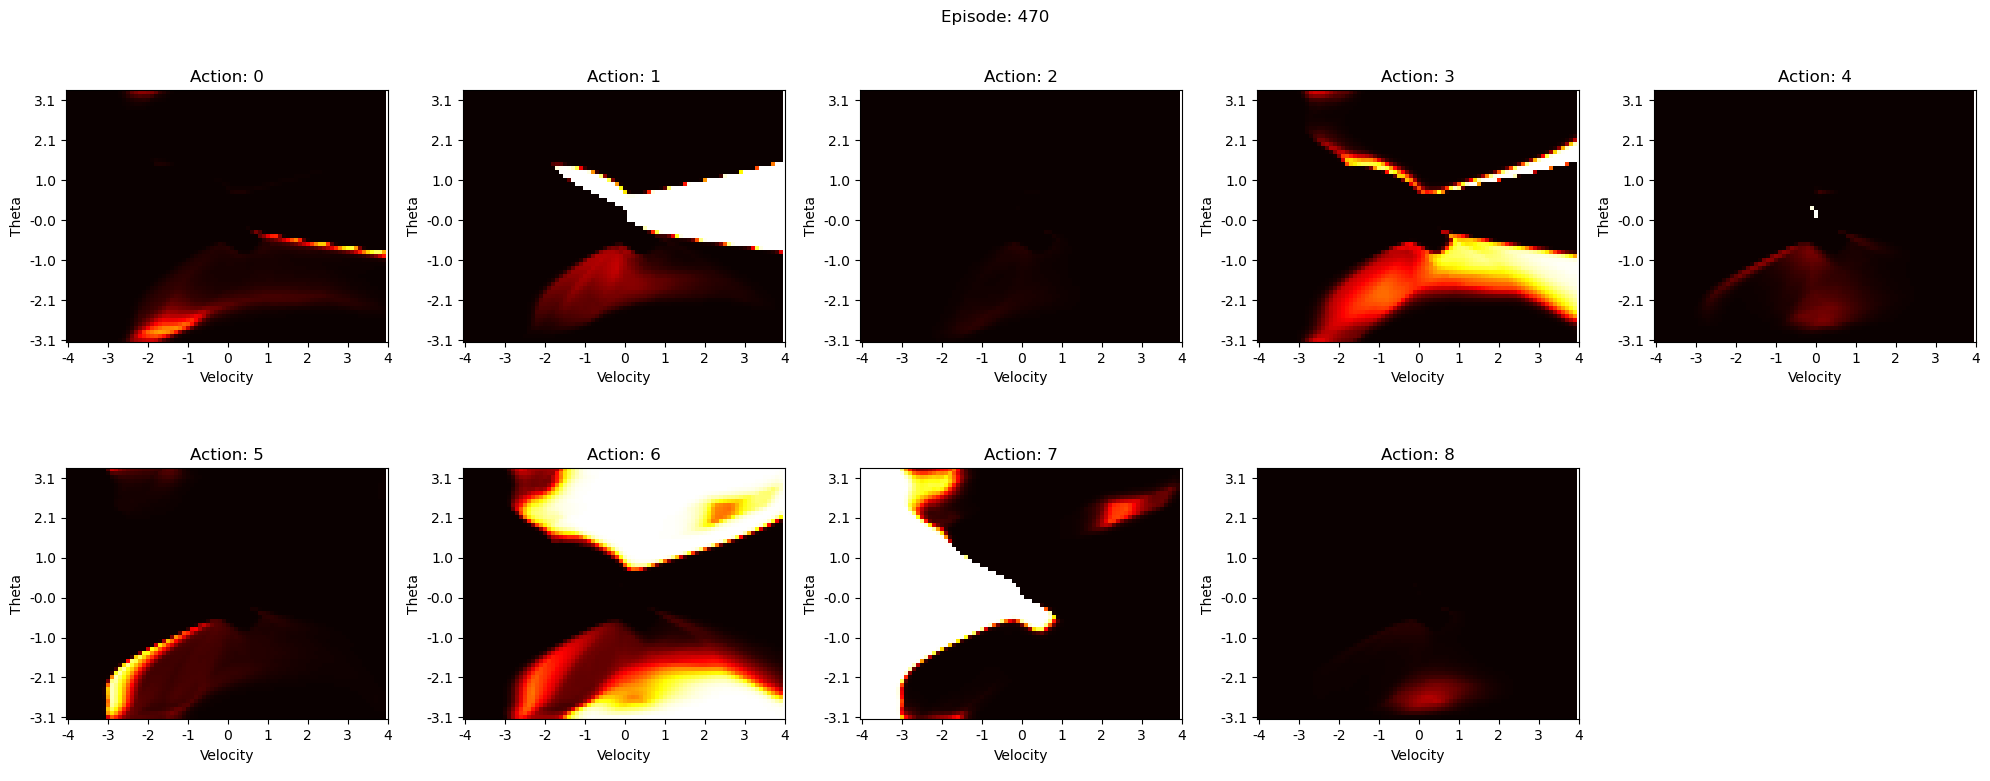

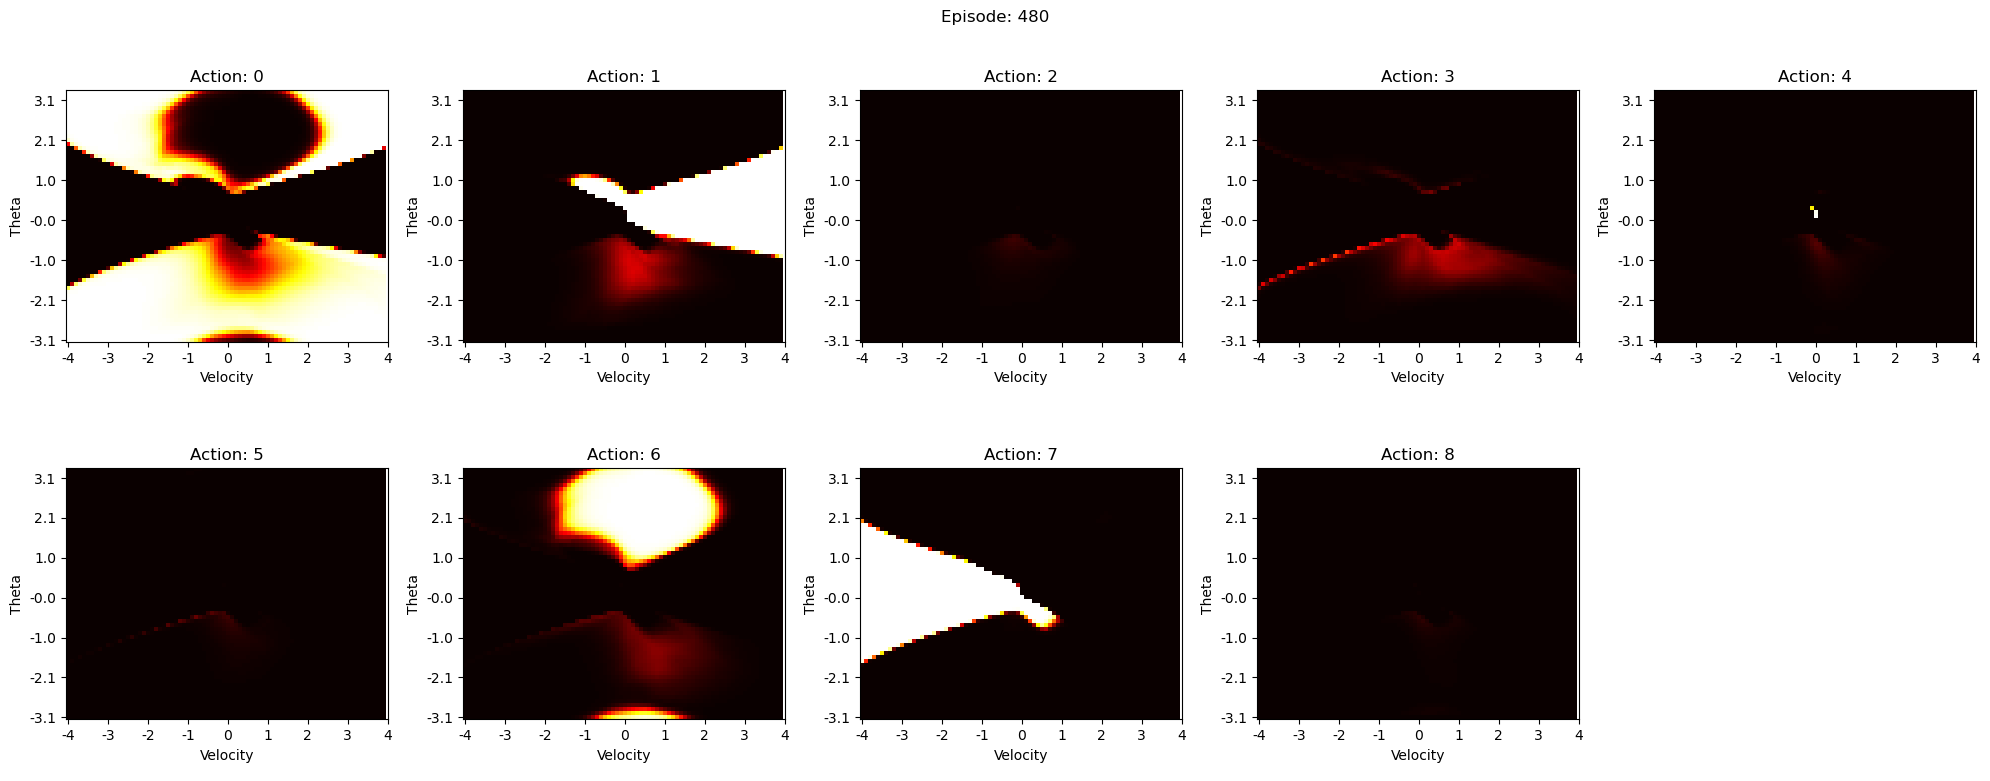

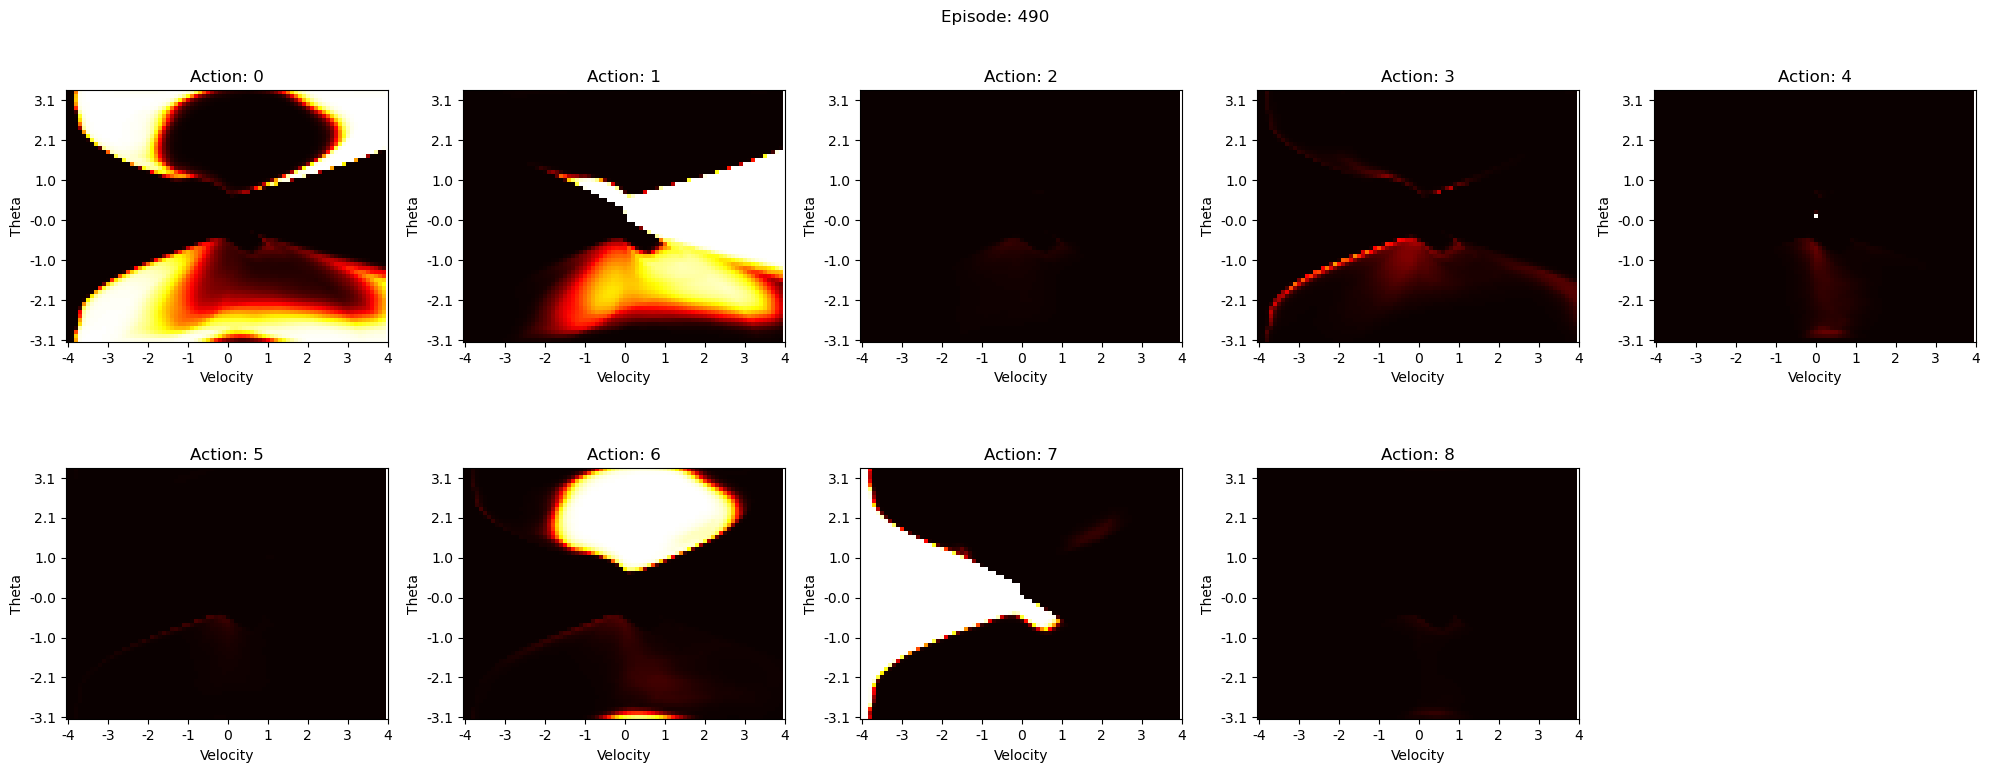

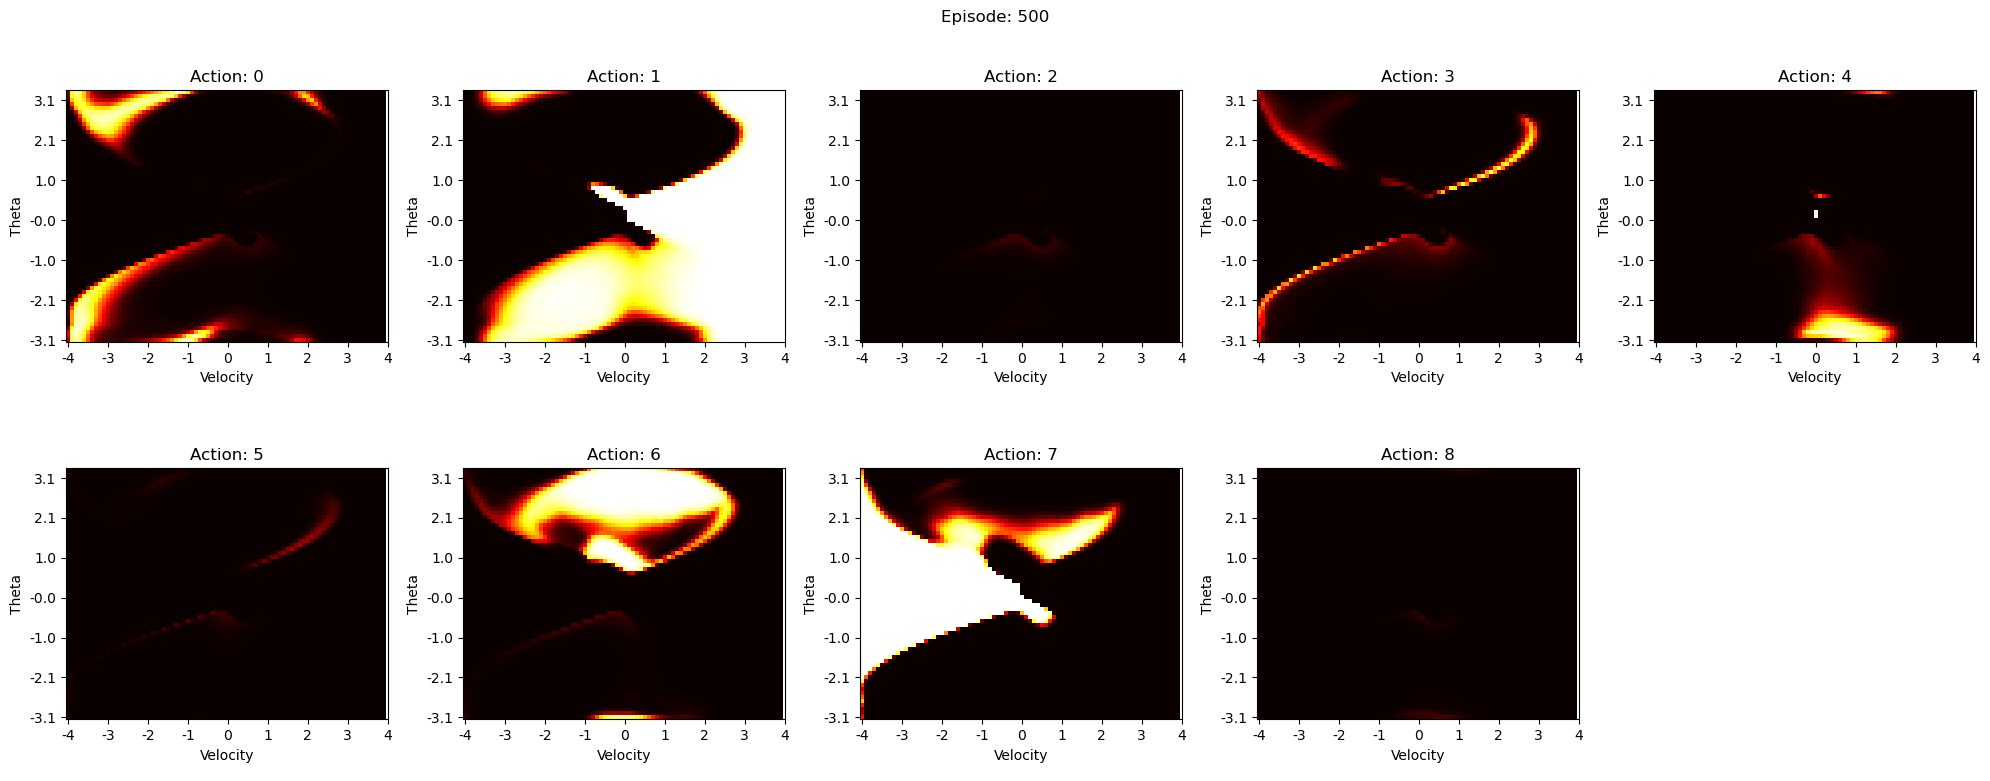

In [5]:
gravity = 5
# env = gym.make("Pendulum-v1", g=9.81, render_mode="human")
env = gym.make("Pendulum-v1", g=gravity, render_mode="human")
model = DQN(3, 9)

for episode in range(1000):
    if episode % 10 == 0:
        env = gym.make("Pendulum-v1", g=gravity, render_mode="human")
    else:
        env = gym.make("Pendulum-v1", g=gravity)
    state, info = env.reset()
    terminated = False
    truncated = False
    step = 0

    rewards = []

    nice_state = False

    while not terminated and step < 500:

        # 모델로 행동 예측
        action = model.call(np.array([state])).numpy()[0]  # type: ignore
        action = np.random.choice(9, p=action)

        # 행동 실행
        next_state, reward, terminated, truncated, info = env.step((action/2-2,))

        if next_state[0] > 0.985 and abs(next_state[2]) < 0.2:
            nice_state = True
            reward += 50  # type: ignore
        elif nice_state:
            nice_state = False
            reward -= 50  # type: ignore

        if next_state[0] > 0.9:
            if next_state[0] < state[0]:
                if abs(next_state[2]) > abs(state[2]):
                    reward -= 10  # type: ignore
            if next_state[0] > state[0]:
                reward += 10  # type: ignore


        # 리플레이 버퍼에 기억
        model.remember(state, action, reward, next_state)
        
        # 모델 업데이트
        if step % 50 == 0:
            update_model(model)

        state = next_state
        step += 1

        rewards.append(reward)

    if episode % 10 == 0:
        draw_qvalue(model, episode)
    
    print("Episode: {}, Steps: {}, Score: {:.2f}, Last Score: {:.2f}".format(episode, step, sum(rewards) / len(rewards), sum(rewards[-10:])/10))

env.close()

In [6]:
model.save_weights('model8', save_format='tf')